In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
import nltk
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [3]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score
from nltk.tokenize import word_tokenize
from tqdm import tqdm

## Defalut case

In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from nltk.tokenize import word_tokenize
from sklearn.metrics import accuracy_score
from tqdm import tqdm  # Import tqdm for progress bars

# Load and preprocess data
path_to_dataset = "/content/drive/MyDrive/diploma/datasets/HateSpeechDatasetBalanced.csv"
df = pd.read_csv(path_to_dataset)
df = df.sample(frac=0.05, random_state=42)
df = df[['Content', 'Label']]

# Tokenization and encoding
def preprocess(text):
    return word_tokenize(text.lower())

df['Content'] = df['Content'].apply(preprocess)

In [ ]:
# Split the dataset into training and testing sets
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

# Build vocabulary
all_words = [word for tweet in train_df['Content'] for word in tweet]
vocab = sorted(set(all_words))
word_to_idx = {word: idx+1 for idx, word in enumerate(vocab)}
vocab_size = len(vocab) + 1  # +1 for padding index

# Encode tweets
def encode_tweet(tweet):
    return [word_to_idx[word] for word in tweet if word in word_to_idx]

train_df['Content'] = train_df['Content'].apply(encode_tweet)
test_df['Content'] = test_df['Content'].apply(encode_tweet)

# Pad sequences
def pad_sequences(sequences, max_len):
    return np.array([seq + [0]*(max_len-len(seq)) if len(seq) < max_len else seq[:max_len] for seq in sequences])

MAX_LEN = 100
X_train = pad_sequences(train_df['Content'], MAX_LEN)
X_test = pad_sequences(test_df['Content'], MAX_LEN)

# Encode labels
le = LabelEncoder()
y_train = le.fit_transform(train_df['Label'])
y_test = le.transform(test_df['Label'])

# Create Dataset and DataLoader
class HateSpeechDataset(Dataset):
    def __init__(self, tweets, labels):
        self.tweets = tweets
        self.labels = labels

    def __len__(self):
        return len(self.tweets)

    def __getitem__(self, idx):
        return torch.tensor(self.tweets[idx], dtype=torch.long), torch.tensor(self.labels[idx], dtype=torch.long)

train_dataset = HateSpeechDataset(X_train, y_train)
test_dataset = HateSpeechDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64)

# Define the LSTM model
class LSTMClassifier(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_size, output_size, num_layers=1):
        super(LSTMClassifier, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.embedding(x)
        h0 = torch.zeros(self.lstm.num_layers, x.size(0), self.lstm.hidden_size).to(x.device)
        c0 = torch.zeros(self.lstm.num_layers, x.size(0), self.lstm.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return self.softmax(out)

# Instantiate the model, loss function, and optimizer
embed_size = 100
hidden_size = 128
output_size = 2  # Binary classification (0 or 1)

model = LSTMClassifier(vocab_size, embed_size, hidden_size, output_size)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Define the training function
def train(model, data_loader, optimizer, criterion):
    model.train()
    running_loss = 0.0
    correct_preds = 0
    total_preds = 0

    for tweets, labels in tqdm(data_loader, desc='Training', leave=False):
        optimizer.zero_grad()
        outputs = model(tweets)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * tweets.size(0)
        _, predicted = torch.max(outputs, 1)
        correct_preds += (predicted == labels).sum().item()
        total_preds += labels.size(0)

    avg_loss = running_loss / len(data_loader.dataset)
    accuracy = correct_preds / total_preds
    return avg_loss, accuracy

# Define the evaluation function
def evaluate(model, data_loader, criterion):
    model.eval()
    running_loss = 0.0
    correct_preds = 0
    total_preds = 0

    with torch.no_grad():
        for tweets, labels in tqdm(data_loader, desc='Evaluating', leave=False):
            outputs = model(tweets)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * tweets.size(0)
            _, predicted = torch.max(outputs, 1)
            correct_preds += (predicted == labels).sum().item()
            total_preds += labels.size(0)

    avg_loss = running_loss / len(data_loader.dataset)
    accuracy = correct_preds / total_preds
    return avg_loss, accuracy

In [ ]:
# Train the model
N_EPOCHS = 5
train_losses = []
valid_losses = []
train_accs = []
valid_accs = []

for epoch in range(N_EPOCHS):
    train_loss, train_acc = train(model, train_loader, optimizer, criterion)
    valid_loss, valid_acc = evaluate(model, test_loader, criterion)

    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    train_accs.append(train_acc)
    valid_accs.append(valid_acc)

    print(f'Epoch: {epoch+1}')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

Epoch: 1
	Train Loss: 0.657 | Train Acc: 60.11%
	 Val. Loss: 0.607 |  Val. Acc: 68.89%


Epoch: 2
	Train Loss: 0.562 | Train Acc: 73.94%
	 Val. Loss: 0.546 |  Val. Acc: 74.77%


Epoch: 3
	Train Loss: 0.511 | Train Acc: 79.38%
	 Val. Loss: 0.524 |  Val. Acc: 77.91%


Epoch: 4
	Train Loss: 0.476 | Train Acc: 83.24%
	 Val. Loss: 0.522 |  Val. Acc: 77.94%


Epoch: 5
	Train Loss: 0.457 | Train Acc: 85.29%
	 Val. Loss: 0.510 |  Val. Acc: 79.59%


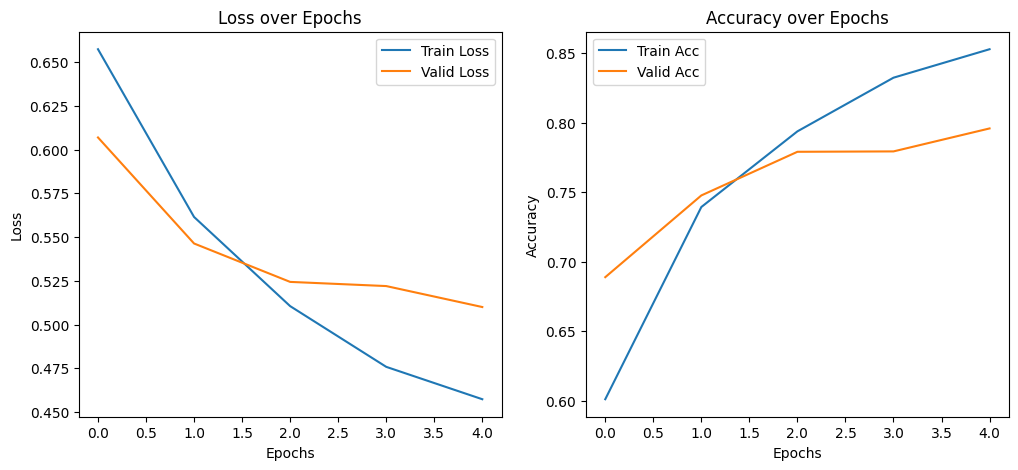

In [ ]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(N_EPOCHS), train_losses, label='Train Loss')
plt.plot(range(N_EPOCHS), valid_losses, label='Valid Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss over Epochs')

plt.subplot(1, 2, 2)
plt.plot(range(N_EPOCHS), train_accs, label='Train Acc')
plt.plot(range(N_EPOCHS), valid_accs, label='Valid Acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy over Epochs')

plt.show()

In [ ]:
# Train the model
N_EPOCHS = 5

for epoch in range(N_EPOCHS):
    train_loss, train_acc = train(model, train_loader, optimizer, criterion)
    valid_loss, valid_acc = evaluate(model, test_loader, criterion)

    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    train_accs.append(train_acc)
    valid_accs.append(valid_acc)

    print(f'Epoch: {epoch+1+5}')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

Epoch: 6
	Train Loss: 0.451 | Train Acc: 86.03%
	 Val. Loss: 0.519 |  Val. Acc: 78.53%


Epoch: 7
	Train Loss: 0.434 | Train Acc: 87.87%
	 Val. Loss: 0.509 |  Val. Acc: 79.95%


Epoch: 8
	Train Loss: 0.417 | Train Acc: 89.60%
	 Val. Loss: 0.508 |  Val. Acc: 79.92%


Epoch: 9
	Train Loss: 0.414 | Train Acc: 89.81%
	 Val. Loss: 0.515 |  Val. Acc: 79.26%


Epoch: 10
	Train Loss: 0.409 | Train Acc: 90.31%
	 Val. Loss: 0.511 |  Val. Acc: 79.70%


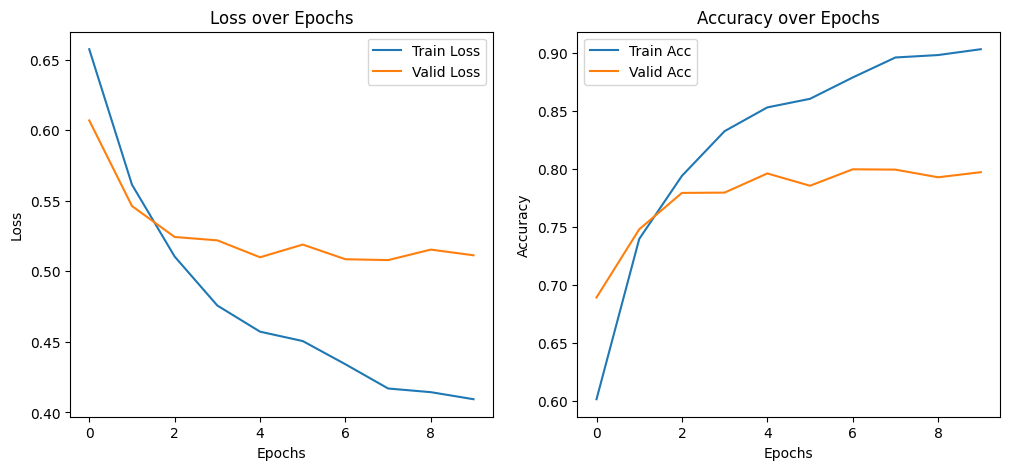

In [ ]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(N_EPOCHS+N_EPOCHS), train_losses, label='Train Loss')
plt.plot(range(N_EPOCHS+N_EPOCHS), valid_losses, label='Valid Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss over Epochs')

plt.subplot(1, 2, 2)
plt.plot(range(N_EPOCHS+N_EPOCHS), train_accs, label='Train Acc')
plt.plot(range(N_EPOCHS+N_EPOCHS), valid_accs, label='Valid Acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy over Epochs')

plt.show()

## Next

In [ ]:
# Load and preprocess the dataset
path_to_dataset = "/content/drive/MyDrive/diploma/datasets/HateSpeechDatasetBalanced.csv"
df = pd.read_csv(path_to_dataset)
df = df.sample(frac=0.05, random_state=42)
df = df[['Content', 'Label']]

def preprocess(text):
    return word_tokenize(text.lower())

df['Content'] = df['Content'].apply(preprocess)

In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score
from nltk.tokenize import word_tokenize
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Define EarlyStopping class
class EarlyStopping:
    def __init__(self, patience=3, delta=0.01):
        self.patience = patience
        self.delta = delta
        self.best_loss = float('inf')
        self.counter = 0
        self.stop_training = False

    def __call__(self, val_loss):
        if val_loss < self.best_loss - self.delta:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.stop_training = True

# Split the dataset into training and testing sets
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

# Build vocabulary
all_words = [word for tweet in train_df['Content'] for word in tweet]
vocab = sorted(set(all_words))
word_to_idx = {word: idx+1 for idx, word in enumerate(vocab)}
vocab_size = len(vocab) + 1  # +1 for padding index

# Encode tweets
def encode_tweet(tweet):
    return [word_to_idx[word] for word in tweet if word in word_to_idx]

train_df['Content'] = train_df['Content'].apply(encode_tweet)
test_df['Content'] = test_df['Content'].apply(encode_tweet)

# Pad sequences
def pad_sequences(sequences, max_len):
    return np.array([seq + [0]*(max_len-len(seq)) if len(seq) < max_len else seq[:max_len] for seq in sequences])

MAX_LEN = 100
X_train = pad_sequences(train_df['Content'], MAX_LEN)
X_test = pad_sequences(test_df['Content'], MAX_LEN)

# Encode labels
le = LabelEncoder()
y_train = le.fit_transform(train_df['Label'])
y_test = le.transform(test_df['Label'])

# Create Dataset and DataLoader
class HateSpeechDataset(Dataset):
    def __init__(self, tweets, labels):
        self.tweets = tweets
        self.labels = labels

    def __len__(self):
        return len(self.tweets)

    def __getitem__(self, idx):
        return torch.tensor(self.tweets[idx]), torch.tensor(self.labels[idx])

train_dataset = HateSpeechDataset(X_train, y_train)
test_dataset = HateSpeechDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64)

# Define the LSTM model with dropout
class LSTMClassifier(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_size, output_size, num_layers=1, dropout=0.5):
        super(LSTMClassifier, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size, output_size)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.embedding(x)
        h0 = torch.zeros(self.lstm.num_layers, x.size(0), self.lstm.hidden_size).to(x.device)
        c0 = torch.zeros(self.lstm.num_layers, x.size(0), self.lstm.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return self.softmax(out)

# Initialize model, optimizer, and criterion
embed_size = 100
hidden_size = 128
output_size = len(np.unique(y_train))
num_layers = 1
dropout = 0.5

model = LSTMClassifier(vocab_size, embed_size, hidden_size, output_size, num_layers, dropout)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
scheduler = ReduceLROnPlateau(optimizer, 'min', patience=2, factor=0.5)
early_stopping = EarlyStopping(patience=3, delta=0.01)

# Training and evaluation functions
def train(model, data_loader, optimizer, criterion):
    model.train()
    running_loss = 0.0
    correct_preds = 0
    total_preds = 0

    for tweets, labels in tqdm(data_loader, desc='Training'):
        optimizer.zero_grad()
        outputs = model(tweets)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * tweets.size(0)
        _, predicted = torch.max(outputs, 1)
        correct_preds += (predicted == labels).sum().item()
        total_preds += labels.size(0)

    avg_loss = running_loss / len(data_loader.dataset)
    accuracy = correct_preds / total_preds
    return avg_loss, accuracy

def evaluate(model, data_loader, criterion):
    model.eval()
    running_loss = 0.0
    correct_preds = 0
    total_preds = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for tweets, labels in tqdm(data_loader, desc='Evaluating'):
            outputs = model(tweets)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * tweets.size(0)
            _, predicted = torch.max(outputs, 1)
            correct_preds += (predicted == labels).sum().item()
            total_preds += labels.size(0)

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    avg_loss = running_loss / len(data_loader.dataset)
    accuracy = correct_preds / total_preds
    f1 = f1_score(all_labels, all_preds, average='weighted')  # or 'micro', 'macro'
    return avg_loss, accuracy, f1

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


In [ ]:
# Training loop
N_EPOCHS = 5
train_losses = []
valid_losses = []
train_accs = []
valid_accs = []
valid_f1s = []

for epoch in range(N_EPOCHS):
    train_loss, train_acc = train(model, train_loader, optimizer, criterion)
    valid_loss, valid_acc, valid_f1 = evaluate(model, test_loader, criterion)

    scheduler.step(valid_loss)  # Step scheduler based on validation loss
    early_stopping(valid_loss)
    if early_stopping.stop_training:
        print("Early stopping triggered")
        break

    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    train_accs.append(train_acc)
    valid_accs.append(valid_acc)
    valid_f1s.append(valid_f1)

    print(f'Epoch: {epoch+1}')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}% | Val. F1: {valid_f1:.2f}')

Evaluating: 100%|██████████| 114/114 [00:01<00:00, 110.38it/s]


Epoch: 1
	Train Loss: 0.661 | Train Acc: 60.47%
	 Val. Loss: 0.663 |  Val. Acc: 59.54% | Val. F1: 0.54


Evaluating: 100%|██████████| 114/114 [00:00<00:00, 117.30it/s]


Epoch: 2
	Train Loss: 0.583 | Train Acc: 71.56%
	 Val. Loss: 0.612 |  Val. Acc: 68.67% | Val. F1: 0.67


Evaluating: 100%|██████████| 114/114 [00:01<00:00, 111.12it/s]


Epoch: 3
	Train Loss: 0.541 | Train Acc: 76.26%
	 Val. Loss: 0.545 |  Val. Acc: 75.68% | Val. F1: 0.76


Evaluating: 100%|██████████| 114/114 [00:00<00:00, 114.59it/s]


Epoch: 4
	Train Loss: 0.506 | Train Acc: 80.12%
	 Val. Loss: 0.543 |  Val. Acc: 75.82% | Val. F1: 0.76


Evaluating: 100%|██████████| 114/114 [00:00<00:00, 117.27it/s]

Epoch: 5
	Train Loss: 0.475 | Train Acc: 83.46%
	 Val. Loss: 0.528 |  Val. Acc: 77.25% | Val. F1: 0.77


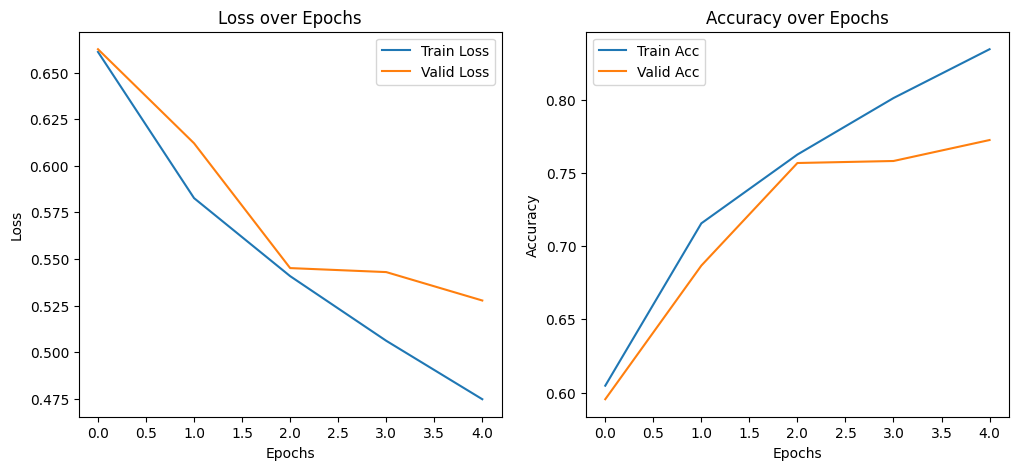

In [ ]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(N_EPOCHS), train_losses, label='Train Loss')
plt.plot(range(N_EPOCHS), valid_losses, label='Valid Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss over Epochs')

plt.subplot(1, 2, 2)
plt.plot(range(N_EPOCHS), train_accs, label='Train Acc')
plt.plot(range(N_EPOCHS), valid_accs, label='Valid Acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy over Epochs')

plt.show()

In [ ]:
# Train the model
N_EPOCHS = 5


for epoch in range(N_EPOCHS):
    train_loss, train_acc = train(model, train_loader, optimizer, criterion)
    valid_loss, valid_acc, valid_f1 = evaluate(model, test_loader, criterion)

    scheduler.step(valid_loss)  # Step scheduler based on validation loss
    early_stopping(valid_loss)
    if early_stopping.stop_training:
        print("Early stopping triggered")
        break

    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    train_accs.append(train_acc)
    valid_accs.append(valid_acc)
    valid_f1s.append(valid_f1)

    print(f'Epoch: {epoch+1+5}')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}% | Val. F1: {valid_f1:.2f}')

Evaluating: 100%|██████████| 114/114 [00:01<00:00, 113.76it/s]


Epoch: 6
	Train Loss: 0.450 | Train Acc: 86.12%
	 Val. Loss: 0.523 |  Val. Acc: 78.27% | Val. F1: 0.78


Evaluating: 100%|██████████| 114/114 [00:01<00:00, 111.49it/s]


Epoch: 7
	Train Loss: 0.437 | Train Acc: 87.50%
	 Val. Loss: 0.525 |  Val. Acc: 78.16% | Val. F1: 0.78


Evaluating: 100%|██████████| 114/114 [00:01<00:00, 111.52it/s]

Early stopping triggered


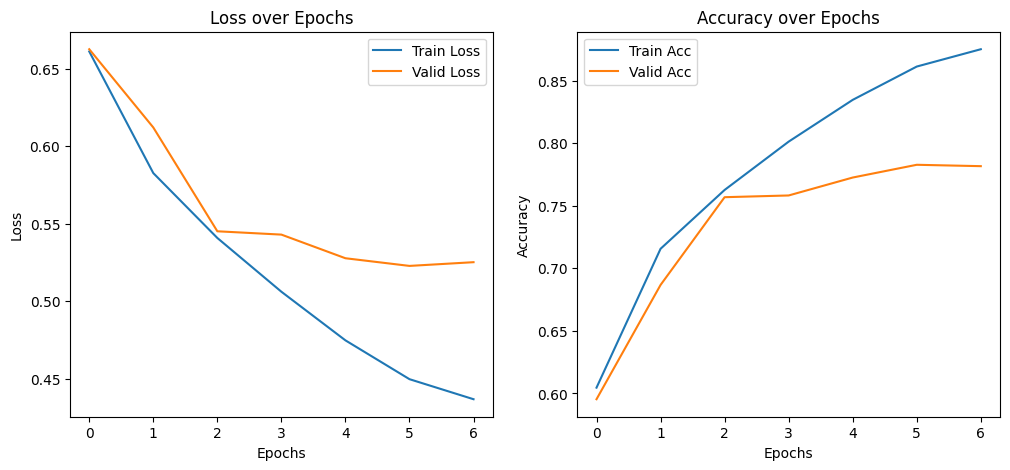

In [ ]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(N_EPOCHS+2), train_losses, label='Train Loss')
plt.plot(range(N_EPOCHS+2), valid_losses, label='Valid Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss over Epochs')

plt.subplot(1, 2, 2)
plt.plot(range(N_EPOCHS+2), train_accs, label='Train Acc')
plt.plot(range(N_EPOCHS+2), valid_accs, label='Valid Acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy over Epochs')

plt.show()

## Next default

In [ ]:
# Load and preprocess the dataset
path_to_dataset = "/content/drive/MyDrive/diploma/datasets/HateSpeechDatasetBalanced.csv"
df = pd.read_csv(path_to_dataset)
df = df.sample(frac=0.05, random_state=42)
df = df[['Content', 'Label']]

def preprocess(text):
    return word_tokenize(text.lower())

df['Content'] = df['Content'].apply(preprocess)

### Overwride imports

In [ ]:
def custom_lstm_cell(input, hidden, w_ih, w_hh, b_ih, b_hh):
    # type: (Tensor, Tuple[Tensor, Tensor], Tensor, Tensor, Tensor, Tensor) -> Tuple[Tensor, Tensor]
    hx, cx = hidden
    gates = torch.mm(input, w_ih.t()) + torch.mm(hx, w_hh.t()) + b_ih + b_hh

    ingate, forgetgate, cellgate, outgate = gates.chunk(4, 1)

    ingate = torch.sigmoid(ingate)
    forgetgate = torch.sigmoid(forgetgate)
    cellgate = torch.tanh(cellgate)
    outgate = torch.sigmoid(outgate)

    cy = (forgetgate * cx) + (ingate * cellgate)
    hy = outgate * torch.tanh(cy)
    print("EEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEE")

    return hy, cy

In [ ]:
import math
import numbers
import warnings
import weakref
from typing import List, Optional, overload, Tuple
from typing_extensions import deprecated

import torch
from torch import _VF, Tensor
from torch.nn import init
from torch.nn.parameter import Parameter
from torch.nn.utils.rnn import PackedSequence

Module = nn.Module


__all__ = [
    "RNNBase",
    "RNN",
    "LSTM",
    "GRU",
    "RNNCellBase",
    "RNNCell",
    "LSTMCell",
    "GRUCell",
]

_rnn_impls = {
    "RNN_TANH": _VF.rnn_tanh,
    "RNN_RELU": _VF.rnn_relu,
}


def _apply_permutation(tensor: Tensor, permutation: Tensor, dim: int = 1) -> Tensor:
    return tensor.index_select(dim, permutation)


@deprecated(
    "`apply_permutation` is deprecated, please use `tensor.index_select(dim, permutation)` instead",
    category=FutureWarning,
)
def apply_permutation(tensor: Tensor, permutation: Tensor, dim: int = 1) -> Tensor:
    return _apply_permutation(tensor, permutation, dim)


class RNNBase(Module):
    r"""Base class for RNN modules (RNN, LSTM, GRU).

    Implements aspects of RNNs shared by the RNN, LSTM, and GRU classes, such as module initialization
    and utility methods for parameter storage management.

    .. note::
        The forward method is not implemented by the RNNBase class.

    .. note::
        LSTM and GRU classes override some methods implemented by RNNBase.
    """

    __constants__ = [
        "mode",
        "input_size",
        "hidden_size",
        "num_layers",
        "bias",
        "batch_first",
        "dropout",
        "bidirectional",
        "proj_size",
    ]
    __jit_unused_properties__ = ["all_weights"]

    mode: str
    input_size: int
    hidden_size: int
    num_layers: int
    bias: bool
    batch_first: bool
    dropout: float
    bidirectional: bool
    proj_size: int

    def __init__(
        self,
        mode: str,
        input_size: int,
        hidden_size: int,
        num_layers: int = 1,
        bias: bool = True,
        batch_first: bool = False,
        dropout: float = 0.0,
        bidirectional: bool = False,
        proj_size: int = 0,
        device=None,
        dtype=None,
    ) -> None:
        factory_kwargs = {"device": device, "dtype": dtype}
        super().__init__()
        self.mode = mode
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.bias = bias
        self.batch_first = batch_first
        self.dropout = float(dropout)
        self.bidirectional = bidirectional
        self.proj_size = proj_size
        self._flat_weight_refs: List[Optional[weakref.ReferenceType[Parameter]]] = []
        num_directions = 2 if bidirectional else 1

        if (
            not isinstance(dropout, numbers.Number)
            or not 0 <= dropout <= 1
            or isinstance(dropout, bool)
        ):
            raise ValueError(
                "dropout should be a number in range [0, 1] "
                "representing the probability of an element being "
                "zeroed"
            )
        if dropout > 0 and num_layers == 1:
            warnings.warn(
                "dropout option adds dropout after all but last "
                "recurrent layer, so non-zero dropout expects "
                f"num_layers greater than 1, but got dropout={dropout} and "
                f"num_layers={num_layers}"
            )

        if not isinstance(hidden_size, int):
            raise TypeError(
                f"hidden_size should be of type int, got: {type(hidden_size).__name__}"
            )
        if hidden_size <= 0:
            raise ValueError("hidden_size must be greater than zero")
        if num_layers <= 0:
            raise ValueError("num_layers must be greater than zero")
        if proj_size < 0:
            raise ValueError(
                "proj_size should be a positive integer or zero to disable projections"
            )
        if proj_size >= hidden_size:
            raise ValueError("proj_size has to be smaller than hidden_size")

        if mode == "LSTM":
            gate_size = 4 * hidden_size
        elif mode == "GRU":
            gate_size = 3 * hidden_size
        elif mode == "RNN_TANH":
            gate_size = hidden_size
        elif mode == "RNN_RELU":
            gate_size = hidden_size
        else:
            raise ValueError("Unrecognized RNN mode: " + mode)

        self._flat_weights_names = []
        self._all_weights = []
        for layer in range(num_layers):
            for direction in range(num_directions):
                real_hidden_size = proj_size if proj_size > 0 else hidden_size
                layer_input_size = (
                    input_size if layer == 0 else real_hidden_size * num_directions
                )

                w_ih = Parameter(
                    torch.empty((gate_size, layer_input_size), **factory_kwargs)
                )
                w_hh = Parameter(
                    torch.empty((gate_size, real_hidden_size), **factory_kwargs)
                )
                b_ih = Parameter(torch.empty(gate_size, **factory_kwargs))
                # Second bias vector included for CuDNN compatibility. Only one
                # bias vector is needed in standard definition.
                b_hh = Parameter(torch.empty(gate_size, **factory_kwargs))
                layer_params: Tuple[Tensor, ...] = ()
                if self.proj_size == 0:
                    if bias:
                        layer_params = (w_ih, w_hh, b_ih, b_hh)
                    else:
                        layer_params = (w_ih, w_hh)
                else:
                    w_hr = Parameter(
                        torch.empty((proj_size, hidden_size), **factory_kwargs)
                    )
                    if bias:
                        layer_params = (w_ih, w_hh, b_ih, b_hh, w_hr)
                    else:
                        layer_params = (w_ih, w_hh, w_hr)

                suffix = "_reverse" if direction == 1 else ""
                param_names = ["weight_ih_l{}{}", "weight_hh_l{}{}"]
                if bias:
                    param_names += ["bias_ih_l{}{}", "bias_hh_l{}{}"]
                if self.proj_size > 0:
                    param_names += ["weight_hr_l{}{}"]
                param_names = [x.format(layer, suffix) for x in param_names]

                for name, param in zip(param_names, layer_params):
                    setattr(self, name, param)
                self._flat_weights_names.extend(param_names)
                self._all_weights.append(param_names)

        self._init_flat_weights()

        self.reset_parameters()

    def _init_flat_weights(self):
        self._flat_weights = [
            getattr(self, wn) if hasattr(self, wn) else None
            for wn in self._flat_weights_names
        ]
        self._flat_weight_refs = [
            weakref.ref(w) if w is not None else None for w in self._flat_weights
        ]
        self.flatten_parameters()

    def __setattr__(self, attr, value):
        if hasattr(self, "_flat_weights_names") and attr in self._flat_weights_names:
            # keep self._flat_weights up to date if you do self.weight = ...
            idx = self._flat_weights_names.index(attr)
            self._flat_weights[idx] = value
        super().__setattr__(attr, value)

    def flatten_parameters(self) -> None:
        """Reset parameter data pointer so that they can use faster code paths.

        Right now, this works only if the module is on the GPU and cuDNN is enabled.
        Otherwise, it's a no-op.
        """
        # Short-circuits if _flat_weights is only partially instantiated
        if len(self._flat_weights) != len(self._flat_weights_names):
            return

        for w in self._flat_weights:
            if not isinstance(w, Tensor):
                return
        # Short-circuits if any tensor in self._flat_weights is not acceptable to cuDNN
        # or the tensors in _flat_weights are of different dtypes

        first_fw = self._flat_weights[0]
        dtype = first_fw.dtype
        for fw in self._flat_weights:
            if (
                not isinstance(fw, Tensor)
                or not (fw.dtype == dtype)
                or not fw.is_cuda
                or not torch.backends.cudnn.is_acceptable(fw)
            ):
                return

        # If any parameters alias, we fall back to the slower, copying code path. This is
        # a sufficient check, because overlapping parameter buffers that don't completely
        # alias would break the assumptions of the uniqueness check in
        # Module.named_parameters().
        unique_data_ptrs = {p.data_ptr() for p in self._flat_weights}
        if len(unique_data_ptrs) != len(self._flat_weights):
            return

        with torch.cuda.device_of(first_fw):
            import torch.backends.cudnn.rnn as rnn

            # Note: no_grad() is necessary since _cudnn_rnn_flatten_weight is
            # an inplace operation on self._flat_weights
            with torch.no_grad():
                if torch._use_cudnn_rnn_flatten_weight():
                    num_weights = 4 if self.bias else 2
                    if self.proj_size > 0:
                        num_weights += 1
                    torch._cudnn_rnn_flatten_weight(
                        self._flat_weights,
                        num_weights,
                        self.input_size,
                        rnn.get_cudnn_mode(self.mode),
                        self.hidden_size,
                        self.proj_size,
                        self.num_layers,
                        self.batch_first,
                        bool(self.bidirectional),
                    )

    def _apply(self, fn, recurse=True):
        self._flat_weight_refs = []
        ret = super()._apply(fn, recurse)

        # Resets _flat_weights
        # Note: be v. careful before removing this, as 3rd party device types
        # likely rely on this behavior to properly .to() modules like LSTM.
        self._init_flat_weights()

        return ret

    def reset_parameters(self) -> None:
        stdv = 1.0 / math.sqrt(self.hidden_size) if self.hidden_size > 0 else 0
        for weight in self.parameters():
            init.uniform_(weight, -stdv, stdv)

    def check_input(self, input: Tensor, batch_sizes: Optional[Tensor]) -> None:
        if not torch.jit.is_scripting():
            if (
                input.dtype != self._flat_weights[0].dtype
                and not torch._C._is_any_autocast_enabled()
            ):
                raise ValueError(
                    f"input must have the type {self._flat_weights[0].dtype}, got type {input.dtype}"
                )
        expected_input_dim = 2 if batch_sizes is not None else 3
        if input.dim() != expected_input_dim:
            raise RuntimeError(
                f"input must have {expected_input_dim} dimensions, got {input.dim()}"
            )
        if self.input_size != input.size(-1):
            raise RuntimeError(
                f"input.size(-1) must be equal to input_size. Expected {self.input_size}, got {input.size(-1)}"
            )

    def get_expected_hidden_size(
        self, input: Tensor, batch_sizes: Optional[Tensor]
    ) -> Tuple[int, int, int]:
        if batch_sizes is not None:
            mini_batch = int(batch_sizes[0])
        else:
            mini_batch = input.size(0) if self.batch_first else input.size(1)
        num_directions = 2 if self.bidirectional else 1
        if self.proj_size > 0:
            expected_hidden_size = (
                self.num_layers * num_directions,
                mini_batch,
                self.proj_size,
            )
        else:
            expected_hidden_size = (
                self.num_layers * num_directions,
                mini_batch,
                self.hidden_size,
            )
        return expected_hidden_size

    def check_hidden_size(
        self,
        hx: Tensor,
        expected_hidden_size: Tuple[int, int, int],
        msg: str = "Expected hidden size {}, got {}",
    ) -> None:
        if hx.size() != expected_hidden_size:
            raise RuntimeError(msg.format(expected_hidden_size, list(hx.size())))

    def _weights_have_changed(self):
        # Returns True if the weight tensors have changed since the last forward pass.
        # This is the case when used with torch.func.functional_call(), for example.
        weights_changed = False
        for ref, name in zip(self._flat_weight_refs, self._flat_weights_names):
            weight = getattr(self, name) if hasattr(self, name) else None
            if weight is not None and ref is not None and ref() is not weight:
                weights_changed = True
                break
        return weights_changed

    def check_forward_args(
        self, input: Tensor, hidden: Tensor, batch_sizes: Optional[Tensor]
    ):
        self.check_input(input, batch_sizes)
        expected_hidden_size = self.get_expected_hidden_size(input, batch_sizes)

        self.check_hidden_size(hidden, expected_hidden_size)

    def permute_hidden(self, hx: Tensor, permutation: Optional[Tensor]):
        if permutation is None:
            return hx
        return _apply_permutation(hx, permutation)

    def extra_repr(self) -> str:
        s = "{input_size}, {hidden_size}"
        if self.proj_size != 0:
            s += ", proj_size={proj_size}"
        if self.num_layers != 1:
            s += ", num_layers={num_layers}"
        if self.bias is not True:
            s += ", bias={bias}"
        if self.batch_first is not False:
            s += ", batch_first={batch_first}"
        if self.dropout != 0:
            s += ", dropout={dropout}"
        if self.bidirectional is not False:
            s += ", bidirectional={bidirectional}"
        return s.format(**self.__dict__)

    def _update_flat_weights(self):
        if not torch.jit.is_scripting():
            if self._weights_have_changed():
                self._init_flat_weights()

    def __getstate__(self):
        # If weights have been changed, update the _flat_weights in __getstate__ here.
        self._update_flat_weights()
        # Don't serialize the weight references.
        state = self.__dict__.copy()
        del state["_flat_weight_refs"]
        return state

    def __setstate__(self, d):
        super().__setstate__(d)
        if "all_weights" in d:
            self._all_weights = d["all_weights"]
        # In PyTorch 1.8 we added a proj_size member variable to LSTM.
        # LSTMs that were serialized via torch.save(module) before PyTorch 1.8
        # don't have it, so to preserve compatibility we set proj_size here.
        if "proj_size" not in d:
            self.proj_size = 0

        if not isinstance(self._all_weights[0][0], str):
            num_layers = self.num_layers
            num_directions = 2 if self.bidirectional else 1
            self._flat_weights_names = []
            self._all_weights = []
            for layer in range(num_layers):
                for direction in range(num_directions):
                    suffix = "_reverse" if direction == 1 else ""
                    weights = [
                        "weight_ih_l{}{}",
                        "weight_hh_l{}{}",
                        "bias_ih_l{}{}",
                        "bias_hh_l{}{}",
                        "weight_hr_l{}{}",
                    ]
                    weights = [x.format(layer, suffix) for x in weights]
                    if self.bias:
                        if self.proj_size > 0:
                            self._all_weights += [weights]
                            self._flat_weights_names.extend(weights)
                        else:
                            self._all_weights += [weights[:4]]
                            self._flat_weights_names.extend(weights[:4])
                    else:
                        if self.proj_size > 0:
                            self._all_weights += [weights[:2]] + [weights[-1:]]
                            self._flat_weights_names.extend(
                                weights[:2] + [weights[-1:]]
                            )
                        else:
                            self._all_weights += [weights[:2]]
                            self._flat_weights_names.extend(weights[:2])
            self._flat_weights = [
                getattr(self, wn) if hasattr(self, wn) else None
                for wn in self._flat_weights_names
            ]

        self._flat_weight_refs = [
            weakref.ref(w) if w is not None else None for w in self._flat_weights
        ]

    @property
    def all_weights(self) -> List[List[Parameter]]:
        return [
            [getattr(self, weight) for weight in weights]
            for weights in self._all_weights
        ]

    def _replicate_for_data_parallel(self):
        replica = super()._replicate_for_data_parallel()
        # Need to copy these caches, otherwise the replica will share the same
        # flat weights list.
        replica._flat_weights = replica._flat_weights[:]
        replica._flat_weights_names = replica._flat_weights_names[:]
        return replica


class RNN(RNNBase):

    @overload
    def __init__(
        self,
        input_size: int,
        hidden_size: int,
        num_layers: int = 1,
        nonlinearity: str = "tanh",
        bias: bool = True,
        batch_first: bool = False,
        dropout: float = 0.0,
        bidirectional: bool = False,
        device=None,
        dtype=None,
    ) -> None:
        ...

    @overload
    def __init__(self, *args, **kwargs):
        ...

    def __init__(self, *args, **kwargs):
        if "proj_size" in kwargs:
            raise ValueError(
                "proj_size argument is only supported for LSTM, not RNN or GRU"
            )
        if len(args) > 3:
            self.nonlinearity = args[3]
            args = args[:3] + args[4:]
        else:
            self.nonlinearity = kwargs.pop("nonlinearity", "tanh")
        if self.nonlinearity == "tanh":
            mode = "RNN_TANH"
        elif self.nonlinearity == "relu":
            mode = "RNN_RELU"
        else:
            raise ValueError(
                f"Unknown nonlinearity '{self.nonlinearity}'. Select from 'tanh' or 'relu'."
            )
        super().__init__(mode, *args, **kwargs)

    @overload
    @torch._jit_internal._overload_method  # noqa: F811
    def forward(
        self, input: Tensor, hx: Optional[Tensor] = None
    ) -> Tuple[Tensor, Tensor]:
        pass

    @overload
    @torch._jit_internal._overload_method  # noqa: F811
    def forward(
        self, input: PackedSequence, hx: Optional[Tensor] = None
    ) -> Tuple[PackedSequence, Tensor]:
        pass

    def forward(self, input, hx=None):  # noqa: F811
        self._update_flat_weights()

        num_directions = 2 if self.bidirectional else 1
        orig_input = input

        if isinstance(orig_input, PackedSequence):
            input, batch_sizes, sorted_indices, unsorted_indices = input
            max_batch_size = batch_sizes[0]
            # script() is unhappy when max_batch_size is different type in cond branches, so we duplicate
            if hx is None:
                hx = torch.zeros(
                    self.num_layers * num_directions,
                    max_batch_size,
                    self.hidden_size,
                    dtype=input.dtype,
                    device=input.device,
                )
            else:
                # Each batch of the hidden state should match the input sequence that
                # the user believes he/she is passing in.
                hx = self.permute_hidden(hx, sorted_indices)
        else:
            batch_sizes = None
            if input.dim() not in (2, 3):
                raise ValueError(
                    f"RNN: Expected input to be 2D or 3D, got {input.dim()}D tensor instead"
                )
            is_batched = input.dim() == 3
            batch_dim = 0 if self.batch_first else 1
            if not is_batched:
                input = input.unsqueeze(batch_dim)
                if hx is not None:
                    if hx.dim() != 2:
                        raise RuntimeError(
                            f"For unbatched 2-D input, hx should also be 2-D but got {hx.dim()}-D tensor"
                        )
                    hx = hx.unsqueeze(1)
            else:
                if hx is not None and hx.dim() != 3:
                    raise RuntimeError(
                        f"For batched 3-D input, hx should also be 3-D but got {hx.dim()}-D tensor"
                    )
            max_batch_size = input.size(0) if self.batch_first else input.size(1)
            sorted_indices = None
            unsorted_indices = None
            if hx is None:
                hx = torch.zeros(
                    self.num_layers * num_directions,
                    max_batch_size,
                    self.hidden_size,
                    dtype=input.dtype,
                    device=input.device,
                )
            else:
                # Each batch of the hidden state should match the input sequence that
                # the user believes he/she is passing in.
                hx = self.permute_hidden(hx, sorted_indices)

        assert hx is not None
        self.check_forward_args(input, hx, batch_sizes)
        assert self.mode == "RNN_TANH" or self.mode == "RNN_RELU"
        if batch_sizes is None:
            if self.mode == "RNN_TANH":
                result = _VF.rnn_tanh(
                    input,
                    hx,
                    self._flat_weights,
                    self.bias,
                    self.num_layers,
                    self.dropout,
                    self.training,
                    self.bidirectional,
                    self.batch_first,
                )
            else:
                result = _VF.rnn_relu(
                    input,
                    hx,
                    self._flat_weights,
                    self.bias,
                    self.num_layers,
                    self.dropout,
                    self.training,
                    self.bidirectional,
                    self.batch_first,
                )
        else:
            if self.mode == "RNN_TANH":
                result = _VF.rnn_tanh(
                    input,
                    batch_sizes,
                    hx,
                    self._flat_weights,
                    self.bias,
                    self.num_layers,
                    self.dropout,
                    self.training,
                    self.bidirectional,
                )
            else:
                result = _VF.rnn_relu(
                    input,
                    batch_sizes,
                    hx,
                    self._flat_weights,
                    self.bias,
                    self.num_layers,
                    self.dropout,
                    self.training,
                    self.bidirectional,
                )

        output = result[0]
        hidden = result[1]

        if isinstance(orig_input, PackedSequence):
            output_packed = PackedSequence(
                output, batch_sizes, sorted_indices, unsorted_indices
            )
            return output_packed, self.permute_hidden(hidden, unsorted_indices)

        if not is_batched:  # type: ignore[possibly-undefined]
            output = output.squeeze(batch_dim)  # type: ignore[possibly-undefined]
            hidden = hidden.squeeze(1)

        return output, self.permute_hidden(hidden, unsorted_indices)


class LSTM(RNNBase):
    @overload
    def __init__(
        self,
        input_size: int,
        hidden_size: int,
        num_layers: int = 1,
        bias: bool = True,
        batch_first: bool = False,
        dropout: float = 0.0,
        bidirectional: bool = False,
        proj_size: int = 0,
        device=None,
        dtype=None,
    ) -> None:
        ...

    @overload
    def __init__(self, *args, **kwargs):
        ...

    def __init__(self, *args, **kwargs):
        super().__init__("LSTM", *args, **kwargs)

    def get_expected_cell_size(
        self, input: Tensor, batch_sizes: Optional[Tensor]
    ) -> Tuple[int, int, int]:
        if batch_sizes is not None:
            mini_batch = int(batch_sizes[0])
        else:
            mini_batch = input.size(0) if self.batch_first else input.size(1)
        num_directions = 2 if self.bidirectional else 1
        expected_hidden_size = (
            self.num_layers * num_directions,
            mini_batch,
            self.hidden_size,
        )
        return expected_hidden_size

    # In the future, we should prevent mypy from applying contravariance rules here.
    # See torch/nn/modules/module.py::_forward_unimplemented
    def check_forward_args(
        self,
        input: Tensor,
        hidden: Tuple[Tensor, Tensor],  # type: ignore[override]
        batch_sizes: Optional[Tensor],
    ):
        self.check_input(input, batch_sizes)
        self.check_hidden_size(
            hidden[0],
            self.get_expected_hidden_size(input, batch_sizes),
            "Expected hidden[0] size {}, got {}",
        )
        self.check_hidden_size(
            hidden[1],
            self.get_expected_cell_size(input, batch_sizes),
            "Expected hidden[1] size {}, got {}",
        )

    # Same as above, see torch/nn/modules/module.py::_forward_unimplemented
    def permute_hidden(  # type: ignore[override]
        self,
        hx: Tuple[Tensor, Tensor],
        permutation: Optional[Tensor],
    ) -> Tuple[Tensor, Tensor]:
        if permutation is None:
            return hx
        return _apply_permutation(hx[0], permutation), _apply_permutation(
            hx[1], permutation
        )

    # Same as above, see torch/nn/modules/module.py::_forward_unimplemented
    @overload  # type: ignore[override]
    @torch._jit_internal._overload_method  # noqa: F811
    def forward(
        self, input: Tensor, hx: Optional[Tuple[Tensor, Tensor]] = None
    ) -> Tuple[Tensor, Tuple[Tensor, Tensor]]:  # noqa: F811
        pass

    # Same as above, see torch/nn/modules/module.py::_forward_unimplemented
    @overload
    @torch._jit_internal._overload_method  # noqa: F811
    def forward(
        self, input: PackedSequence, hx: Optional[Tuple[Tensor, Tensor]] = None
    ) -> Tuple[PackedSequence, Tuple[Tensor, Tensor]]:  # noqa: F811
        pass

    def forward(self, input, hx=None):  # noqa: F811
        self._update_flat_weights()

        orig_input = input
        # xxx: isinstance check needs to be in conditional for TorchScript to compile
        batch_sizes = None
        do_permute = False
        num_directions = 2 if self.bidirectional else 1
        real_hidden_size = self.proj_size if self.proj_size > 0 else self.hidden_size
        if isinstance(orig_input, PackedSequence):
            input, batch_sizes, sorted_indices, unsorted_indices = input
            max_batch_size = batch_sizes[0]
            if hx is None:
                h_zeros = torch.zeros(
                    self.num_layers * num_directions,
                    max_batch_size,
                    real_hidden_size,
                    dtype=input.dtype,
                    device=input.device,
                )
                c_zeros = torch.zeros(
                    self.num_layers * num_directions,
                    max_batch_size,
                    self.hidden_size,
                    dtype=input.dtype,
                    device=input.device,
                )
                hx = (h_zeros, c_zeros)
            else:
                # Each batch of the hidden state should match the input sequence that
                # the user believes he/she is passing in.
                hx = self.permute_hidden(hx, sorted_indices)
        else:
            if input.dim() not in (2, 3):
                raise ValueError(
                    f"LSTM: Expected input to be 2D or 3D, got {input.dim()}D instead"
                )
            is_batched = input.dim() == 3
            batch_dim = 0 if self.batch_first else 1
            if not is_batched:
                input = input.unsqueeze(batch_dim)
            max_batch_size = input.size(0) if self.batch_first else input.size(1)
            sorted_indices = None
            unsorted_indices = None
            if hx is None:
                h_zeros = torch.zeros(
                    self.num_layers * num_directions,
                    max_batch_size,
                    real_hidden_size,
                    dtype=input.dtype,
                    device=input.device,
                )
                c_zeros = torch.zeros(
                    self.num_layers * num_directions,
                    max_batch_size,
                    self.hidden_size,
                    dtype=input.dtype,
                    device=input.device,
                )
                hx = (h_zeros, c_zeros)
                self.check_forward_args(input, hx, batch_sizes)
            else:
                if is_batched:
                    if hx[0].dim() != 3 or hx[1].dim() != 3:
                        msg = (
                            "For batched 3-D input, hx and cx should "
                            f"also be 3-D but got ({hx[0].dim()}-D, {hx[1].dim()}-D) tensors"
                        )
                        raise RuntimeError(msg)
                else:
                    if hx[0].dim() != 2 or hx[1].dim() != 2:
                        msg = (
                            "For unbatched 2-D input, hx and cx should "
                            f"also be 2-D but got ({hx[0].dim()}-D, {hx[1].dim()}-D) tensors"
                        )
                        raise RuntimeError(msg)
                    hx = (hx[0].unsqueeze(1), hx[1].unsqueeze(1))
                # Each batch of the hidden state should match the input sequence that
                # the user believes he/she is passing in.
                self.check_forward_args(input, hx, batch_sizes)
                hx = self.permute_hidden(hx, sorted_indices)

        if batch_sizes is None:
            result = _VF.lstm(
                input,
                hx,
                self._flat_weights,
                self.bias,
                self.num_layers,
                self.dropout,
                self.training,
                self.bidirectional,
                self.batch_first,
            )
        else:
            result = _VF.lstm(
                input,
                batch_sizes,
                hx,
                self._flat_weights,
                self.bias,
                self.num_layers,
                self.dropout,
                self.training,
                self.bidirectional,
            )
        output = result[0]
        hidden = result[1:]
        # xxx: isinstance check needs to be in conditional for TorchScript to compile
        if isinstance(orig_input, PackedSequence):
            output_packed = PackedSequence(
                output, batch_sizes, sorted_indices, unsorted_indices
            )
            return output_packed, self.permute_hidden(hidden, unsorted_indices)
        else:
            if not is_batched:  # type: ignore[possibly-undefined]
                output = output.squeeze(batch_dim)  # type: ignore[possibly-undefined]
                hidden = (hidden[0].squeeze(1), hidden[1].squeeze(1))
            return output, self.permute_hidden(hidden, unsorted_indices)


class GRU(RNNBase):
    r"""__init__(input_size,hidden_size,num_layers=1,bias=True,batch_first=False,dropout=0.0,bidirectional=False,device=None,dtype=None)

    Apply a multi-layer gated recurrent unit (GRU) RNN to an input sequence.
    For each element in the input sequence, each layer computes the following
    function:

    .. math::
        \begin{array}{ll}
            r_t = \sigma(W_{ir} x_t + b_{ir} + W_{hr} h_{(t-1)} + b_{hr}) \\
            z_t = \sigma(W_{iz} x_t + b_{iz} + W_{hz} h_{(t-1)} + b_{hz}) \\
            n_t = \tanh(W_{in} x_t + b_{in} + r_t \odot (W_{hn} h_{(t-1)}+ b_{hn})) \\
            h_t = (1 - z_t) \odot n_t + z_t \odot h_{(t-1)}
        \end{array}

    where :math:`h_t` is the hidden state at time `t`, :math:`x_t` is the input
    at time `t`, :math:`h_{(t-1)}` is the hidden state of the layer
    at time `t-1` or the initial hidden state at time `0`, and :math:`r_t`,
    :math:`z_t`, :math:`n_t` are the reset, update, and new gates, respectively.
    :math:`\sigma` is the sigmoid function, and :math:`\odot` is the Hadamard product.

    In a multilayer GRU, the input :math:`x^{(l)}_t` of the :math:`l` -th layer
    (:math:`l \ge 2`) is the hidden state :math:`h^{(l-1)}_t` of the previous layer multiplied by
    dropout :math:`\delta^{(l-1)}_t` where each :math:`\delta^{(l-1)}_t` is a Bernoulli random
    variable which is :math:`0` with probability :attr:`dropout`.

    Args:
        input_size: The number of expected features in the input `x`
        hidden_size: The number of features in the hidden state `h`
        num_layers: Number of recurrent layers. E.g., setting ``num_layers=2``
            would mean stacking two GRUs together to form a `stacked GRU`,
            with the second GRU taking in outputs of the first GRU and
            computing the final results. Default: 1
        bias: If ``False``, then the layer does not use bias weights `b_ih` and `b_hh`.
            Default: ``True``
        batch_first: If ``True``, then the input and output tensors are provided
            as `(batch, seq, feature)` instead of `(seq, batch, feature)`.
            Note that this does not apply to hidden or cell states. See the
            Inputs/Outputs sections below for details.  Default: ``False``
        dropout: If non-zero, introduces a `Dropout` layer on the outputs of each
            GRU layer except the last layer, with dropout probability equal to
            :attr:`dropout`. Default: 0
        bidirectional: If ``True``, becomes a bidirectional GRU. Default: ``False``

    Inputs: input, h_0
        * **input**: tensor of shape :math:`(L, H_{in})` for unbatched input,
          :math:`(L, N, H_{in})` when ``batch_first=False`` or
          :math:`(N, L, H_{in})` when ``batch_first=True`` containing the features of
          the input sequence.  The input can also be a packed variable length sequence.
          See :func:`torch.nn.utils.rnn.pack_padded_sequence` or
          :func:`torch.nn.utils.rnn.pack_sequence` for details.
        * **h_0**: tensor of shape :math:`(D * \text{num\_layers}, H_{out})` or
          :math:`(D * \text{num\_layers}, N, H_{out})`
          containing the initial hidden state for the input sequence. Defaults to zeros if not provided.

        where:

        .. math::
            \begin{aligned}
                N ={} & \text{batch size} \\
                L ={} & \text{sequence length} \\
                D ={} & 2 \text{ if bidirectional=True otherwise } 1 \\
                H_{in} ={} & \text{input\_size} \\
                H_{out} ={} & \text{hidden\_size}
            \end{aligned}

    Outputs: output, h_n
        * **output**: tensor of shape :math:`(L, D * H_{out})` for unbatched input,
          :math:`(L, N, D * H_{out})` when ``batch_first=False`` or
          :math:`(N, L, D * H_{out})` when ``batch_first=True`` containing the output features
          `(h_t)` from the last layer of the GRU, for each `t`. If a
          :class:`torch.nn.utils.rnn.PackedSequence` has been given as the input, the output
          will also be a packed sequence.
        * **h_n**: tensor of shape :math:`(D * \text{num\_layers}, H_{out})` or
          :math:`(D * \text{num\_layers}, N, H_{out})` containing the final hidden state
          for the input sequence.

    Attributes:
        weight_ih_l[k] : the learnable input-hidden weights of the :math:`\text{k}^{th}` layer
            (W_ir|W_iz|W_in), of shape `(3*hidden_size, input_size)` for `k = 0`.
            Otherwise, the shape is `(3*hidden_size, num_directions * hidden_size)`
        weight_hh_l[k] : the learnable hidden-hidden weights of the :math:`\text{k}^{th}` layer
            (W_hr|W_hz|W_hn), of shape `(3*hidden_size, hidden_size)`
        bias_ih_l[k] : the learnable input-hidden bias of the :math:`\text{k}^{th}` layer
            (b_ir|b_iz|b_in), of shape `(3*hidden_size)`
        bias_hh_l[k] : the learnable hidden-hidden bias of the :math:`\text{k}^{th}` layer
            (b_hr|b_hz|b_hn), of shape `(3*hidden_size)`

    .. note::
        All the weights and biases are initialized from :math:`\mathcal{U}(-\sqrt{k}, \sqrt{k})`
        where :math:`k = \frac{1}{\text{hidden\_size}}`

    .. note::
        For bidirectional GRUs, forward and backward are directions 0 and 1 respectively.
        Example of splitting the output layers when ``batch_first=False``:
        ``output.view(seq_len, batch, num_directions, hidden_size)``.

    .. note::
        ``batch_first`` argument is ignored for unbatched inputs.

    .. note::
        The calculation of new gate :math:`n_t` subtly differs from the original paper and other frameworks.
        In the original implementation, the Hadamard product :math:`(\odot)` between :math:`r_t` and the
        previous hidden state :math:`h_{(t-1)}` is done before the multiplication with the weight matrix
        `W` and addition of bias:

        .. math::
            \begin{aligned}
                n_t = \tanh(W_{in} x_t + b_{in} + W_{hn} ( r_t \odot h_{(t-1)} ) + b_{hn})
            \end{aligned}

        This is in contrast to PyTorch implementation, which is done after :math:`W_{hn} h_{(t-1)}`

        .. math::
            \begin{aligned}
                n_t = \tanh(W_{in} x_t + b_{in} + r_t \odot (W_{hn} h_{(t-1)}+ b_{hn}))
            \end{aligned}

        This implementation differs on purpose for efficiency.

    .. include:: ../cudnn_persistent_rnn.rst

    Examples::

        >>> rnn = nn.GRU(10, 20, 2)
        >>> input = torch.randn(5, 3, 10)
        >>> h0 = torch.randn(2, 3, 20)
        >>> output, hn = rnn(input, h0)
    """

    @overload
    def __init__(
        self,
        input_size: int,
        hidden_size: int,
        num_layers: int = 1,
        bias: bool = True,
        batch_first: bool = False,
        dropout: float = 0.0,
        bidirectional: bool = False,
        device=None,
        dtype=None,
    ) -> None:
        ...

    @overload
    def __init__(self, *args, **kwargs):
        ...

    def __init__(self, *args, **kwargs):
        if "proj_size" in kwargs:
            raise ValueError(
                "proj_size argument is only supported for LSTM, not RNN or GRU"
            )
        super().__init__("GRU", *args, **kwargs)

    @overload  # type: ignore[override]
    @torch._jit_internal._overload_method  # noqa: F811
    def forward(
        self, input: Tensor, hx: Optional[Tensor] = None
    ) -> Tuple[Tensor, Tensor]:  # noqa: F811
        pass

    @overload
    @torch._jit_internal._overload_method  # noqa: F811
    def forward(
        self, input: PackedSequence, hx: Optional[Tensor] = None
    ) -> Tuple[PackedSequence, Tensor]:  # noqa: F811
        pass

    def forward(self, input, hx=None):  # noqa: F811
        self._update_flat_weights()

        orig_input = input
        # xxx: isinstance check needs to be in conditional for TorchScript to compile
        if isinstance(orig_input, PackedSequence):
            input, batch_sizes, sorted_indices, unsorted_indices = input
            max_batch_size = batch_sizes[0]
            if hx is None:
                num_directions = 2 if self.bidirectional else 1
                hx = torch.zeros(
                    self.num_layers * num_directions,
                    max_batch_size,
                    self.hidden_size,
                    dtype=input.dtype,
                    device=input.device,
                )
            else:
                # Each batch of the hidden state should match the input sequence that
                # the user believes he/she is passing in.
                hx = self.permute_hidden(hx, sorted_indices)
        else:
            batch_sizes = None
            if input.dim() not in (2, 3):
                raise ValueError(
                    f"GRU: Expected input to be 2D or 3D, got {input.dim()}D instead"
                )
            is_batched = input.dim() == 3
            batch_dim = 0 if self.batch_first else 1
            if not is_batched:
                input = input.unsqueeze(batch_dim)
                if hx is not None:
                    if hx.dim() != 2:
                        raise RuntimeError(
                            f"For unbatched 2-D input, hx should also be 2-D but got {hx.dim()}-D tensor"
                        )
                    hx = hx.unsqueeze(1)
            else:
                if hx is not None and hx.dim() != 3:
                    raise RuntimeError(
                        f"For batched 3-D input, hx should also be 3-D but got {hx.dim()}-D tensor"
                    )
            max_batch_size = input.size(0) if self.batch_first else input.size(1)
            sorted_indices = None
            unsorted_indices = None
            if hx is None:
                num_directions = 2 if self.bidirectional else 1
                hx = torch.zeros(
                    self.num_layers * num_directions,
                    max_batch_size,
                    self.hidden_size,
                    dtype=input.dtype,
                    device=input.device,
                )
            else:
                # Each batch of the hidden state should match the input sequence that
                # the user believes he/she is passing in.
                hx = self.permute_hidden(hx, sorted_indices)

        self.check_forward_args(input, hx, batch_sizes)
        if batch_sizes is None:
            result = _VF.gru(
                input,
                hx,
                self._flat_weights,
                self.bias,
                self.num_layers,
                self.dropout,
                self.training,
                self.bidirectional,
                self.batch_first,
            )
        else:
            result = _VF.gru(
                input,
                batch_sizes,
                hx,
                self._flat_weights,
                self.bias,
                self.num_layers,
                self.dropout,
                self.training,
                self.bidirectional,
            )
        output = result[0]
        hidden = result[1]

        # xxx: isinstance check needs to be in conditional for TorchScript to compile
        if isinstance(orig_input, PackedSequence):
            output_packed = PackedSequence(
                output, batch_sizes, sorted_indices, unsorted_indices
            )
            return output_packed, self.permute_hidden(hidden, unsorted_indices)
        else:
            if not is_batched:  # type: ignore[possibly-undefined]
                output = output.squeeze(batch_dim)  # type: ignore[possibly-undefined]
                hidden = hidden.squeeze(1)

            return output, self.permute_hidden(hidden, unsorted_indices)


class RNNCellBase(Module):
    __constants__ = ["input_size", "hidden_size", "bias"]

    input_size: int
    hidden_size: int
    bias: bool
    weight_ih: Tensor
    weight_hh: Tensor
    # WARNING: bias_ih and bias_hh purposely not defined here.
    # See https://github.com/pytorch/pytorch/issues/39670

    def __init__(
        self,
        input_size: int,
        hidden_size: int,
        bias: bool,
        num_chunks: int,
        device=None,
        dtype=None,
    ) -> None:
        factory_kwargs = {"device": device, "dtype": dtype}
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.bias = bias
        self.weight_ih = Parameter(
            torch.empty((num_chunks * hidden_size, input_size), **factory_kwargs)
        )
        self.weight_hh = Parameter(
            torch.empty((num_chunks * hidden_size, hidden_size), **factory_kwargs)
        )
        if bias:
            self.bias_ih = Parameter(
                torch.empty(num_chunks * hidden_size, **factory_kwargs)
            )
            self.bias_hh = Parameter(
                torch.empty(num_chunks * hidden_size, **factory_kwargs)
            )
        else:
            self.register_parameter("bias_ih", None)
            self.register_parameter("bias_hh", None)

        self.reset_parameters()

    def extra_repr(self) -> str:
        s = "{input_size}, {hidden_size}"
        if "bias" in self.__dict__ and self.bias is not True:
            s += ", bias={bias}"
        if "nonlinearity" in self.__dict__ and self.nonlinearity != "tanh":
            s += ", nonlinearity={nonlinearity}"
        return s.format(**self.__dict__)

    def reset_parameters(self) -> None:
        stdv = 1.0 / math.sqrt(self.hidden_size) if self.hidden_size > 0 else 0
        for weight in self.parameters():
            init.uniform_(weight, -stdv, stdv)


class RNNCell(RNNCellBase):
    r"""An Elman RNN cell with tanh or ReLU non-linearity.

    .. math::

        h' = \tanh(W_{ih} x + b_{ih}  +  W_{hh} h + b_{hh})

    If :attr:`nonlinearity` is `'relu'`, then ReLU is used in place of tanh.

    Args:
        input_size: The number of expected features in the input `x`
        hidden_size: The number of features in the hidden state `h`
        bias: If ``False``, then the layer does not use bias weights `b_ih` and `b_hh`.
            Default: ``True``
        nonlinearity: The non-linearity to use. Can be either ``'tanh'`` or ``'relu'``. Default: ``'tanh'``

    Inputs: input, hidden
        - **input**: tensor containing input features
        - **hidden**: tensor containing the initial hidden state
          Defaults to zero if not provided.

    Outputs: h'
        - **h'** of shape `(batch, hidden_size)`: tensor containing the next hidden state
          for each element in the batch

    Shape:
        - input: :math:`(N, H_{in})` or :math:`(H_{in})` tensor containing input features where
          :math:`H_{in}` = `input_size`.
        - hidden: :math:`(N, H_{out})` or :math:`(H_{out})` tensor containing the initial hidden
          state where :math:`H_{out}` = `hidden_size`. Defaults to zero if not provided.
        - output: :math:`(N, H_{out})` or :math:`(H_{out})` tensor containing the next hidden state.

    Attributes:
        weight_ih: the learnable input-hidden weights, of shape
            `(hidden_size, input_size)`
        weight_hh: the learnable hidden-hidden weights, of shape
            `(hidden_size, hidden_size)`
        bias_ih: the learnable input-hidden bias, of shape `(hidden_size)`
        bias_hh: the learnable hidden-hidden bias, of shape `(hidden_size)`

    .. note::
        All the weights and biases are initialized from :math:`\mathcal{U}(-\sqrt{k}, \sqrt{k})`
        where :math:`k = \frac{1}{\text{hidden\_size}}`

    Examples::

        >>> rnn = nn.RNNCell(10, 20)
        >>> input = torch.randn(6, 3, 10)
        >>> hx = torch.randn(3, 20)
        >>> output = []
        >>> for i in range(6):
        ...     hx = rnn(input[i], hx)
        ...     output.append(hx)
    """

    __constants__ = ["input_size", "hidden_size", "bias", "nonlinearity"]
    nonlinearity: str

    def __init__(
        self,
        input_size: int,
        hidden_size: int,
        bias: bool = True,
        nonlinearity: str = "tanh",
        device=None,
        dtype=None,
    ) -> None:
        factory_kwargs = {"device": device, "dtype": dtype}
        super().__init__(input_size, hidden_size, bias, num_chunks=1, **factory_kwargs)
        self.nonlinearity = nonlinearity

    def forward(self, input: Tensor, hx: Optional[Tensor] = None) -> Tensor:
        if input.dim() not in (1, 2):
            raise ValueError(
                f"RNNCell: Expected input to be 1D or 2D, got {input.dim()}D instead"
            )
        if hx is not None and hx.dim() not in (1, 2):
            raise ValueError(
                f"RNNCell: Expected hidden to be 1D or 2D, got {hx.dim()}D instead"
            )
        is_batched = input.dim() == 2
        if not is_batched:
            input = input.unsqueeze(0)

        if hx is None:
            hx = torch.zeros(
                input.size(0), self.hidden_size, dtype=input.dtype, device=input.device
            )
        else:
            hx = hx.unsqueeze(0) if not is_batched else hx

        if self.nonlinearity == "tanh":
            ret = _VF.rnn_tanh_cell(
                input,
                hx,
                self.weight_ih,
                self.weight_hh,
                self.bias_ih,
                self.bias_hh,
            )
        elif self.nonlinearity == "relu":
            ret = _VF.rnn_relu_cell(
                input,
                hx,
                self.weight_ih,
                self.weight_hh,
                self.bias_ih,
                self.bias_hh,
            )
        else:
            ret = input  # TODO: remove when jit supports exception flow
            raise RuntimeError(f"Unknown nonlinearity: {self.nonlinearity}")

        if not is_batched:
            ret = ret.squeeze(0)

        return ret


class LSTMCell(RNNCellBase):
    r"""A long short-term memory (LSTM) cell.

    .. math::

        \begin{array}{ll}
        i = \sigma(W_{ii} x + b_{ii} + W_{hi} h + b_{hi}) \\
        f = \sigma(W_{if} x + b_{if} + W_{hf} h + b_{hf}) \\
        g = \tanh(W_{ig} x + b_{ig} + W_{hg} h + b_{hg}) \\
        o = \sigma(W_{io} x + b_{io} + W_{ho} h + b_{ho}) \\
        c' = f \odot c + i \odot g \\
        h' = o \odot \tanh(c') \\
        \end{array}

    where :math:`\sigma` is the sigmoid function, and :math:`\odot` is the Hadamard product.

    Args:
        input_size: The number of expected features in the input `x`
        hidden_size: The number of features in the hidden state `h`
        bias: If ``False``, then the layer does not use bias weights `b_ih` and
            `b_hh`. Default: ``True``

    Inputs: input, (h_0, c_0)
        - **input** of shape `(batch, input_size)` or `(input_size)`: tensor containing input features
        - **h_0** of shape `(batch, hidden_size)` or `(hidden_size)`: tensor containing the initial hidden state
        - **c_0** of shape `(batch, hidden_size)` or `(hidden_size)`: tensor containing the initial cell state

          If `(h_0, c_0)` is not provided, both **h_0** and **c_0** default to zero.

    Outputs: (h_1, c_1)
        - **h_1** of shape `(batch, hidden_size)` or `(hidden_size)`: tensor containing the next hidden state
        - **c_1** of shape `(batch, hidden_size)` or `(hidden_size)`: tensor containing the next cell state

    Attributes:
        weight_ih: the learnable input-hidden weights, of shape
            `(4*hidden_size, input_size)`
        weight_hh: the learnable hidden-hidden weights, of shape
            `(4*hidden_size, hidden_size)`
        bias_ih: the learnable input-hidden bias, of shape `(4*hidden_size)`
        bias_hh: the learnable hidden-hidden bias, of shape `(4*hidden_size)`

    .. note::
        All the weights and biases are initialized from :math:`\mathcal{U}(-\sqrt{k}, \sqrt{k})`
        where :math:`k = \frac{1}{\text{hidden\_size}}`

    On certain ROCm devices, when using float16 inputs this module will use :ref:`different precision<fp16_on_mi200>` for backward.

    Examples::

        >>> rnn = nn.LSTMCell(10, 20)  # (input_size, hidden_size)
        >>> input = torch.randn(2, 3, 10)  # (time_steps, batch, input_size)
        >>> hx = torch.randn(3, 20)  # (batch, hidden_size)
        >>> cx = torch.randn(3, 20)
        >>> output = []
        >>> for i in range(input.size()[0]):
        ...     hx, cx = rnn(input[i], (hx, cx))
        ...     output.append(hx)
        >>> output = torch.stack(output, dim=0)
    """

    def __init__(
        self,
        input_size: int,
        hidden_size: int,
        bias: bool = True,
        device=None,
        dtype=None,
    ) -> None:
        factory_kwargs = {"device": device, "dtype": dtype}
        super().__init__(input_size, hidden_size, bias, num_chunks=4, **factory_kwargs)

    def forward(
        self, input: Tensor, hx: Optional[Tuple[Tensor, Tensor]] = None
    ) -> Tuple[Tensor, Tensor]:
        ptiny("LSTMCELL FFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFO")
        if input.dim() not in (1, 2):
            raise ValueError(
                f"LSTMCell: Expected input to be 1D or 2D, got {input.dim()}D instead"
            )
        if hx is not None:
            for idx, value in enumerate(hx):
                if value.dim() not in (1, 2):
                    raise ValueError(
                        f"LSTMCell: Expected hx[{idx}] to be 1D or 2D, got {value.dim()}D instead"
                    )
        is_batched = input.dim() == 2
        if not is_batched:
            input = input.unsqueeze(0)

        if hx is None:
            zeros = torch.zeros(
                input.size(0), self.hidden_size, dtype=input.dtype, device=input.device
            )
            hx = (zeros, zeros)
        else:
            hx = (hx[0].unsqueeze(0), hx[1].unsqueeze(0)) if not is_batched else hx

        ret = custom_lstm_cell(
            input,
            hx,
            self.weight_ih,
            self.weight_hh,
            self.bias_ih,
            self.bias_hh,
        )

        if not is_batched:
            ret = (ret[0].squeeze(0), ret[1].squeeze(0))
        return ret


class GRUCell(RNNCellBase):
    r"""A gated recurrent unit (GRU) cell.

    .. math::

        \begin{array}{ll}
        r = \sigma(W_{ir} x + b_{ir} + W_{hr} h + b_{hr}) \\
        z = \sigma(W_{iz} x + b_{iz} + W_{hz} h + b_{hz}) \\
        n = \tanh(W_{in} x + b_{in} + r \odot (W_{hn} h + b_{hn})) \\
        h' = (1 - z) \odot n + z \odot h
        \end{array}

    where :math:`\sigma` is the sigmoid function, and :math:`\odot` is the Hadamard product.

    Args:
        input_size: The number of expected features in the input `x`
        hidden_size: The number of features in the hidden state `h`
        bias: If ``False``, then the layer does not use bias weights `b_ih` and
            `b_hh`. Default: ``True``

    Inputs: input, hidden
        - **input** : tensor containing input features
        - **hidden** : tensor containing the initial hidden
          state for each element in the batch.
          Defaults to zero if not provided.

    Outputs: h'
        - **h'** : tensor containing the next hidden state
          for each element in the batch

    Shape:
        - input: :math:`(N, H_{in})` or :math:`(H_{in})` tensor containing input features where
          :math:`H_{in}` = `input_size`.
        - hidden: :math:`(N, H_{out})` or :math:`(H_{out})` tensor containing the initial hidden
          state where :math:`H_{out}` = `hidden_size`. Defaults to zero if not provided.
        - output: :math:`(N, H_{out})` or :math:`(H_{out})` tensor containing the next hidden state.

    Attributes:
        weight_ih: the learnable input-hidden weights, of shape
            `(3*hidden_size, input_size)`
        weight_hh: the learnable hidden-hidden weights, of shape
            `(3*hidden_size, hidden_size)`
        bias_ih: the learnable input-hidden bias, of shape `(3*hidden_size)`
        bias_hh: the learnable hidden-hidden bias, of shape `(3*hidden_size)`

    .. note::
        All the weights and biases are initialized from :math:`\mathcal{U}(-\sqrt{k}, \sqrt{k})`
        where :math:`k = \frac{1}{\text{hidden\_size}}`

    On certain ROCm devices, when using float16 inputs this module will use :ref:`different precision<fp16_on_mi200>` for backward.

    Examples::

        >>> rnn = nn.GRUCell(10, 20)
        >>> input = torch.randn(6, 3, 10)
        >>> hx = torch.randn(3, 20)
        >>> output = []
        >>> for i in range(6):
        ...     hx = rnn(input[i], hx)
        ...     output.append(hx)
    """

    def __init__(
        self,
        input_size: int,
        hidden_size: int,
        bias: bool = True,
        device=None,
        dtype=None,
    ) -> None:
        factory_kwargs = {"device": device, "dtype": dtype}
        super().__init__(input_size, hidden_size, bias, num_chunks=3, **factory_kwargs)

    def forward(self, input: Tensor, hx: Optional[Tensor] = None) -> Tensor:
        if input.dim() not in (1, 2):
            raise ValueError(
                f"GRUCell: Expected input to be 1D or 2D, got {input.dim()}D instead"
            )
        if hx is not None and hx.dim() not in (1, 2):
            raise ValueError(
                f"GRUCell: Expected hidden to be 1D or 2D, got {hx.dim()}D instead"
            )
        is_batched = input.dim() == 2
        if not is_batched:
            input = input.unsqueeze(0)

        if hx is None:
            hx = torch.zeros(
                input.size(0), self.hidden_size, dtype=input.dtype, device=input.device
            )
        else:
            hx = hx.unsqueeze(0) if not is_batched else hx

        ret = _VF.gru_cell(
            input,
            hx,
            self.weight_ih,
            self.weight_hh,
            self.bias_ih,
            self.bias_hh,
        )

        if not is_batched:
            ret = ret.squeeze(0)

        return ret

### Go to do

In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score
from nltk.tokenize import word_tokenize
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Define EarlyStopping class
class EarlyStopping:
    def __init__(self, patience=3, delta=0.01):
        self.patience = patience
        self.delta = delta
        self.best_loss = float('inf')
        self.counter = 0
        self.stop_training = False

    def __call__(self, val_loss):
        if val_loss < self.best_loss - self.delta:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.stop_training = True

# Split the dataset into training and testing sets
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

# Build vocabulary
all_words = [word for tweet in train_df['Content'] for word in tweet]
vocab = sorted(set(all_words))
word_to_idx = {word: idx+1 for idx, word in enumerate(vocab)}
vocab_size = len(vocab) + 1  # +1 for padding index

# Encode tweets
def encode_tweet(tweet):
    return [word_to_idx[word] for word in tweet if word in word_to_idx]

train_df['Content'] = train_df['Content'].apply(encode_tweet)
test_df['Content'] = test_df['Content'].apply(encode_tweet)

# Pad sequences
def pad_sequences(sequences, max_len):
    return np.array([seq + [0]*(max_len-len(seq)) if len(seq) < max_len else seq[:max_len] for seq in sequences])

MAX_LEN = 100
X_train = pad_sequences(train_df['Content'], MAX_LEN)
X_test = pad_sequences(test_df['Content'], MAX_LEN)

# Encode labels
le = LabelEncoder()
y_train = le.fit_transform(train_df['Label'])
y_test = le.transform(test_df['Label'])

# Create Dataset and DataLoader
class HateSpeechDataset(Dataset):
    def __init__(self, tweets, labels):
        self.tweets = tweets
        self.labels = labels

    def __len__(self):
        return len(self.tweets)

    def __getitem__(self, idx):
        return torch.tensor(self.tweets[idx]), torch.tensor(self.labels[idx])

train_dataset = HateSpeechDataset(X_train, y_train)
test_dataset = HateSpeechDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64)

# Define the LSTM model with dropout
class LSTMClassifier(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_size, output_size, num_layers=1, dropout=0.5):
        super(LSTMClassifier, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.lstm = LSTM(embed_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size, output_size)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.embedding(x)
        h0 = torch.zeros(self.lstm.num_layers, x.size(0), self.lstm.hidden_size).to(x.device)
        c0 = torch.zeros(self.lstm.num_layers, x.size(0), self.lstm.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return self.softmax(out)

# Initialize model, optimizer, and criterion
embed_size = 100
hidden_size = 128
output_size = len(np.unique(y_train))
num_layers = 1
dropout = 0.5

model = LSTMClassifier(vocab_size, embed_size, hidden_size, output_size, num_layers, dropout)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
scheduler = ReduceLROnPlateau(optimizer, 'min', patience=2, factor=0.5)
early_stopping = EarlyStopping(patience=3, delta=0.01)

# Training and evaluation functions
def train(model, data_loader, optimizer, criterion):
    model.train()
    running_loss = 0.0
    correct_preds = 0
    total_preds = 0

    for tweets, labels in tqdm(data_loader, desc='Training'):
        optimizer.zero_grad()
        outputs = model(tweets)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * tweets.size(0)
        _, predicted = torch.max(outputs, 1)
        correct_preds += (predicted == labels).sum().item()
        total_preds += labels.size(0)

    avg_loss = running_loss / len(data_loader.dataset)
    accuracy = correct_preds / total_preds
    return avg_loss, accuracy

def evaluate(model, data_loader, criterion):
    model.eval()
    running_loss = 0.0
    correct_preds = 0
    total_preds = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for tweets, labels in tqdm(data_loader, desc='Evaluating'):
            outputs = model(tweets)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * tweets.size(0)
            _, predicted = torch.max(outputs, 1)
            correct_preds += (predicted == labels).sum().item()
            total_preds += labels.size(0)

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    avg_loss = running_loss / len(data_loader.dataset)
    accuracy = correct_preds / total_preds
    f1 = f1_score(all_labels, all_preds, average='weighted')  # or 'micro', 'macro'
    return avg_loss, accuracy, f1

<ipython-input-29-97dbe830f6b0>:121: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn(


In [ ]:
# Training loop
N_EPOCHS = 10
train_losses = []
valid_losses = []
train_accs = []
valid_accs = []
valid_f1s = []

for epoch in range(N_EPOCHS):
    train_loss, train_acc = train(model, train_loader, optimizer, criterion)
    valid_loss, valid_acc, valid_f1 = evaluate(model, test_loader, criterion)

    scheduler.step(valid_loss)  # Step scheduler based on validation loss
    early_stopping(valid_loss)
    if early_stopping.stop_training:
        print("Early stopping triggered")
        break

    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    train_accs.append(train_acc)
    valid_accs.append(valid_acc)
    valid_f1s.append(valid_f1)

    print(f'Epoch: {epoch+1}')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}% | Val. F1: {valid_f1:.2f}')

Evaluating: 100%|██████████| 114/114 [00:01<00:00, 111.29it/s]


Epoch: 1
	Train Loss: 0.669 | Train Acc: 57.92%
	 Val. Loss: 0.614 |  Val. Acc: 67.60% | Val. F1: 0.68


Evaluating: 100%|██████████| 114/114 [00:00<00:00, 114.97it/s]


Epoch: 2
	Train Loss: 0.568 | Train Acc: 72.93%
	 Val. Loss: 0.543 |  Val. Acc: 75.92% | Val. F1: 0.76


Evaluating: 100%|██████████| 114/114 [00:01<00:00, 111.11it/s]


Epoch: 3
	Train Loss: 0.503 | Train Acc: 80.20%
	 Val. Loss: 0.527 |  Val. Acc: 77.54% | Val. F1: 0.77


Evaluating: 100%|██████████| 114/114 [00:00<00:00, 117.22it/s]


Epoch: 4
	Train Loss: 0.468 | Train Acc: 84.03%
	 Val. Loss: 0.520 |  Val. Acc: 78.34% | Val. F1: 0.78


Evaluating: 100%|██████████| 114/114 [00:00<00:00, 117.78it/s]


Epoch: 5
	Train Loss: 0.451 | Train Acc: 85.85%
	 Val. Loss: 0.527 |  Val. Acc: 77.88% | Val. F1: 0.78


Evaluating: 100%|██████████| 114/114 [00:00<00:00, 116.93it/s]


Epoch: 6
	Train Loss: 0.435 | Train Acc: 87.56%
	 Val. Loss: 0.517 |  Val. Acc: 78.55% | Val. F1: 0.79


Evaluating: 100%|██████████| 114/114 [00:00<00:00, 115.75it/s]


Epoch: 7
	Train Loss: 0.418 | Train Acc: 89.39%
	 Val. Loss: 0.512 |  Val. Acc: 79.61% | Val. F1: 0.80


Evaluating: 100%|██████████| 114/114 [00:01<00:00, 108.37it/s]


Epoch: 8
	Train Loss: 0.410 | Train Acc: 90.21%
	 Val. Loss: 0.511 |  Val. Acc: 79.54% | Val. F1: 0.80


Evaluating: 100%|██████████| 114/114 [00:00<00:00, 115.95it/s]

Early stopping triggered


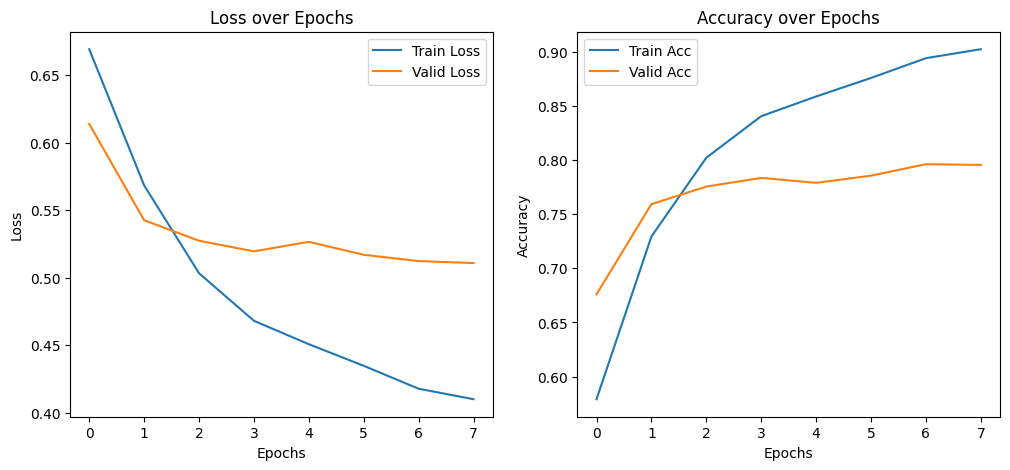

In [ ]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(len(valid_losses)), train_losses, label='Train Loss')
plt.plot(range(len(valid_losses)), valid_losses, label='Valid Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss over Epochs')

plt.subplot(1, 2, 2)
plt.plot(range(len(valid_losses)), train_accs, label='Train Acc')
plt.plot(range(len(valid_losses)), valid_accs, label='Valid Acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy over Epochs')

plt.show()

## Next default modified

In [ ]:
# Load and preprocess the dataset
path_to_dataset = "/content/drive/MyDrive/diploma/datasets/HateSpeechDatasetBalanced.csv"
df = pd.read_csv(path_to_dataset)
df = df.sample(frac=0.05, random_state=42)
df = df[['Content', 'Label']]

def preprocess(text):
    return word_tokenize(text.lower())

df['Content'] = df['Content'].apply(preprocess)

### Overwride imports

In [ ]:
middle_term_memory = None

In [ ]:
def custom_lstm_cell(input, hidden, w_ih, w_hh, b_ih, b_hh):
    global middle_term_memory

    hx, cx = hidden
    gates = torch.mm(input, w_ih.t()) + torch.mm(hx, w_hh.t()) + b_ih + b_hh

    ingate, forgetgate, cellgate, outgate = gates.chunk(4, 1)

    ingate = torch.sigmoid(ingate)
    forgetgate = torch.sigmoid(forgetgate)
    cellgate = torch.tanh(cellgate)
    outgate = torch.sigmoid(outgate)

    # Use middle-term memory if it exists
    if middle_term_memory is not None:
        # Use middle-term memory to influence the current cell state update
        cy = (forgetgate * (cx + middle_term_memory)) + (ingate * cellgate)
    else:
        cy = (forgetgate * cx) + (ingate * cellgate)

    # Update the middle-term memory
    middle_term_memory = (cy - cx) * 0.5  # Example calculation for middle-term memory

    hy = outgate * torch.tanh(cy)

    return hy, cy

In [ ]:
import math
import numbers
import warnings
import weakref
from typing import List, Optional, overload, Tuple
from typing_extensions import deprecated

import torch
from torch import _VF, Tensor
from torch.nn import init
from torch.nn.parameter import Parameter
from torch.nn.utils.rnn import PackedSequence

Module = nn.Module


__all__ = [
    "RNNBase",
    "RNN",
    "LSTM",
    "GRU",
    "RNNCellBase",
    "RNNCell",
    "LSTMCell",
    "GRUCell",
]

_rnn_impls = {
    "RNN_TANH": _VF.rnn_tanh,
    "RNN_RELU": _VF.rnn_relu,
}


def _apply_permutation(tensor: Tensor, permutation: Tensor, dim: int = 1) -> Tensor:
    return tensor.index_select(dim, permutation)


@deprecated(
    "`apply_permutation` is deprecated, please use `tensor.index_select(dim, permutation)` instead",
    category=FutureWarning,
)
def apply_permutation(tensor: Tensor, permutation: Tensor, dim: int = 1) -> Tensor:
    return _apply_permutation(tensor, permutation, dim)


class RNNBase(Module):
    __constants__ = [
        "mode",
        "input_size",
        "hidden_size",
        "num_layers",
        "bias",
        "batch_first",
        "dropout",
        "bidirectional",
        "proj_size",
    ]
    __jit_unused_properties__ = ["all_weights"]

    mode: str
    input_size: int
    hidden_size: int
    num_layers: int
    bias: bool
    batch_first: bool
    dropout: float
    bidirectional: bool
    proj_size: int

    def __init__(
        self,
        mode: str,
        input_size: int,
        hidden_size: int,
        num_layers: int = 1,
        bias: bool = True,
        batch_first: bool = False,
        dropout: float = 0.0,
        bidirectional: bool = False,
        proj_size: int = 0,
        device=None,
        dtype=None,
    ) -> None:
        factory_kwargs = {"device": device, "dtype": dtype}
        super().__init__()
        self.mode = mode
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.bias = bias
        self.batch_first = batch_first
        self.dropout = float(dropout)
        self.bidirectional = bidirectional
        self.proj_size = proj_size
        self._flat_weight_refs: List[Optional[weakref.ReferenceType[Parameter]]] = []
        num_directions = 2 if bidirectional else 1

        if (
            not isinstance(dropout, numbers.Number)
            or not 0 <= dropout <= 1
            or isinstance(dropout, bool)
        ):
            raise ValueError(
                "dropout should be a number in range [0, 1] "
                "representing the probability of an element being "
                "zeroed"
            )
        if dropout > 0 and num_layers == 1:
            warnings.warn(
                "dropout option adds dropout after all but last "
                "recurrent layer, so non-zero dropout expects "
                f"num_layers greater than 1, but got dropout={dropout} and "
                f"num_layers={num_layers}"
            )

        if not isinstance(hidden_size, int):
            raise TypeError(
                f"hidden_size should be of type int, got: {type(hidden_size).__name__}"
            )
        if hidden_size <= 0:
            raise ValueError("hidden_size must be greater than zero")
        if num_layers <= 0:
            raise ValueError("num_layers must be greater than zero")
        if proj_size < 0:
            raise ValueError(
                "proj_size should be a positive integer or zero to disable projections"
            )
        if proj_size >= hidden_size:
            raise ValueError("proj_size has to be smaller than hidden_size")

        if mode == "LSTM":
            gate_size = 4 * hidden_size
        elif mode == "GRU":
            gate_size = 3 * hidden_size
        elif mode == "RNN_TANH":
            gate_size = hidden_size
        elif mode == "RNN_RELU":
            gate_size = hidden_size
        else:
            raise ValueError("Unrecognized RNN mode: " + mode)

        self._flat_weights_names = []
        self._all_weights = []
        for layer in range(num_layers):
            for direction in range(num_directions):
                real_hidden_size = proj_size if proj_size > 0 else hidden_size
                layer_input_size = (
                    input_size if layer == 0 else real_hidden_size * num_directions
                )

                w_ih = Parameter(
                    torch.empty((gate_size, layer_input_size), **factory_kwargs)
                )
                w_hh = Parameter(
                    torch.empty((gate_size, real_hidden_size), **factory_kwargs)
                )
                b_ih = Parameter(torch.empty(gate_size, **factory_kwargs))
                # Second bias vector included for CuDNN compatibility. Only one
                # bias vector is needed in standard definition.
                b_hh = Parameter(torch.empty(gate_size, **factory_kwargs))
                layer_params: Tuple[Tensor, ...] = ()
                if self.proj_size == 0:
                    if bias:
                        layer_params = (w_ih, w_hh, b_ih, b_hh)
                    else:
                        layer_params = (w_ih, w_hh)
                else:
                    w_hr = Parameter(
                        torch.empty((proj_size, hidden_size), **factory_kwargs)
                    )
                    if bias:
                        layer_params = (w_ih, w_hh, b_ih, b_hh, w_hr)
                    else:
                        layer_params = (w_ih, w_hh, w_hr)

                suffix = "_reverse" if direction == 1 else ""
                param_names = ["weight_ih_l{}{}", "weight_hh_l{}{}"]
                if bias:
                    param_names += ["bias_ih_l{}{}", "bias_hh_l{}{}"]
                if self.proj_size > 0:
                    param_names += ["weight_hr_l{}{}"]
                param_names = [x.format(layer, suffix) for x in param_names]

                for name, param in zip(param_names, layer_params):
                    setattr(self, name, param)
                self._flat_weights_names.extend(param_names)
                self._all_weights.append(param_names)

        self._init_flat_weights()

        self.reset_parameters()

    def _init_flat_weights(self):
        self._flat_weights = [
            getattr(self, wn) if hasattr(self, wn) else None
            for wn in self._flat_weights_names
        ]
        self._flat_weight_refs = [
            weakref.ref(w) if w is not None else None for w in self._flat_weights
        ]
        self.flatten_parameters()

    def __setattr__(self, attr, value):
        if hasattr(self, "_flat_weights_names") and attr in self._flat_weights_names:
            # keep self._flat_weights up to date if you do self.weight = ...
            idx = self._flat_weights_names.index(attr)
            self._flat_weights[idx] = value
        super().__setattr__(attr, value)

    def flatten_parameters(self) -> None:
        """Reset parameter data pointer so that they can use faster code paths.

        Right now, this works only if the module is on the GPU and cuDNN is enabled.
        Otherwise, it's a no-op.
        """
        # Short-circuits if _flat_weights is only partially instantiated
        if len(self._flat_weights) != len(self._flat_weights_names):
            return

        for w in self._flat_weights:
            if not isinstance(w, Tensor):
                return
        # Short-circuits if any tensor in self._flat_weights is not acceptable to cuDNN
        # or the tensors in _flat_weights are of different dtypes

        first_fw = self._flat_weights[0]
        dtype = first_fw.dtype
        for fw in self._flat_weights:
            if (
                not isinstance(fw, Tensor)
                or not (fw.dtype == dtype)
                or not fw.is_cuda
                or not torch.backends.cudnn.is_acceptable(fw)
            ):
                return

        # If any parameters alias, we fall back to the slower, copying code path. This is
        # a sufficient check, because overlapping parameter buffers that don't completely
        # alias would break the assumptions of the uniqueness check in
        # Module.named_parameters().
        unique_data_ptrs = {p.data_ptr() for p in self._flat_weights}
        if len(unique_data_ptrs) != len(self._flat_weights):
            return

        with torch.cuda.device_of(first_fw):
            import torch.backends.cudnn.rnn as rnn

            # Note: no_grad() is necessary since _cudnn_rnn_flatten_weight is
            # an inplace operation on self._flat_weights
            with torch.no_grad():
                if torch._use_cudnn_rnn_flatten_weight():
                    num_weights = 4 if self.bias else 2
                    if self.proj_size > 0:
                        num_weights += 1
                    torch._cudnn_rnn_flatten_weight(
                        self._flat_weights,
                        num_weights,
                        self.input_size,
                        rnn.get_cudnn_mode(self.mode),
                        self.hidden_size,
                        self.proj_size,
                        self.num_layers,
                        self.batch_first,
                        bool(self.bidirectional),
                    )

    def _apply(self, fn, recurse=True):
        self._flat_weight_refs = []
        ret = super()._apply(fn, recurse)

        # Resets _flat_weights
        # Note: be v. careful before removing this, as 3rd party device types
        # likely rely on this behavior to properly .to() modules like LSTM.
        self._init_flat_weights()

        return ret

    def reset_parameters(self) -> None:
        stdv = 1.0 / math.sqrt(self.hidden_size) if self.hidden_size > 0 else 0
        for weight in self.parameters():
            init.uniform_(weight, -stdv, stdv)

    def check_input(self, input: Tensor, batch_sizes: Optional[Tensor]) -> None:
        if not torch.jit.is_scripting():
            if (
                input.dtype != self._flat_weights[0].dtype
                and not torch._C._is_any_autocast_enabled()
            ):
                raise ValueError(
                    f"input must have the type {self._flat_weights[0].dtype}, got type {input.dtype}"
                )
        expected_input_dim = 2 if batch_sizes is not None else 3
        if input.dim() != expected_input_dim:
            raise RuntimeError(
                f"input must have {expected_input_dim} dimensions, got {input.dim()}"
            )
        if self.input_size != input.size(-1):
            raise RuntimeError(
                f"input.size(-1) must be equal to input_size. Expected {self.input_size}, got {input.size(-1)}"
            )

    def get_expected_hidden_size(
        self, input: Tensor, batch_sizes: Optional[Tensor]
    ) -> Tuple[int, int, int]:
        if batch_sizes is not None:
            mini_batch = int(batch_sizes[0])
        else:
            mini_batch = input.size(0) if self.batch_first else input.size(1)
        num_directions = 2 if self.bidirectional else 1
        if self.proj_size > 0:
            expected_hidden_size = (
                self.num_layers * num_directions,
                mini_batch,
                self.proj_size,
            )
        else:
            expected_hidden_size = (
                self.num_layers * num_directions,
                mini_batch,
                self.hidden_size,
            )
        return expected_hidden_size

    def check_hidden_size(
        self,
        hx: Tensor,
        expected_hidden_size: Tuple[int, int, int],
        msg: str = "Expected hidden size {}, got {}",
    ) -> None:
        if hx.size() != expected_hidden_size:
            raise RuntimeError(msg.format(expected_hidden_size, list(hx.size())))

    def _weights_have_changed(self):
        # Returns True if the weight tensors have changed since the last forward pass.
        # This is the case when used with torch.func.functional_call(), for example.
        weights_changed = False
        for ref, name in zip(self._flat_weight_refs, self._flat_weights_names):
            weight = getattr(self, name) if hasattr(self, name) else None
            if weight is not None and ref is not None and ref() is not weight:
                weights_changed = True
                break
        return weights_changed

    def check_forward_args(
        self, input: Tensor, hidden: Tensor, batch_sizes: Optional[Tensor]
    ):
        self.check_input(input, batch_sizes)
        expected_hidden_size = self.get_expected_hidden_size(input, batch_sizes)

        self.check_hidden_size(hidden, expected_hidden_size)

    def permute_hidden(self, hx: Tensor, permutation: Optional[Tensor]):
        if permutation is None:
            return hx
        return _apply_permutation(hx, permutation)

    def extra_repr(self) -> str:
        s = "{input_size}, {hidden_size}"
        if self.proj_size != 0:
            s += ", proj_size={proj_size}"
        if self.num_layers != 1:
            s += ", num_layers={num_layers}"
        if self.bias is not True:
            s += ", bias={bias}"
        if self.batch_first is not False:
            s += ", batch_first={batch_first}"
        if self.dropout != 0:
            s += ", dropout={dropout}"
        if self.bidirectional is not False:
            s += ", bidirectional={bidirectional}"
        return s.format(**self.__dict__)

    def _update_flat_weights(self):
        if not torch.jit.is_scripting():
            if self._weights_have_changed():
                self._init_flat_weights()

    def __getstate__(self):
        # If weights have been changed, update the _flat_weights in __getstate__ here.
        self._update_flat_weights()
        # Don't serialize the weight references.
        state = self.__dict__.copy()
        del state["_flat_weight_refs"]
        return state

    def __setstate__(self, d):
        super().__setstate__(d)
        if "all_weights" in d:
            self._all_weights = d["all_weights"]
        # In PyTorch 1.8 we added a proj_size member variable to LSTM.
        # LSTMs that were serialized via torch.save(module) before PyTorch 1.8
        # don't have it, so to preserve compatibility we set proj_size here.
        if "proj_size" not in d:
            self.proj_size = 0

        if not isinstance(self._all_weights[0][0], str):
            num_layers = self.num_layers
            num_directions = 2 if self.bidirectional else 1
            self._flat_weights_names = []
            self._all_weights = []
            for layer in range(num_layers):
                for direction in range(num_directions):
                    suffix = "_reverse" if direction == 1 else ""
                    weights = [
                        "weight_ih_l{}{}",
                        "weight_hh_l{}{}",
                        "bias_ih_l{}{}",
                        "bias_hh_l{}{}",
                        "weight_hr_l{}{}",
                    ]
                    weights = [x.format(layer, suffix) for x in weights]
                    if self.bias:
                        if self.proj_size > 0:
                            self._all_weights += [weights]
                            self._flat_weights_names.extend(weights)
                        else:
                            self._all_weights += [weights[:4]]
                            self._flat_weights_names.extend(weights[:4])
                    else:
                        if self.proj_size > 0:
                            self._all_weights += [weights[:2]] + [weights[-1:]]
                            self._flat_weights_names.extend(
                                weights[:2] + [weights[-1:]]
                            )
                        else:
                            self._all_weights += [weights[:2]]
                            self._flat_weights_names.extend(weights[:2])
            self._flat_weights = [
                getattr(self, wn) if hasattr(self, wn) else None
                for wn in self._flat_weights_names
            ]

        self._flat_weight_refs = [
            weakref.ref(w) if w is not None else None for w in self._flat_weights
        ]

    @property
    def all_weights(self) -> List[List[Parameter]]:
        return [
            [getattr(self, weight) for weight in weights]
            for weights in self._all_weights
        ]

    def _replicate_for_data_parallel(self):
        replica = super()._replicate_for_data_parallel()
        # Need to copy these caches, otherwise the replica will share the same
        # flat weights list.
        replica._flat_weights = replica._flat_weights[:]
        replica._flat_weights_names = replica._flat_weights_names[:]
        return replica


class RNN(RNNBase):

    @overload
    def __init__(
        self,
        input_size: int,
        hidden_size: int,
        num_layers: int = 1,
        nonlinearity: str = "tanh",
        bias: bool = True,
        batch_first: bool = False,
        dropout: float = 0.0,
        bidirectional: bool = False,
        device=None,
        dtype=None,
    ) -> None:
        ...

    @overload
    def __init__(self, *args, **kwargs):
        ...

    def __init__(self, *args, **kwargs):
        if "proj_size" in kwargs:
            raise ValueError(
                "proj_size argument is only supported for LSTM, not RNN or GRU"
            )
        if len(args) > 3:
            self.nonlinearity = args[3]
            args = args[:3] + args[4:]
        else:
            self.nonlinearity = kwargs.pop("nonlinearity", "tanh")
        if self.nonlinearity == "tanh":
            mode = "RNN_TANH"
        elif self.nonlinearity == "relu":
            mode = "RNN_RELU"
        else:
            raise ValueError(
                f"Unknown nonlinearity '{self.nonlinearity}'. Select from 'tanh' or 'relu'."
            )
        super().__init__(mode, *args, **kwargs)

    @overload
    @torch._jit_internal._overload_method  # noqa: F811
    def forward(
        self, input: Tensor, hx: Optional[Tensor] = None
    ) -> Tuple[Tensor, Tensor]:
        pass

    @overload
    @torch._jit_internal._overload_method  # noqa: F811
    def forward(
        self, input: PackedSequence, hx: Optional[Tensor] = None
    ) -> Tuple[PackedSequence, Tensor]:
        pass

    def forward(self, input, hx=None):  # noqa: F811
        self._update_flat_weights()

        num_directions = 2 if self.bidirectional else 1
        orig_input = input

        if isinstance(orig_input, PackedSequence):
            input, batch_sizes, sorted_indices, unsorted_indices = input
            max_batch_size = batch_sizes[0]
            # script() is unhappy when max_batch_size is different type in cond branches, so we duplicate
            if hx is None:
                hx = torch.zeros(
                    self.num_layers * num_directions,
                    max_batch_size,
                    self.hidden_size,
                    dtype=input.dtype,
                    device=input.device,
                )
            else:
                # Each batch of the hidden state should match the input sequence that
                # the user believes he/she is passing in.
                hx = self.permute_hidden(hx, sorted_indices)
        else:
            batch_sizes = None
            if input.dim() not in (2, 3):
                raise ValueError(
                    f"RNN: Expected input to be 2D or 3D, got {input.dim()}D tensor instead"
                )
            is_batched = input.dim() == 3
            batch_dim = 0 if self.batch_first else 1
            if not is_batched:
                input = input.unsqueeze(batch_dim)
                if hx is not None:
                    if hx.dim() != 2:
                        raise RuntimeError(
                            f"For unbatched 2-D input, hx should also be 2-D but got {hx.dim()}-D tensor"
                        )
                    hx = hx.unsqueeze(1)
            else:
                if hx is not None and hx.dim() != 3:
                    raise RuntimeError(
                        f"For batched 3-D input, hx should also be 3-D but got {hx.dim()}-D tensor"
                    )
            max_batch_size = input.size(0) if self.batch_first else input.size(1)
            sorted_indices = None
            unsorted_indices = None
            if hx is None:
                hx = torch.zeros(
                    self.num_layers * num_directions,
                    max_batch_size,
                    self.hidden_size,
                    dtype=input.dtype,
                    device=input.device,
                )
            else:
                # Each batch of the hidden state should match the input sequence that
                # the user believes he/she is passing in.
                hx = self.permute_hidden(hx, sorted_indices)

        assert hx is not None
        self.check_forward_args(input, hx, batch_sizes)
        assert self.mode == "RNN_TANH" or self.mode == "RNN_RELU"
        if batch_sizes is None:
            if self.mode == "RNN_TANH":
                result = _VF.rnn_tanh(
                    input,
                    hx,
                    self._flat_weights,
                    self.bias,
                    self.num_layers,
                    self.dropout,
                    self.training,
                    self.bidirectional,
                    self.batch_first,
                )
            else:
                result = _VF.rnn_relu(
                    input,
                    hx,
                    self._flat_weights,
                    self.bias,
                    self.num_layers,
                    self.dropout,
                    self.training,
                    self.bidirectional,
                    self.batch_first,
                )
        else:
            if self.mode == "RNN_TANH":
                result = _VF.rnn_tanh(
                    input,
                    batch_sizes,
                    hx,
                    self._flat_weights,
                    self.bias,
                    self.num_layers,
                    self.dropout,
                    self.training,
                    self.bidirectional,
                )
            else:
                result = _VF.rnn_relu(
                    input,
                    batch_sizes,
                    hx,
                    self._flat_weights,
                    self.bias,
                    self.num_layers,
                    self.dropout,
                    self.training,
                    self.bidirectional,
                )

        output = result[0]
        hidden = result[1]

        if isinstance(orig_input, PackedSequence):
            output_packed = PackedSequence(
                output, batch_sizes, sorted_indices, unsorted_indices
            )
            return output_packed, self.permute_hidden(hidden, unsorted_indices)

        if not is_batched:  # type: ignore[possibly-undefined]
            output = output.squeeze(batch_dim)  # type: ignore[possibly-undefined]
            hidden = hidden.squeeze(1)

        return output, self.permute_hidden(hidden, unsorted_indices)


class LSTM(RNNBase):
    @overload
    def __init__(
        self,
        input_size: int,
        hidden_size: int,
        num_layers: int = 1,
        bias: bool = True,
        batch_first: bool = False,
        dropout: float = 0.0,
        bidirectional: bool = False,
        proj_size: int = 0,
        device=None,
        dtype=None,
    ) -> None:
        ...

    @overload
    def __init__(self, *args, **kwargs):
        ...

    def __init__(self, *args, **kwargs):
        super().__init__("LSTM", *args, **kwargs)

    def get_expected_cell_size(
        self, input: Tensor, batch_sizes: Optional[Tensor]
    ) -> Tuple[int, int, int]:
        if batch_sizes is not None:
            mini_batch = int(batch_sizes[0])
        else:
            mini_batch = input.size(0) if self.batch_first else input.size(1)
        num_directions = 2 if self.bidirectional else 1
        expected_hidden_size = (
            self.num_layers * num_directions,
            mini_batch,
            self.hidden_size,
        )
        return expected_hidden_size

    # In the future, we should prevent mypy from applying contravariance rules here.
    # See torch/nn/modules/module.py::_forward_unimplemented
    def check_forward_args(
        self,
        input: Tensor,
        hidden: Tuple[Tensor, Tensor],  # type: ignore[override]
        batch_sizes: Optional[Tensor],
    ):
        self.check_input(input, batch_sizes)
        self.check_hidden_size(
            hidden[0],
            self.get_expected_hidden_size(input, batch_sizes),
            "Expected hidden[0] size {}, got {}",
        )
        self.check_hidden_size(
            hidden[1],
            self.get_expected_cell_size(input, batch_sizes),
            "Expected hidden[1] size {}, got {}",
        )

    # Same as above, see torch/nn/modules/module.py::_forward_unimplemented
    def permute_hidden(  # type: ignore[override]
        self,
        hx: Tuple[Tensor, Tensor],
        permutation: Optional[Tensor],
    ) -> Tuple[Tensor, Tensor]:
        if permutation is None:
            return hx
        return _apply_permutation(hx[0], permutation), _apply_permutation(
            hx[1], permutation
        )

    # Same as above, see torch/nn/modules/module.py::_forward_unimplemented
    @overload  # type: ignore[override]
    @torch._jit_internal._overload_method  # noqa: F811
    def forward(
        self, input: Tensor, hx: Optional[Tuple[Tensor, Tensor]] = None
    ) -> Tuple[Tensor, Tuple[Tensor, Tensor]]:  # noqa: F811
        pass

    # Same as above, see torch/nn/modules/module.py::_forward_unimplemented
    @overload
    @torch._jit_internal._overload_method  # noqa: F811
    def forward(
        self, input: PackedSequence, hx: Optional[Tuple[Tensor, Tensor]] = None
    ) -> Tuple[PackedSequence, Tuple[Tensor, Tensor]]:  # noqa: F811
        pass

    def forward(self, input, hx=None):  # noqa: F811
        self._update_flat_weights()

        orig_input = input
        # xxx: isinstance check needs to be in conditional for TorchScript to compile
        batch_sizes = None
        do_permute = False
        num_directions = 2 if self.bidirectional else 1
        real_hidden_size = self.proj_size if self.proj_size > 0 else self.hidden_size
        if isinstance(orig_input, PackedSequence):
            input, batch_sizes, sorted_indices, unsorted_indices = input
            max_batch_size = batch_sizes[0]
            if hx is None:
                h_zeros = torch.zeros(
                    self.num_layers * num_directions,
                    max_batch_size,
                    real_hidden_size,
                    dtype=input.dtype,
                    device=input.device,
                )
                c_zeros = torch.zeros(
                    self.num_layers * num_directions,
                    max_batch_size,
                    self.hidden_size,
                    dtype=input.dtype,
                    device=input.device,
                )
                hx = (h_zeros, c_zeros)
            else:
                # Each batch of the hidden state should match the input sequence that
                # the user believes he/she is passing in.
                hx = self.permute_hidden(hx, sorted_indices)
        else:
            if input.dim() not in (2, 3):
                raise ValueError(
                    f"LSTM: Expected input to be 2D or 3D, got {input.dim()}D instead"
                )
            is_batched = input.dim() == 3
            batch_dim = 0 if self.batch_first else 1
            if not is_batched:
                input = input.unsqueeze(batch_dim)
            max_batch_size = input.size(0) if self.batch_first else input.size(1)
            sorted_indices = None
            unsorted_indices = None
            if hx is None:
                h_zeros = torch.zeros(
                    self.num_layers * num_directions,
                    max_batch_size,
                    real_hidden_size,
                    dtype=input.dtype,
                    device=input.device,
                )
                c_zeros = torch.zeros(
                    self.num_layers * num_directions,
                    max_batch_size,
                    self.hidden_size,
                    dtype=input.dtype,
                    device=input.device,
                )
                hx = (h_zeros, c_zeros)
                self.check_forward_args(input, hx, batch_sizes)
            else:
                if is_batched:
                    if hx[0].dim() != 3 or hx[1].dim() != 3:
                        msg = (
                            "For batched 3-D input, hx and cx should "
                            f"also be 3-D but got ({hx[0].dim()}-D, {hx[1].dim()}-D) tensors"
                        )
                        raise RuntimeError(msg)
                else:
                    if hx[0].dim() != 2 or hx[1].dim() != 2:
                        msg = (
                            "For unbatched 2-D input, hx and cx should "
                            f"also be 2-D but got ({hx[0].dim()}-D, {hx[1].dim()}-D) tensors"
                        )
                        raise RuntimeError(msg)
                    hx = (hx[0].unsqueeze(1), hx[1].unsqueeze(1))
                # Each batch of the hidden state should match the input sequence that
                # the user believes he/she is passing in.
                self.check_forward_args(input, hx, batch_sizes)
                hx = self.permute_hidden(hx, sorted_indices)

        if batch_sizes is None:
            result = _VF.lstm(
                input,
                hx,
                self._flat_weights,
                self.bias,
                self.num_layers,
                self.dropout,
                self.training,
                self.bidirectional,
                self.batch_first,
            )
        else:
            result = _VF.lstm(
                input,
                batch_sizes,
                hx,
                self._flat_weights,
                self.bias,
                self.num_layers,
                self.dropout,
                self.training,
                self.bidirectional,
            )
        output = result[0]
        hidden = result[1:]
        # xxx: isinstance check needs to be in conditional for TorchScript to compile
        if isinstance(orig_input, PackedSequence):
            output_packed = PackedSequence(
                output, batch_sizes, sorted_indices, unsorted_indices
            )
            return output_packed, self.permute_hidden(hidden, unsorted_indices)
        else:
            if not is_batched:  # type: ignore[possibly-undefined]
                output = output.squeeze(batch_dim)  # type: ignore[possibly-undefined]
                hidden = (hidden[0].squeeze(1), hidden[1].squeeze(1))
            return output, self.permute_hidden(hidden, unsorted_indices)


class GRU(RNNBase):
    @overload
    def __init__(
        self,
        input_size: int,
        hidden_size: int,
        num_layers: int = 1,
        bias: bool = True,
        batch_first: bool = False,
        dropout: float = 0.0,
        bidirectional: bool = False,
        device=None,
        dtype=None,
    ) -> None:
        ...

    @overload
    def __init__(self, *args, **kwargs):
        ...

    def __init__(self, *args, **kwargs):
        if "proj_size" in kwargs:
            raise ValueError(
                "proj_size argument is only supported for LSTM, not RNN or GRU"
            )
        super().__init__("GRU", *args, **kwargs)

    @overload  # type: ignore[override]
    @torch._jit_internal._overload_method  # noqa: F811
    def forward(
        self, input: Tensor, hx: Optional[Tensor] = None
    ) -> Tuple[Tensor, Tensor]:  # noqa: F811
        pass

    @overload
    @torch._jit_internal._overload_method  # noqa: F811
    def forward(
        self, input: PackedSequence, hx: Optional[Tensor] = None
    ) -> Tuple[PackedSequence, Tensor]:  # noqa: F811
        pass

    def forward(self, input, hx=None):  # noqa: F811
        self._update_flat_weights()

        orig_input = input
        # xxx: isinstance check needs to be in conditional for TorchScript to compile
        if isinstance(orig_input, PackedSequence):
            input, batch_sizes, sorted_indices, unsorted_indices = input
            max_batch_size = batch_sizes[0]
            if hx is None:
                num_directions = 2 if self.bidirectional else 1
                hx = torch.zeros(
                    self.num_layers * num_directions,
                    max_batch_size,
                    self.hidden_size,
                    dtype=input.dtype,
                    device=input.device,
                )
            else:
                # Each batch of the hidden state should match the input sequence that
                # the user believes he/she is passing in.
                hx = self.permute_hidden(hx, sorted_indices)
        else:
            batch_sizes = None
            if input.dim() not in (2, 3):
                raise ValueError(
                    f"GRU: Expected input to be 2D or 3D, got {input.dim()}D instead"
                )
            is_batched = input.dim() == 3
            batch_dim = 0 if self.batch_first else 1
            if not is_batched:
                input = input.unsqueeze(batch_dim)
                if hx is not None:
                    if hx.dim() != 2:
                        raise RuntimeError(
                            f"For unbatched 2-D input, hx should also be 2-D but got {hx.dim()}-D tensor"
                        )
                    hx = hx.unsqueeze(1)
            else:
                if hx is not None and hx.dim() != 3:
                    raise RuntimeError(
                        f"For batched 3-D input, hx should also be 3-D but got {hx.dim()}-D tensor"
                    )
            max_batch_size = input.size(0) if self.batch_first else input.size(1)
            sorted_indices = None
            unsorted_indices = None
            if hx is None:
                num_directions = 2 if self.bidirectional else 1
                hx = torch.zeros(
                    self.num_layers * num_directions,
                    max_batch_size,
                    self.hidden_size,
                    dtype=input.dtype,
                    device=input.device,
                )
            else:
                # Each batch of the hidden state should match the input sequence that
                # the user believes he/she is passing in.
                hx = self.permute_hidden(hx, sorted_indices)

        self.check_forward_args(input, hx, batch_sizes)
        if batch_sizes is None:
            result = _VF.gru(
                input,
                hx,
                self._flat_weights,
                self.bias,
                self.num_layers,
                self.dropout,
                self.training,
                self.bidirectional,
                self.batch_first,
            )
        else:
            result = _VF.gru(
                input,
                batch_sizes,
                hx,
                self._flat_weights,
                self.bias,
                self.num_layers,
                self.dropout,
                self.training,
                self.bidirectional,
            )
        output = result[0]
        hidden = result[1]

        # xxx: isinstance check needs to be in conditional for TorchScript to compile
        if isinstance(orig_input, PackedSequence):
            output_packed = PackedSequence(
                output, batch_sizes, sorted_indices, unsorted_indices
            )
            return output_packed, self.permute_hidden(hidden, unsorted_indices)
        else:
            if not is_batched:  # type: ignore[possibly-undefined]
                output = output.squeeze(batch_dim)  # type: ignore[possibly-undefined]
                hidden = hidden.squeeze(1)

            return output, self.permute_hidden(hidden, unsorted_indices)


class RNNCellBase(Module):
    __constants__ = ["input_size", "hidden_size", "bias"]

    input_size: int
    hidden_size: int
    bias: bool
    weight_ih: Tensor
    weight_hh: Tensor
    # WARNING: bias_ih and bias_hh purposely not defined here.
    # See https://github.com/pytorch/pytorch/issues/39670

    def __init__(
        self,
        input_size: int,
        hidden_size: int,
        bias: bool,
        num_chunks: int,
        device=None,
        dtype=None,
    ) -> None:
        factory_kwargs = {"device": device, "dtype": dtype}
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.bias = bias
        self.weight_ih = Parameter(
            torch.empty((num_chunks * hidden_size, input_size), **factory_kwargs)
        )
        self.weight_hh = Parameter(
            torch.empty((num_chunks * hidden_size, hidden_size), **factory_kwargs)
        )
        if bias:
            self.bias_ih = Parameter(
                torch.empty(num_chunks * hidden_size, **factory_kwargs)
            )
            self.bias_hh = Parameter(
                torch.empty(num_chunks * hidden_size, **factory_kwargs)
            )
        else:
            self.register_parameter("bias_ih", None)
            self.register_parameter("bias_hh", None)

        self.reset_parameters()

    def extra_repr(self) -> str:
        s = "{input_size}, {hidden_size}"
        if "bias" in self.__dict__ and self.bias is not True:
            s += ", bias={bias}"
        if "nonlinearity" in self.__dict__ and self.nonlinearity != "tanh":
            s += ", nonlinearity={nonlinearity}"
        return s.format(**self.__dict__)

    def reset_parameters(self) -> None:
        stdv = 1.0 / math.sqrt(self.hidden_size) if self.hidden_size > 0 else 0
        for weight in self.parameters():
            init.uniform_(weight, -stdv, stdv)


class RNNCell(RNNCellBase):
    __constants__ = ["input_size", "hidden_size", "bias", "nonlinearity"]
    nonlinearity: str

    def __init__(
        self,
        input_size: int,
        hidden_size: int,
        bias: bool = True,
        nonlinearity: str = "tanh",
        device=None,
        dtype=None,
    ) -> None:
        factory_kwargs = {"device": device, "dtype": dtype}
        super().__init__(input_size, hidden_size, bias, num_chunks=1, **factory_kwargs)
        self.nonlinearity = nonlinearity

    def forward(self, input: Tensor, hx: Optional[Tensor] = None) -> Tensor:
        if input.dim() not in (1, 2):
            raise ValueError(
                f"RNNCell: Expected input to be 1D or 2D, got {input.dim()}D instead"
            )
        if hx is not None and hx.dim() not in (1, 2):
            raise ValueError(
                f"RNNCell: Expected hidden to be 1D or 2D, got {hx.dim()}D instead"
            )
        is_batched = input.dim() == 2
        if not is_batched:
            input = input.unsqueeze(0)

        if hx is None:
            hx = torch.zeros(
                input.size(0), self.hidden_size, dtype=input.dtype, device=input.device
            )
        else:
            hx = hx.unsqueeze(0) if not is_batched else hx

        if self.nonlinearity == "tanh":
            ret = _VF.rnn_tanh_cell(
                input,
                hx,
                self.weight_ih,
                self.weight_hh,
                self.bias_ih,
                self.bias_hh,
            )
        elif self.nonlinearity == "relu":
            ret = _VF.rnn_relu_cell(
                input,
                hx,
                self.weight_ih,
                self.weight_hh,
                self.bias_ih,
                self.bias_hh,
            )
        else:
            ret = input  # TODO: remove when jit supports exception flow
            raise RuntimeError(f"Unknown nonlinearity: {self.nonlinearity}")

        if not is_batched:
            ret = ret.squeeze(0)

        return ret


class LSTMCell(RNNCellBase):
    def __init__(
        self,
        input_size: int,
        hidden_size: int,
        bias: bool = True,
        device=None,
        dtype=None,
    ) -> None:
        factory_kwargs = {"device": device, "dtype": dtype}
        super().__init__(input_size, hidden_size, bias, num_chunks=4, **factory_kwargs)

    def forward(
        self, input: Tensor, hx: Optional[Tuple[Tensor, Tensor]] = None
    ) -> Tuple[Tensor, Tensor]:
        if input.dim() not in (1, 2):
            raise ValueError(
                f"LSTMCell: Expected input to be 1D or 2D, got {input.dim()}D instead"
            )
        if hx is not None:
            for idx, value in enumerate(hx):
                if value.dim() not in (1, 2):
                    raise ValueError(
                        f"LSTMCell: Expected hx[{idx}] to be 1D or 2D, got {value.dim()}D instead"
                    )
        is_batched = input.dim() == 2
        if not is_batched:
            input = input.unsqueeze(0)

        if hx is None:
            zeros = torch.zeros(
                input.size(0), self.hidden_size, dtype=input.dtype, device=input.device
            )
            hx = (zeros, zeros)
        else:
            hx = (hx[0].unsqueeze(0), hx[1].unsqueeze(0)) if not is_batched else hx

        ret = custom_lstm_cell(
            input,
            hx,
            self.weight_ih,
            self.weight_hh,
            self.bias_ih,
            self.bias_hh,
        )

        if not is_batched:
            ret = (ret[0].squeeze(0), ret[1].squeeze(0))
        return ret


class GRUCell(RNNCellBase):
    def __init__(
        self,
        input_size: int,
        hidden_size: int,
        bias: bool = True,
        device=None,
        dtype=None,
    ) -> None:
        factory_kwargs = {"device": device, "dtype": dtype}
        super().__init__(input_size, hidden_size, bias, num_chunks=3, **factory_kwargs)

    def forward(self, input: Tensor, hx: Optional[Tensor] = None) -> Tensor:
        if input.dim() not in (1, 2):
            raise ValueError(
                f"GRUCell: Expected input to be 1D or 2D, got {input.dim()}D instead"
            )
        if hx is not None and hx.dim() not in (1, 2):
            raise ValueError(
                f"GRUCell: Expected hidden to be 1D or 2D, got {hx.dim()}D instead"
            )
        is_batched = input.dim() == 2
        if not is_batched:
            input = input.unsqueeze(0)

        if hx is None:
            hx = torch.zeros(
                input.size(0), self.hidden_size, dtype=input.dtype, device=input.device
            )
        else:
            hx = hx.unsqueeze(0) if not is_batched else hx

        ret = _VF.gru_cell(
            input,
            hx,
            self.weight_ih,
            self.weight_hh,
            self.bias_ih,
            self.bias_hh,
        )

        if not is_batched:
            ret = ret.squeeze(0)

        return ret

### Go to do

In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score
from nltk.tokenize import word_tokenize
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Define EarlyStopping class
class EarlyStopping:
    def __init__(self, patience=3, delta=0.01):
        self.patience = patience
        self.delta = delta
        self.best_loss = float('inf')
        self.counter = 0
        self.stop_training = False

    def __call__(self, val_loss):
        if val_loss < self.best_loss - self.delta:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.stop_training = True

# Split the dataset into training and testing sets
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

# Build vocabulary
all_words = [word for tweet in train_df['Content'] for word in tweet]
vocab = sorted(set(all_words))
word_to_idx = {word: idx+1 for idx, word in enumerate(vocab)}
vocab_size = len(vocab) + 1  # +1 for padding index

# Encode tweets
def encode_tweet(tweet):
    return [word_to_idx[word] for word in tweet if word in word_to_idx]

train_df['Content'] = train_df['Content'].apply(encode_tweet)
test_df['Content'] = test_df['Content'].apply(encode_tweet)

# Pad sequences
def pad_sequences(sequences, max_len):
    return np.array([seq + [0]*(max_len-len(seq)) if len(seq) < max_len else seq[:max_len] for seq in sequences])

MAX_LEN = 100
X_train = pad_sequences(train_df['Content'], MAX_LEN)
X_test = pad_sequences(test_df['Content'], MAX_LEN)

# Encode labels
le = LabelEncoder()
y_train = le.fit_transform(train_df['Label'])
y_test = le.transform(test_df['Label'])

# Create Dataset and DataLoader
class HateSpeechDataset(Dataset):
    def __init__(self, tweets, labels):
        self.tweets = tweets
        self.labels = labels

    def __len__(self):
        return len(self.tweets)

    def __getitem__(self, idx):
        return torch.tensor(self.tweets[idx]), torch.tensor(self.labels[idx])

train_dataset = HateSpeechDataset(X_train, y_train)
test_dataset = HateSpeechDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64)

# Define the LSTM model with dropout
class LSTMClassifier(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_size, output_size, num_layers=1, dropout=0.5):
        super(LSTMClassifier, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.lstm = LSTM(embed_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size, output_size)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.embedding(x)
        h0 = torch.zeros(self.lstm.num_layers, x.size(0), self.lstm.hidden_size).to(x.device)
        c0 = torch.zeros(self.lstm.num_layers, x.size(0), self.lstm.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return self.softmax(out)

# Initialize model, optimizer, and criterion
embed_size = 100
hidden_size = 128
output_size = len(np.unique(y_train))
num_layers = 1
dropout = 0.5

model = LSTMClassifier(vocab_size, embed_size, hidden_size, output_size, num_layers, dropout)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
scheduler = ReduceLROnPlateau(optimizer, 'min', patience=2, factor=0.5)
early_stopping = EarlyStopping(patience=3, delta=0.01)

# Training and evaluation functions
def train(model, data_loader, optimizer, criterion):
    model.train()
    running_loss = 0.0
    correct_preds = 0
    total_preds = 0

    for tweets, labels in tqdm(data_loader, desc='Training'):
        optimizer.zero_grad()
        outputs = model(tweets)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * tweets.size(0)
        _, predicted = torch.max(outputs, 1)
        correct_preds += (predicted == labels).sum().item()
        total_preds += labels.size(0)

    avg_loss = running_loss / len(data_loader.dataset)
    accuracy = correct_preds / total_preds
    return avg_loss, accuracy

def evaluate(model, data_loader, criterion):
    model.eval()
    running_loss = 0.0
    correct_preds = 0
    total_preds = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for tweets, labels in tqdm(data_loader, desc='Evaluating'):
            outputs = model(tweets)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * tweets.size(0)
            _, predicted = torch.max(outputs, 1)
            correct_preds += (predicted == labels).sum().item()
            total_preds += labels.size(0)

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    avg_loss = running_loss / len(data_loader.dataset)
    accuracy = correct_preds / total_preds
    f1 = f1_score(all_labels, all_preds, average='weighted')  # or 'micro', 'macro'
    return avg_loss, accuracy, f1

<ipython-input-22-97dbe830f6b0>:121: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn(


In [ ]:
# Training loop
N_EPOCHS = 10
train_losses = []
valid_losses = []
train_accs = []
valid_accs = []
valid_f1s = []

for epoch in range(N_EPOCHS):
    train_loss, train_acc = train(model, train_loader, optimizer, criterion)
    valid_loss, valid_acc, valid_f1 = evaluate(model, test_loader, criterion)

    scheduler.step(valid_loss)  # Step scheduler based on validation loss
    early_stopping(valid_loss)
    if early_stopping.stop_training:
        print("Early stopping triggered")
        break

    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    train_accs.append(train_acc)
    valid_accs.append(valid_acc)
    valid_f1s.append(valid_f1)

    print(f'Epoch: {epoch+1}')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}% | Val. F1: {valid_f1:.2f}')

Evaluating: 100%|██████████| 114/114 [00:01<00:00, 111.29it/s]


Epoch: 1
	Train Loss: 0.669 | Train Acc: 57.92%
	 Val. Loss: 0.614 |  Val. Acc: 67.60% | Val. F1: 0.68


Evaluating: 100%|██████████| 114/114 [00:00<00:00, 114.97it/s]


Epoch: 2
	Train Loss: 0.568 | Train Acc: 72.93%
	 Val. Loss: 0.543 |  Val. Acc: 75.92% | Val. F1: 0.76


Evaluating: 100%|██████████| 114/114 [00:01<00:00, 111.11it/s]


Epoch: 3
	Train Loss: 0.503 | Train Acc: 80.20%
	 Val. Loss: 0.527 |  Val. Acc: 77.54% | Val. F1: 0.77


Evaluating: 100%|██████████| 114/114 [00:00<00:00, 117.22it/s]


Epoch: 4
	Train Loss: 0.468 | Train Acc: 84.03%
	 Val. Loss: 0.520 |  Val. Acc: 78.34% | Val. F1: 0.78


Evaluating: 100%|██████████| 114/114 [00:00<00:00, 117.78it/s]


Epoch: 5
	Train Loss: 0.451 | Train Acc: 85.85%
	 Val. Loss: 0.527 |  Val. Acc: 77.88% | Val. F1: 0.78


Evaluating: 100%|██████████| 114/114 [00:00<00:00, 116.93it/s]


Epoch: 6
	Train Loss: 0.435 | Train Acc: 87.56%
	 Val. Loss: 0.517 |  Val. Acc: 78.55% | Val. F1: 0.79


Evaluating: 100%|██████████| 114/114 [00:00<00:00, 115.75it/s]


Epoch: 7
	Train Loss: 0.418 | Train Acc: 89.39%
	 Val. Loss: 0.512 |  Val. Acc: 79.61% | Val. F1: 0.80


Evaluating: 100%|██████████| 114/114 [00:01<00:00, 108.37it/s]


Epoch: 8
	Train Loss: 0.410 | Train Acc: 90.21%
	 Val. Loss: 0.511 |  Val. Acc: 79.54% | Val. F1: 0.80


Evaluating: 100%|██████████| 114/114 [00:00<00:00, 115.95it/s]

Early stopping triggered


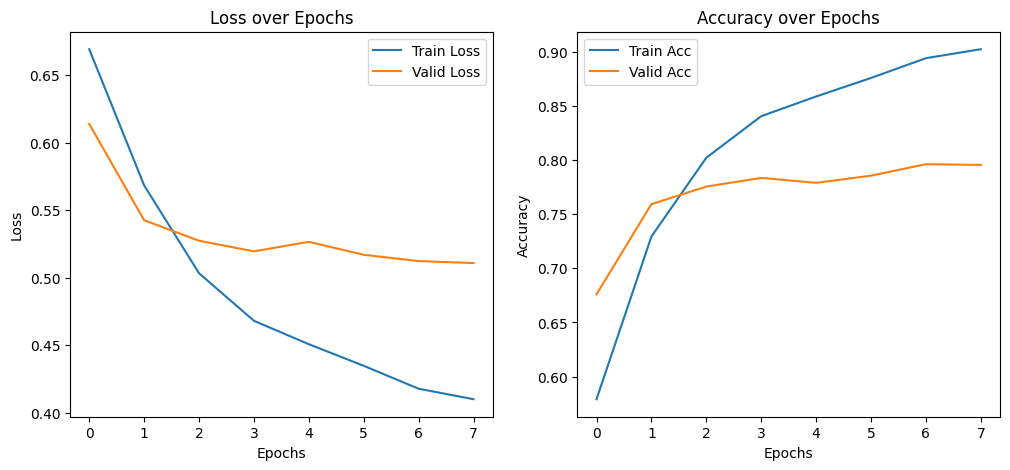

In [ ]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(len(valid_losses)), train_losses, label='Train Loss')
plt.plot(range(len(valid_losses)), valid_losses, label='Valid Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss over Epochs')

plt.subplot(1, 2, 2)
plt.plot(range(len(valid_losses)), train_accs, label='Train Acc')
plt.plot(range(len(valid_losses)), valid_accs, label='Valid Acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy over Epochs')

plt.show()

## Next LSTM CELL Default

In [ ]:
# Load and preprocess the dataset
path_to_dataset = "/content/drive/MyDrive/diploma/datasets/HateSpeechDatasetBalanced.csv"
df = pd.read_csv(path_to_dataset)
df = df.sample(frac=0.05, random_state=42)
df = df[['Content', 'Label']]

def preprocess(text):
    return word_tokenize(text.lower())

df['Content'] = df['Content'].apply(preprocess)

In [ ]:
# Split the dataset into training and testing sets
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

# Build vocabulary
all_words = [word for tweet in train_df['Content'] for word in tweet]
vocab = sorted(set(all_words))
word_to_idx = {word: idx+1 for idx, word in enumerate(vocab)}
vocab_size = len(vocab) + 1  # +1 for padding index

# Encode tweets
def encode_tweet(tweet):
    return [word_to_idx[word] for word in tweet if word in word_to_idx]

train_df['Content'] = train_df['Content'].apply(encode_tweet)
test_df['Content'] = test_df['Content'].apply(encode_tweet)

# Pad sequences
def pad_sequences(sequences, max_len):
    return np.array([seq + [0]*(max_len-len(seq)) if len(seq) < max_len else seq[:max_len] for seq in sequences])

MAX_LEN = 100
X_train = pad_sequences(train_df['Content'], MAX_LEN)
X_test = pad_sequences(test_df['Content'], MAX_LEN)

# Encode labels
le = LabelEncoder()
y_train = le.fit_transform(train_df['Label'])
y_test = le.transform(test_df['Label'])

# Create Dataset and DataLoader
class HateSpeechDataset(Dataset):
    def __init__(self, tweets, labels):
        self.tweets = tweets
        self.labels = labels

    def __len__(self):
        return len(self.tweets)

    def __getitem__(self, idx):
        return torch.tensor(self.tweets[idx]), torch.tensor(self.labels[idx])

train_dataset = HateSpeechDataset(X_train, y_train)
test_dataset = HateSpeechDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64)

# Define the LSTM model using nn.LSTMCell
class LSTMModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim):
        super(LSTMModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm_cell = nn.LSTMCell(embedding_dim, hidden_dim)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.hidden_dim = hidden_dim

    def forward(self, x):
        batch_size, seq_len = x.size()
        embedded = self.embedding(x)  # [batch_size, sequence_length, embedding_dim]

        h_t = torch.zeros(batch_size, self.hidden_dim, device=x.device)  # Hidden state
        c_t = torch.zeros(batch_size, self.hidden_dim, device=x.device)  # Cell state

        for t in range(seq_len):
            h_t, c_t = self.lstm_cell(embedded[:, t, :], (h_t, c_t))

        out = self.fc(h_t)  # Output from the last hidden state
        return out

# Hyperparameters
embedding_dim = 100
hidden_dim = 128
output_dim = 2  # Number of classes
learning_rate = 0.001

# Initialize the model, loss function, and optimizer
model = LSTMModel(vocab_size, embedding_dim, hidden_dim, output_dim)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training function
def train(model, dataloader, optimizer, criterion):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    for inputs, labels in tqdm(dataloader, desc="Training", leave=False):
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    avg_loss = total_loss / len(dataloader)
    accuracy = correct / total
    return avg_loss, accuracy

# Evaluation function
def evaluate(model, dataloader, criterion):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in tqdm(dataloader, desc="Evaluating", leave=False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    avg_loss = total_loss / len(dataloader)
    accuracy = correct / total
    return avg_loss, accuracy

In [ ]:
# Train the model
N_EPOCHS = 5
train_losses = []
valid_losses = []
train_accs = []
valid_accs = []

for epoch in range(N_EPOCHS):
    print(f'\nEpoch: {epoch+1}')
    train_loss, train_acc = train(model, train_loader, optimizer, criterion)
    valid_loss, valid_acc = evaluate(model, test_loader, criterion)

    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    train_accs.append(train_acc)
    valid_accs.append(valid_acc)

    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')


Epoch: 1


	Train Loss: 0.668 | Train Acc: 57.68%
	 Val. Loss: 0.587 |  Val. Acc: 69.73%

Epoch: 2


	Train Loss: 0.504 | Train Acc: 75.47%
	 Val. Loss: 0.483 |  Val. Acc: 76.74%

Epoch: 3


	Train Loss: 0.390 | Train Acc: 82.71%
	 Val. Loss: 0.450 |  Val. Acc: 79.92%

Epoch: 4


	Train Loss: 0.309 | Train Acc: 87.27%
	 Val. Loss: 0.458 |  Val. Acc: 80.90%

Epoch: 5


	Train Loss: 0.242 | Train Acc: 90.55%
	 Val. Loss: 0.481 |  Val. Acc: 80.85%


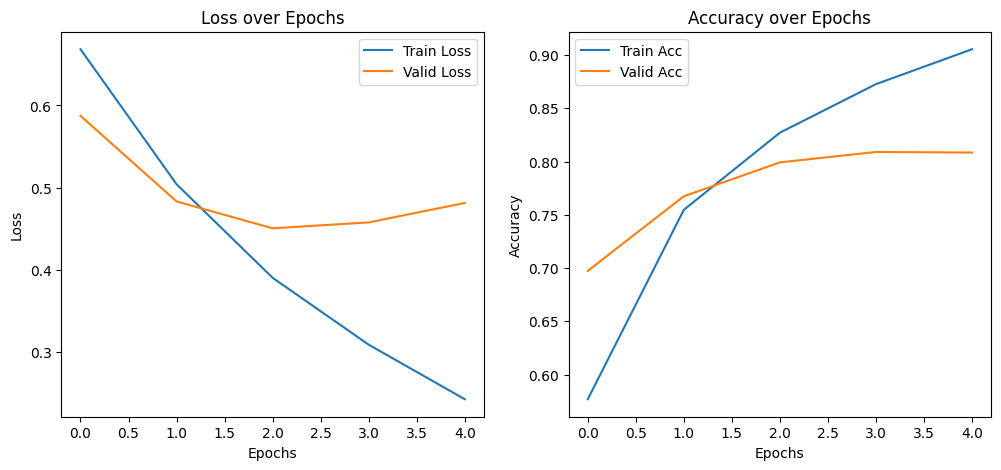

In [ ]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(len(valid_losses)), train_losses, label='Train Loss')
plt.plot(range(len(valid_losses)), valid_losses, label='Valid Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss over Epochs')

plt.subplot(1, 2, 2)
plt.plot(range(len(valid_losses)), train_accs, label='Train Acc')
plt.plot(range(len(valid_losses)), valid_accs, label='Valid Acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy over Epochs')

plt.show()

## Next LSTM CELL Default Case Owervroden

In [4]:
# Load and preprocess the dataset
path_to_dataset = "/content/drive/MyDrive/diploma/datasets/HateSpeechDatasetBalanced.csv"
df = pd.read_csv(path_to_dataset)
df = df.sample(frac=0.05, random_state=42)
df = df[['Content', 'Label']]

def preprocess(text):
    return word_tokenize(text.lower())

df['Content'] = df['Content'].apply(preprocess)

### Overwride imports

In [6]:
def custom_lstm_cell(input, hidden, w_ih, w_hh, b_ih, b_hh):
    # type: (Tensor, Tuple[Tensor, Tensor], Tensor, Tensor, Tensor, Tensor) -> Tuple[Tensor, Tensor]
    hx, cx = hidden
    gates = torch.mm(input, w_ih.t()) + torch.mm(hx, w_hh.t()) + b_ih + b_hh

    ingate, forgetgate, cellgate, outgate = gates.chunk(4, 1)

    ingate = torch.sigmoid(ingate)
    forgetgate = torch.sigmoid(forgetgate)
    cellgate = torch.tanh(cellgate)
    outgate = torch.sigmoid(outgate)

    cy = (forgetgate * cx) + (ingate * cellgate)
    hy = outgate * torch.tanh(cy)
    # print("EEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEE")

    return hy, cy

###### To

In [7]:
import math
import numbers
import warnings
import weakref
from typing import List, Optional, overload, Tuple
from typing_extensions import deprecated

import torch
from torch import _VF, Tensor
from torch.nn import init
from torch.nn.parameter import Parameter
from torch.nn.utils.rnn import PackedSequence

Module = nn.Module


__all__ = [
    "RNNBase",
    "RNN",
    "LSTM",
    "GRU",
    "RNNCellBase",
    "RNNCell",
    "LSTMCell",
    "GRUCell",
]

_rnn_impls = {
    "RNN_TANH": _VF.rnn_tanh,
    "RNN_RELU": _VF.rnn_relu,
}


def _apply_permutation(tensor: Tensor, permutation: Tensor, dim: int = 1) -> Tensor:
    return tensor.index_select(dim, permutation)


@deprecated(
    "`apply_permutation` is deprecated, please use `tensor.index_select(dim, permutation)` instead",
    category=FutureWarning,
)
def apply_permutation(tensor: Tensor, permutation: Tensor, dim: int = 1) -> Tensor:
    return _apply_permutation(tensor, permutation, dim)


class RNNBase(Module):
    r"""Base class for RNN modules (RNN, LSTM, GRU).

    Implements aspects of RNNs shared by the RNN, LSTM, and GRU classes, such as module initialization
    and utility methods for parameter storage management.

    .. note::
        The forward method is not implemented by the RNNBase class.

    .. note::
        LSTM and GRU classes override some methods implemented by RNNBase.
    """

    __constants__ = [
        "mode",
        "input_size",
        "hidden_size",
        "num_layers",
        "bias",
        "batch_first",
        "dropout",
        "bidirectional",
        "proj_size",
    ]
    __jit_unused_properties__ = ["all_weights"]

    mode: str
    input_size: int
    hidden_size: int
    num_layers: int
    bias: bool
    batch_first: bool
    dropout: float
    bidirectional: bool
    proj_size: int

    def __init__(
        self,
        mode: str,
        input_size: int,
        hidden_size: int,
        num_layers: int = 1,
        bias: bool = True,
        batch_first: bool = False,
        dropout: float = 0.0,
        bidirectional: bool = False,
        proj_size: int = 0,
        device=None,
        dtype=None,
    ) -> None:
        factory_kwargs = {"device": device, "dtype": dtype}
        super().__init__()
        self.mode = mode
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.bias = bias
        self.batch_first = batch_first
        self.dropout = float(dropout)
        self.bidirectional = bidirectional
        self.proj_size = proj_size
        self._flat_weight_refs: List[Optional[weakref.ReferenceType[Parameter]]] = []
        num_directions = 2 if bidirectional else 1

        if (
            not isinstance(dropout, numbers.Number)
            or not 0 <= dropout <= 1
            or isinstance(dropout, bool)
        ):
            raise ValueError(
                "dropout should be a number in range [0, 1] "
                "representing the probability of an element being "
                "zeroed"
            )
        if dropout > 0 and num_layers == 1:
            warnings.warn(
                "dropout option adds dropout after all but last "
                "recurrent layer, so non-zero dropout expects "
                f"num_layers greater than 1, but got dropout={dropout} and "
                f"num_layers={num_layers}"
            )

        if not isinstance(hidden_size, int):
            raise TypeError(
                f"hidden_size should be of type int, got: {type(hidden_size).__name__}"
            )
        if hidden_size <= 0:
            raise ValueError("hidden_size must be greater than zero")
        if num_layers <= 0:
            raise ValueError("num_layers must be greater than zero")
        if proj_size < 0:
            raise ValueError(
                "proj_size should be a positive integer or zero to disable projections"
            )
        if proj_size >= hidden_size:
            raise ValueError("proj_size has to be smaller than hidden_size")

        if mode == "LSTM":
            gate_size = 4 * hidden_size
        elif mode == "GRU":
            gate_size = 3 * hidden_size
        elif mode == "RNN_TANH":
            gate_size = hidden_size
        elif mode == "RNN_RELU":
            gate_size = hidden_size
        else:
            raise ValueError("Unrecognized RNN mode: " + mode)

        self._flat_weights_names = []
        self._all_weights = []
        for layer in range(num_layers):
            for direction in range(num_directions):
                real_hidden_size = proj_size if proj_size > 0 else hidden_size
                layer_input_size = (
                    input_size if layer == 0 else real_hidden_size * num_directions
                )

                w_ih = Parameter(
                    torch.empty((gate_size, layer_input_size), **factory_kwargs)
                )
                w_hh = Parameter(
                    torch.empty((gate_size, real_hidden_size), **factory_kwargs)
                )
                b_ih = Parameter(torch.empty(gate_size, **factory_kwargs))
                # Second bias vector included for CuDNN compatibility. Only one
                # bias vector is needed in standard definition.
                b_hh = Parameter(torch.empty(gate_size, **factory_kwargs))
                layer_params: Tuple[Tensor, ...] = ()
                if self.proj_size == 0:
                    if bias:
                        layer_params = (w_ih, w_hh, b_ih, b_hh)
                    else:
                        layer_params = (w_ih, w_hh)
                else:
                    w_hr = Parameter(
                        torch.empty((proj_size, hidden_size), **factory_kwargs)
                    )
                    if bias:
                        layer_params = (w_ih, w_hh, b_ih, b_hh, w_hr)
                    else:
                        layer_params = (w_ih, w_hh, w_hr)

                suffix = "_reverse" if direction == 1 else ""
                param_names = ["weight_ih_l{}{}", "weight_hh_l{}{}"]
                if bias:
                    param_names += ["bias_ih_l{}{}", "bias_hh_l{}{}"]
                if self.proj_size > 0:
                    param_names += ["weight_hr_l{}{}"]
                param_names = [x.format(layer, suffix) for x in param_names]

                for name, param in zip(param_names, layer_params):
                    setattr(self, name, param)
                self._flat_weights_names.extend(param_names)
                self._all_weights.append(param_names)

        self._init_flat_weights()

        self.reset_parameters()

    def _init_flat_weights(self):
        self._flat_weights = [
            getattr(self, wn) if hasattr(self, wn) else None
            for wn in self._flat_weights_names
        ]
        self._flat_weight_refs = [
            weakref.ref(w) if w is not None else None for w in self._flat_weights
        ]
        self.flatten_parameters()

    def __setattr__(self, attr, value):
        if hasattr(self, "_flat_weights_names") and attr in self._flat_weights_names:
            # keep self._flat_weights up to date if you do self.weight = ...
            idx = self._flat_weights_names.index(attr)
            self._flat_weights[idx] = value
        super().__setattr__(attr, value)

    def flatten_parameters(self) -> None:
        """Reset parameter data pointer so that they can use faster code paths.

        Right now, this works only if the module is on the GPU and cuDNN is enabled.
        Otherwise, it's a no-op.
        """
        # Short-circuits if _flat_weights is only partially instantiated
        if len(self._flat_weights) != len(self._flat_weights_names):
            return

        for w in self._flat_weights:
            if not isinstance(w, Tensor):
                return
        # Short-circuits if any tensor in self._flat_weights is not acceptable to cuDNN
        # or the tensors in _flat_weights are of different dtypes

        first_fw = self._flat_weights[0]
        dtype = first_fw.dtype
        for fw in self._flat_weights:
            if (
                not isinstance(fw, Tensor)
                or not (fw.dtype == dtype)
                or not fw.is_cuda
                or not torch.backends.cudnn.is_acceptable(fw)
            ):
                return

        # If any parameters alias, we fall back to the slower, copying code path. This is
        # a sufficient check, because overlapping parameter buffers that don't completely
        # alias would break the assumptions of the uniqueness check in
        # Module.named_parameters().
        unique_data_ptrs = {p.data_ptr() for p in self._flat_weights}
        if len(unique_data_ptrs) != len(self._flat_weights):
            return

        with torch.cuda.device_of(first_fw):
            import torch.backends.cudnn.rnn as rnn

            # Note: no_grad() is necessary since _cudnn_rnn_flatten_weight is
            # an inplace operation on self._flat_weights
            with torch.no_grad():
                if torch._use_cudnn_rnn_flatten_weight():
                    num_weights = 4 if self.bias else 2
                    if self.proj_size > 0:
                        num_weights += 1
                    torch._cudnn_rnn_flatten_weight(
                        self._flat_weights,
                        num_weights,
                        self.input_size,
                        rnn.get_cudnn_mode(self.mode),
                        self.hidden_size,
                        self.proj_size,
                        self.num_layers,
                        self.batch_first,
                        bool(self.bidirectional),
                    )

    def _apply(self, fn, recurse=True):
        self._flat_weight_refs = []
        ret = super()._apply(fn, recurse)

        # Resets _flat_weights
        # Note: be v. careful before removing this, as 3rd party device types
        # likely rely on this behavior to properly .to() modules like LSTM.
        self._init_flat_weights()

        return ret

    def reset_parameters(self) -> None:
        stdv = 1.0 / math.sqrt(self.hidden_size) if self.hidden_size > 0 else 0
        for weight in self.parameters():
            init.uniform_(weight, -stdv, stdv)

    def check_input(self, input: Tensor, batch_sizes: Optional[Tensor]) -> None:
        if not torch.jit.is_scripting():
            if (
                input.dtype != self._flat_weights[0].dtype
                and not torch._C._is_any_autocast_enabled()
            ):
                raise ValueError(
                    f"input must have the type {self._flat_weights[0].dtype}, got type {input.dtype}"
                )
        expected_input_dim = 2 if batch_sizes is not None else 3
        if input.dim() != expected_input_dim:
            raise RuntimeError(
                f"input must have {expected_input_dim} dimensions, got {input.dim()}"
            )
        if self.input_size != input.size(-1):
            raise RuntimeError(
                f"input.size(-1) must be equal to input_size. Expected {self.input_size}, got {input.size(-1)}"
            )

    def get_expected_hidden_size(
        self, input: Tensor, batch_sizes: Optional[Tensor]
    ) -> Tuple[int, int, int]:
        if batch_sizes is not None:
            mini_batch = int(batch_sizes[0])
        else:
            mini_batch = input.size(0) if self.batch_first else input.size(1)
        num_directions = 2 if self.bidirectional else 1
        if self.proj_size > 0:
            expected_hidden_size = (
                self.num_layers * num_directions,
                mini_batch,
                self.proj_size,
            )
        else:
            expected_hidden_size = (
                self.num_layers * num_directions,
                mini_batch,
                self.hidden_size,
            )
        return expected_hidden_size

    def check_hidden_size(
        self,
        hx: Tensor,
        expected_hidden_size: Tuple[int, int, int],
        msg: str = "Expected hidden size {}, got {}",
    ) -> None:
        if hx.size() != expected_hidden_size:
            raise RuntimeError(msg.format(expected_hidden_size, list(hx.size())))

    def _weights_have_changed(self):
        # Returns True if the weight tensors have changed since the last forward pass.
        # This is the case when used with torch.func.functional_call(), for example.
        weights_changed = False
        for ref, name in zip(self._flat_weight_refs, self._flat_weights_names):
            weight = getattr(self, name) if hasattr(self, name) else None
            if weight is not None and ref is not None and ref() is not weight:
                weights_changed = True
                break
        return weights_changed

    def check_forward_args(
        self, input: Tensor, hidden: Tensor, batch_sizes: Optional[Tensor]
    ):
        self.check_input(input, batch_sizes)
        expected_hidden_size = self.get_expected_hidden_size(input, batch_sizes)

        self.check_hidden_size(hidden, expected_hidden_size)

    def permute_hidden(self, hx: Tensor, permutation: Optional[Tensor]):
        if permutation is None:
            return hx
        return _apply_permutation(hx, permutation)

    def extra_repr(self) -> str:
        s = "{input_size}, {hidden_size}"
        if self.proj_size != 0:
            s += ", proj_size={proj_size}"
        if self.num_layers != 1:
            s += ", num_layers={num_layers}"
        if self.bias is not True:
            s += ", bias={bias}"
        if self.batch_first is not False:
            s += ", batch_first={batch_first}"
        if self.dropout != 0:
            s += ", dropout={dropout}"
        if self.bidirectional is not False:
            s += ", bidirectional={bidirectional}"
        return s.format(**self.__dict__)

    def _update_flat_weights(self):
        if not torch.jit.is_scripting():
            if self._weights_have_changed():
                self._init_flat_weights()

    def __getstate__(self):
        # If weights have been changed, update the _flat_weights in __getstate__ here.
        self._update_flat_weights()
        # Don't serialize the weight references.
        state = self.__dict__.copy()
        del state["_flat_weight_refs"]
        return state

    def __setstate__(self, d):
        super().__setstate__(d)
        if "all_weights" in d:
            self._all_weights = d["all_weights"]
        # In PyTorch 1.8 we added a proj_size member variable to LSTM.
        # LSTMs that were serialized via torch.save(module) before PyTorch 1.8
        # don't have it, so to preserve compatibility we set proj_size here.
        if "proj_size" not in d:
            self.proj_size = 0

        if not isinstance(self._all_weights[0][0], str):
            num_layers = self.num_layers
            num_directions = 2 if self.bidirectional else 1
            self._flat_weights_names = []
            self._all_weights = []
            for layer in range(num_layers):
                for direction in range(num_directions):
                    suffix = "_reverse" if direction == 1 else ""
                    weights = [
                        "weight_ih_l{}{}",
                        "weight_hh_l{}{}",
                        "bias_ih_l{}{}",
                        "bias_hh_l{}{}",
                        "weight_hr_l{}{}",
                    ]
                    weights = [x.format(layer, suffix) for x in weights]
                    if self.bias:
                        if self.proj_size > 0:
                            self._all_weights += [weights]
                            self._flat_weights_names.extend(weights)
                        else:
                            self._all_weights += [weights[:4]]
                            self._flat_weights_names.extend(weights[:4])
                    else:
                        if self.proj_size > 0:
                            self._all_weights += [weights[:2]] + [weights[-1:]]
                            self._flat_weights_names.extend(
                                weights[:2] + [weights[-1:]]
                            )
                        else:
                            self._all_weights += [weights[:2]]
                            self._flat_weights_names.extend(weights[:2])
            self._flat_weights = [
                getattr(self, wn) if hasattr(self, wn) else None
                for wn in self._flat_weights_names
            ]

        self._flat_weight_refs = [
            weakref.ref(w) if w is not None else None for w in self._flat_weights
        ]

    @property
    def all_weights(self) -> List[List[Parameter]]:
        return [
            [getattr(self, weight) for weight in weights]
            for weights in self._all_weights
        ]

    def _replicate_for_data_parallel(self):
        replica = super()._replicate_for_data_parallel()
        # Need to copy these caches, otherwise the replica will share the same
        # flat weights list.
        replica._flat_weights = replica._flat_weights[:]
        replica._flat_weights_names = replica._flat_weights_names[:]
        return replica


class RNN(RNNBase):

    @overload
    def __init__(
        self,
        input_size: int,
        hidden_size: int,
        num_layers: int = 1,
        nonlinearity: str = "tanh",
        bias: bool = True,
        batch_first: bool = False,
        dropout: float = 0.0,
        bidirectional: bool = False,
        device=None,
        dtype=None,
    ) -> None:
        ...

    @overload
    def __init__(self, *args, **kwargs):
        ...

    def __init__(self, *args, **kwargs):
        if "proj_size" in kwargs:
            raise ValueError(
                "proj_size argument is only supported for LSTM, not RNN or GRU"
            )
        if len(args) > 3:
            self.nonlinearity = args[3]
            args = args[:3] + args[4:]
        else:
            self.nonlinearity = kwargs.pop("nonlinearity", "tanh")
        if self.nonlinearity == "tanh":
            mode = "RNN_TANH"
        elif self.nonlinearity == "relu":
            mode = "RNN_RELU"
        else:
            raise ValueError(
                f"Unknown nonlinearity '{self.nonlinearity}'. Select from 'tanh' or 'relu'."
            )
        super().__init__(mode, *args, **kwargs)

    @overload
    @torch._jit_internal._overload_method  # noqa: F811
    def forward(
        self, input: Tensor, hx: Optional[Tensor] = None
    ) -> Tuple[Tensor, Tensor]:
        pass

    @overload
    @torch._jit_internal._overload_method  # noqa: F811
    def forward(
        self, input: PackedSequence, hx: Optional[Tensor] = None
    ) -> Tuple[PackedSequence, Tensor]:
        pass

    def forward(self, input, hx=None):  # noqa: F811
        self._update_flat_weights()

        num_directions = 2 if self.bidirectional else 1
        orig_input = input

        if isinstance(orig_input, PackedSequence):
            input, batch_sizes, sorted_indices, unsorted_indices = input
            max_batch_size = batch_sizes[0]
            # script() is unhappy when max_batch_size is different type in cond branches, so we duplicate
            if hx is None:
                hx = torch.zeros(
                    self.num_layers * num_directions,
                    max_batch_size,
                    self.hidden_size,
                    dtype=input.dtype,
                    device=input.device,
                )
            else:
                # Each batch of the hidden state should match the input sequence that
                # the user believes he/she is passing in.
                hx = self.permute_hidden(hx, sorted_indices)
        else:
            batch_sizes = None
            if input.dim() not in (2, 3):
                raise ValueError(
                    f"RNN: Expected input to be 2D or 3D, got {input.dim()}D tensor instead"
                )
            is_batched = input.dim() == 3
            batch_dim = 0 if self.batch_first else 1
            if not is_batched:
                input = input.unsqueeze(batch_dim)
                if hx is not None:
                    if hx.dim() != 2:
                        raise RuntimeError(
                            f"For unbatched 2-D input, hx should also be 2-D but got {hx.dim()}-D tensor"
                        )
                    hx = hx.unsqueeze(1)
            else:
                if hx is not None and hx.dim() != 3:
                    raise RuntimeError(
                        f"For batched 3-D input, hx should also be 3-D but got {hx.dim()}-D tensor"
                    )
            max_batch_size = input.size(0) if self.batch_first else input.size(1)
            sorted_indices = None
            unsorted_indices = None
            if hx is None:
                hx = torch.zeros(
                    self.num_layers * num_directions,
                    max_batch_size,
                    self.hidden_size,
                    dtype=input.dtype,
                    device=input.device,
                )
            else:
                # Each batch of the hidden state should match the input sequence that
                # the user believes he/she is passing in.
                hx = self.permute_hidden(hx, sorted_indices)

        assert hx is not None
        self.check_forward_args(input, hx, batch_sizes)
        assert self.mode == "RNN_TANH" or self.mode == "RNN_RELU"
        if batch_sizes is None:
            if self.mode == "RNN_TANH":
                result = _VF.rnn_tanh(
                    input,
                    hx,
                    self._flat_weights,
                    self.bias,
                    self.num_layers,
                    self.dropout,
                    self.training,
                    self.bidirectional,
                    self.batch_first,
                )
            else:
                result = _VF.rnn_relu(
                    input,
                    hx,
                    self._flat_weights,
                    self.bias,
                    self.num_layers,
                    self.dropout,
                    self.training,
                    self.bidirectional,
                    self.batch_first,
                )
        else:
            if self.mode == "RNN_TANH":
                result = _VF.rnn_tanh(
                    input,
                    batch_sizes,
                    hx,
                    self._flat_weights,
                    self.bias,
                    self.num_layers,
                    self.dropout,
                    self.training,
                    self.bidirectional,
                )
            else:
                result = _VF.rnn_relu(
                    input,
                    batch_sizes,
                    hx,
                    self._flat_weights,
                    self.bias,
                    self.num_layers,
                    self.dropout,
                    self.training,
                    self.bidirectional,
                )

        output = result[0]
        hidden = result[1]

        if isinstance(orig_input, PackedSequence):
            output_packed = PackedSequence(
                output, batch_sizes, sorted_indices, unsorted_indices
            )
            return output_packed, self.permute_hidden(hidden, unsorted_indices)

        if not is_batched:  # type: ignore[possibly-undefined]
            output = output.squeeze(batch_dim)  # type: ignore[possibly-undefined]
            hidden = hidden.squeeze(1)

        return output, self.permute_hidden(hidden, unsorted_indices)


class LSTM(RNNBase):
    @overload
    def __init__(
        self,
        input_size: int,
        hidden_size: int,
        num_layers: int = 1,
        bias: bool = True,
        batch_first: bool = False,
        dropout: float = 0.0,
        bidirectional: bool = False,
        proj_size: int = 0,
        device=None,
        dtype=None,
    ) -> None:
        ...

    @overload
    def __init__(self, *args, **kwargs):
        ...

    def __init__(self, *args, **kwargs):
        super().__init__("LSTM", *args, **kwargs)

    def get_expected_cell_size(
        self, input: Tensor, batch_sizes: Optional[Tensor]
    ) -> Tuple[int, int, int]:
        if batch_sizes is not None:
            mini_batch = int(batch_sizes[0])
        else:
            mini_batch = input.size(0) if self.batch_first else input.size(1)
        num_directions = 2 if self.bidirectional else 1
        expected_hidden_size = (
            self.num_layers * num_directions,
            mini_batch,
            self.hidden_size,
        )
        return expected_hidden_size

    # In the future, we should prevent mypy from applying contravariance rules here.
    # See torch/nn/modules/module.py::_forward_unimplemented
    def check_forward_args(
        self,
        input: Tensor,
        hidden: Tuple[Tensor, Tensor],  # type: ignore[override]
        batch_sizes: Optional[Tensor],
    ):
        self.check_input(input, batch_sizes)
        self.check_hidden_size(
            hidden[0],
            self.get_expected_hidden_size(input, batch_sizes),
            "Expected hidden[0] size {}, got {}",
        )
        self.check_hidden_size(
            hidden[1],
            self.get_expected_cell_size(input, batch_sizes),
            "Expected hidden[1] size {}, got {}",
        )

    # Same as above, see torch/nn/modules/module.py::_forward_unimplemented
    def permute_hidden(  # type: ignore[override]
        self,
        hx: Tuple[Tensor, Tensor],
        permutation: Optional[Tensor],
    ) -> Tuple[Tensor, Tensor]:
        if permutation is None:
            return hx
        return _apply_permutation(hx[0], permutation), _apply_permutation(
            hx[1], permutation
        )

    # Same as above, see torch/nn/modules/module.py::_forward_unimplemented
    @overload  # type: ignore[override]
    @torch._jit_internal._overload_method  # noqa: F811
    def forward(
        self, input: Tensor, hx: Optional[Tuple[Tensor, Tensor]] = None
    ) -> Tuple[Tensor, Tuple[Tensor, Tensor]]:  # noqa: F811
        pass

    # Same as above, see torch/nn/modules/module.py::_forward_unimplemented
    @overload
    @torch._jit_internal._overload_method  # noqa: F811
    def forward(
        self, input: PackedSequence, hx: Optional[Tuple[Tensor, Tensor]] = None
    ) -> Tuple[PackedSequence, Tuple[Tensor, Tensor]]:  # noqa: F811
        pass

    def forward(self, input, hx=None):  # noqa: F811
        self._update_flat_weights()

        orig_input = input
        # xxx: isinstance check needs to be in conditional for TorchScript to compile
        batch_sizes = None
        do_permute = False
        num_directions = 2 if self.bidirectional else 1
        real_hidden_size = self.proj_size if self.proj_size > 0 else self.hidden_size
        if isinstance(orig_input, PackedSequence):
            input, batch_sizes, sorted_indices, unsorted_indices = input
            max_batch_size = batch_sizes[0]
            if hx is None:
                h_zeros = torch.zeros(
                    self.num_layers * num_directions,
                    max_batch_size,
                    real_hidden_size,
                    dtype=input.dtype,
                    device=input.device,
                )
                c_zeros = torch.zeros(
                    self.num_layers * num_directions,
                    max_batch_size,
                    self.hidden_size,
                    dtype=input.dtype,
                    device=input.device,
                )
                hx = (h_zeros, c_zeros)
            else:
                # Each batch of the hidden state should match the input sequence that
                # the user believes he/she is passing in.
                hx = self.permute_hidden(hx, sorted_indices)
        else:
            if input.dim() not in (2, 3):
                raise ValueError(
                    f"LSTM: Expected input to be 2D or 3D, got {input.dim()}D instead"
                )
            is_batched = input.dim() == 3
            batch_dim = 0 if self.batch_first else 1
            if not is_batched:
                input = input.unsqueeze(batch_dim)
            max_batch_size = input.size(0) if self.batch_first else input.size(1)
            sorted_indices = None
            unsorted_indices = None
            if hx is None:
                h_zeros = torch.zeros(
                    self.num_layers * num_directions,
                    max_batch_size,
                    real_hidden_size,
                    dtype=input.dtype,
                    device=input.device,
                )
                c_zeros = torch.zeros(
                    self.num_layers * num_directions,
                    max_batch_size,
                    self.hidden_size,
                    dtype=input.dtype,
                    device=input.device,
                )
                hx = (h_zeros, c_zeros)
                self.check_forward_args(input, hx, batch_sizes)
            else:
                if is_batched:
                    if hx[0].dim() != 3 or hx[1].dim() != 3:
                        msg = (
                            "For batched 3-D input, hx and cx should "
                            f"also be 3-D but got ({hx[0].dim()}-D, {hx[1].dim()}-D) tensors"
                        )
                        raise RuntimeError(msg)
                else:
                    if hx[0].dim() != 2 or hx[1].dim() != 2:
                        msg = (
                            "For unbatched 2-D input, hx and cx should "
                            f"also be 2-D but got ({hx[0].dim()}-D, {hx[1].dim()}-D) tensors"
                        )
                        raise RuntimeError(msg)
                    hx = (hx[0].unsqueeze(1), hx[1].unsqueeze(1))
                # Each batch of the hidden state should match the input sequence that
                # the user believes he/she is passing in.
                self.check_forward_args(input, hx, batch_sizes)
                hx = self.permute_hidden(hx, sorted_indices)

        if batch_sizes is None:
            result = _VF.lstm(
                input,
                hx,
                self._flat_weights,
                self.bias,
                self.num_layers,
                self.dropout,
                self.training,
                self.bidirectional,
                self.batch_first,
            )
        else:
            result = _VF.lstm(
                input,
                batch_sizes,
                hx,
                self._flat_weights,
                self.bias,
                self.num_layers,
                self.dropout,
                self.training,
                self.bidirectional,
            )
        output = result[0]
        hidden = result[1:]
        # xxx: isinstance check needs to be in conditional for TorchScript to compile
        if isinstance(orig_input, PackedSequence):
            output_packed = PackedSequence(
                output, batch_sizes, sorted_indices, unsorted_indices
            )
            return output_packed, self.permute_hidden(hidden, unsorted_indices)
        else:
            if not is_batched:  # type: ignore[possibly-undefined]
                output = output.squeeze(batch_dim)  # type: ignore[possibly-undefined]
                hidden = (hidden[0].squeeze(1), hidden[1].squeeze(1))
            return output, self.permute_hidden(hidden, unsorted_indices)


class GRU(RNNBase):
    @overload
    def __init__(
        self,
        input_size: int,
        hidden_size: int,
        num_layers: int = 1,
        bias: bool = True,
        batch_first: bool = False,
        dropout: float = 0.0,
        bidirectional: bool = False,
        device=None,
        dtype=None,
    ) -> None:
        ...

    @overload
    def __init__(self, *args, **kwargs):
        ...

    def __init__(self, *args, **kwargs):
        if "proj_size" in kwargs:
            raise ValueError(
                "proj_size argument is only supported for LSTM, not RNN or GRU"
            )
        super().__init__("GRU", *args, **kwargs)

    @overload  # type: ignore[override]
    @torch._jit_internal._overload_method  # noqa: F811
    def forward(
        self, input: Tensor, hx: Optional[Tensor] = None
    ) -> Tuple[Tensor, Tensor]:  # noqa: F811
        pass

    @overload
    @torch._jit_internal._overload_method  # noqa: F811
    def forward(
        self, input: PackedSequence, hx: Optional[Tensor] = None
    ) -> Tuple[PackedSequence, Tensor]:  # noqa: F811
        pass

    def forward(self, input, hx=None):  # noqa: F811
        self._update_flat_weights()

        orig_input = input
        # xxx: isinstance check needs to be in conditional for TorchScript to compile
        if isinstance(orig_input, PackedSequence):
            input, batch_sizes, sorted_indices, unsorted_indices = input
            max_batch_size = batch_sizes[0]
            if hx is None:
                num_directions = 2 if self.bidirectional else 1
                hx = torch.zeros(
                    self.num_layers * num_directions,
                    max_batch_size,
                    self.hidden_size,
                    dtype=input.dtype,
                    device=input.device,
                )
            else:
                # Each batch of the hidden state should match the input sequence that
                # the user believes he/she is passing in.
                hx = self.permute_hidden(hx, sorted_indices)
        else:
            batch_sizes = None
            if input.dim() not in (2, 3):
                raise ValueError(
                    f"GRU: Expected input to be 2D or 3D, got {input.dim()}D instead"
                )
            is_batched = input.dim() == 3
            batch_dim = 0 if self.batch_first else 1
            if not is_batched:
                input = input.unsqueeze(batch_dim)
                if hx is not None:
                    if hx.dim() != 2:
                        raise RuntimeError(
                            f"For unbatched 2-D input, hx should also be 2-D but got {hx.dim()}-D tensor"
                        )
                    hx = hx.unsqueeze(1)
            else:
                if hx is not None and hx.dim() != 3:
                    raise RuntimeError(
                        f"For batched 3-D input, hx should also be 3-D but got {hx.dim()}-D tensor"
                    )
            max_batch_size = input.size(0) if self.batch_first else input.size(1)
            sorted_indices = None
            unsorted_indices = None
            if hx is None:
                num_directions = 2 if self.bidirectional else 1
                hx = torch.zeros(
                    self.num_layers * num_directions,
                    max_batch_size,
                    self.hidden_size,
                    dtype=input.dtype,
                    device=input.device,
                )
            else:
                # Each batch of the hidden state should match the input sequence that
                # the user believes he/she is passing in.
                hx = self.permute_hidden(hx, sorted_indices)

        self.check_forward_args(input, hx, batch_sizes)
        if batch_sizes is None:
            result = _VF.gru(
                input,
                hx,
                self._flat_weights,
                self.bias,
                self.num_layers,
                self.dropout,
                self.training,
                self.bidirectional,
                self.batch_first,
            )
        else:
            result = _VF.gru(
                input,
                batch_sizes,
                hx,
                self._flat_weights,
                self.bias,
                self.num_layers,
                self.dropout,
                self.training,
                self.bidirectional,
            )
        output = result[0]
        hidden = result[1]

        # xxx: isinstance check needs to be in conditional for TorchScript to compile
        if isinstance(orig_input, PackedSequence):
            output_packed = PackedSequence(
                output, batch_sizes, sorted_indices, unsorted_indices
            )
            return output_packed, self.permute_hidden(hidden, unsorted_indices)
        else:
            if not is_batched:  # type: ignore[possibly-undefined]
                output = output.squeeze(batch_dim)  # type: ignore[possibly-undefined]
                hidden = hidden.squeeze(1)

            return output, self.permute_hidden(hidden, unsorted_indices)


class RNNCellBase(Module):
    __constants__ = ["input_size", "hidden_size", "bias"]

    input_size: int
    hidden_size: int
    bias: bool
    weight_ih: Tensor
    weight_hh: Tensor
    # WARNING: bias_ih and bias_hh purposely not defined here.
    # See https://github.com/pytorch/pytorch/issues/39670

    def __init__(
        self,
        input_size: int,
        hidden_size: int,
        bias: bool,
        num_chunks: int,
        device=None,
        dtype=None,
    ) -> None:
        factory_kwargs = {"device": device, "dtype": dtype}
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.bias = bias
        self.weight_ih = Parameter(
            torch.empty((num_chunks * hidden_size, input_size), **factory_kwargs)
        )
        self.weight_hh = Parameter(
            torch.empty((num_chunks * hidden_size, hidden_size), **factory_kwargs)
        )
        if bias:
            self.bias_ih = Parameter(
                torch.empty(num_chunks * hidden_size, **factory_kwargs)
            )
            self.bias_hh = Parameter(
                torch.empty(num_chunks * hidden_size, **factory_kwargs)
            )
        else:
            self.register_parameter("bias_ih", None)
            self.register_parameter("bias_hh", None)

        self.reset_parameters()

    def extra_repr(self) -> str:
        s = "{input_size}, {hidden_size}"
        if "bias" in self.__dict__ and self.bias is not True:
            s += ", bias={bias}"
        if "nonlinearity" in self.__dict__ and self.nonlinearity != "tanh":
            s += ", nonlinearity={nonlinearity}"
        return s.format(**self.__dict__)

    def reset_parameters(self) -> None:
        stdv = 1.0 / math.sqrt(self.hidden_size) if self.hidden_size > 0 else 0
        for weight in self.parameters():
            init.uniform_(weight, -stdv, stdv)


class RNNCell(RNNCellBase):
    r"""An Elman RNN cell with tanh or ReLU non-linearity.

    .. math::

        h' = \tanh(W_{ih} x + b_{ih}  +  W_{hh} h + b_{hh})

    If :attr:`nonlinearity` is `'relu'`, then ReLU is used in place of tanh.

    Args:
        input_size: The number of expected features in the input `x`
        hidden_size: The number of features in the hidden state `h`
        bias: If ``False``, then the layer does not use bias weights `b_ih` and `b_hh`.
            Default: ``True``
        nonlinearity: The non-linearity to use. Can be either ``'tanh'`` or ``'relu'``. Default: ``'tanh'``

    Inputs: input, hidden
        - **input**: tensor containing input features
        - **hidden**: tensor containing the initial hidden state
          Defaults to zero if not provided.

    Outputs: h'
        - **h'** of shape `(batch, hidden_size)`: tensor containing the next hidden state
          for each element in the batch

    Shape:
        - input: :math:`(N, H_{in})` or :math:`(H_{in})` tensor containing input features where
          :math:`H_{in}` = `input_size`.
        - hidden: :math:`(N, H_{out})` or :math:`(H_{out})` tensor containing the initial hidden
          state where :math:`H_{out}` = `hidden_size`. Defaults to zero if not provided.
        - output: :math:`(N, H_{out})` or :math:`(H_{out})` tensor containing the next hidden state.

    Attributes:
        weight_ih: the learnable input-hidden weights, of shape
            `(hidden_size, input_size)`
        weight_hh: the learnable hidden-hidden weights, of shape
            `(hidden_size, hidden_size)`
        bias_ih: the learnable input-hidden bias, of shape `(hidden_size)`
        bias_hh: the learnable hidden-hidden bias, of shape `(hidden_size)`

    .. note::
        All the weights and biases are initialized from :math:`\mathcal{U}(-\sqrt{k}, \sqrt{k})`
        where :math:`k = \frac{1}{\text{hidden\_size}}`

    Examples::

        >>> rnn = nn.RNNCell(10, 20)
        >>> input = torch.randn(6, 3, 10)
        >>> hx = torch.randn(3, 20)
        >>> output = []
        >>> for i in range(6):
        ...     hx = rnn(input[i], hx)
        ...     output.append(hx)
    """

    __constants__ = ["input_size", "hidden_size", "bias", "nonlinearity"]
    nonlinearity: str

    def __init__(
        self,
        input_size: int,
        hidden_size: int,
        bias: bool = True,
        nonlinearity: str = "tanh",
        device=None,
        dtype=None,
    ) -> None:
        factory_kwargs = {"device": device, "dtype": dtype}
        super().__init__(input_size, hidden_size, bias, num_chunks=1, **factory_kwargs)
        self.nonlinearity = nonlinearity

    def forward(self, input: Tensor, hx: Optional[Tensor] = None) -> Tensor:
        if input.dim() not in (1, 2):
            raise ValueError(
                f"RNNCell: Expected input to be 1D or 2D, got {input.dim()}D instead"
            )
        if hx is not None and hx.dim() not in (1, 2):
            raise ValueError(
                f"RNNCell: Expected hidden to be 1D or 2D, got {hx.dim()}D instead"
            )
        is_batched = input.dim() == 2
        if not is_batched:
            input = input.unsqueeze(0)

        if hx is None:
            hx = torch.zeros(
                input.size(0), self.hidden_size, dtype=input.dtype, device=input.device
            )
        else:
            hx = hx.unsqueeze(0) if not is_batched else hx

        if self.nonlinearity == "tanh":
            ret = _VF.rnn_tanh_cell(
                input,
                hx,
                self.weight_ih,
                self.weight_hh,
                self.bias_ih,
                self.bias_hh,
            )
        elif self.nonlinearity == "relu":
            ret = _VF.rnn_relu_cell(
                input,
                hx,
                self.weight_ih,
                self.weight_hh,
                self.bias_ih,
                self.bias_hh,
            )
        else:
            ret = input  # TODO: remove when jit supports exception flow
            raise RuntimeError(f"Unknown nonlinearity: {self.nonlinearity}")

        if not is_batched:
            ret = ret.squeeze(0)

        return ret


class LSTMCell(RNNCellBase):
    def __init__(
        self,
        input_size: int,
        hidden_size: int,
        bias: bool = True,
        device=None,
        dtype=None,
    ) -> None:
        factory_kwargs = {"device": device, "dtype": dtype}
        super().__init__(input_size, hidden_size, bias, num_chunks=4, **factory_kwargs)

    def forward(
        self, input: Tensor, hx: Optional[Tuple[Tensor, Tensor]] = None
    ) -> Tuple[Tensor, Tensor]:
        # ptint("LSTMCELL FFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFO")
        if input.dim() not in (1, 2):
            raise ValueError(
                f"LSTMCell: Expected input to be 1D or 2D, got {input.dim()}D instead"
            )
        if hx is not None:
            for idx, value in enumerate(hx):
                if value.dim() not in (1, 2):
                    raise ValueError(
                        f"LSTMCell: Expected hx[{idx}] to be 1D or 2D, got {value.dim()}D instead"
                    )
        is_batched = input.dim() == 2
        if not is_batched:
            input = input.unsqueeze(0)

        if hx is None:
            zeros = torch.zeros(
                input.size(0), self.hidden_size, dtype=input.dtype, device=input.device
            )
            hx = (zeros, zeros)
        else:
            hx = (hx[0].unsqueeze(0), hx[1].unsqueeze(0)) if not is_batched else hx

        ret = custom_lstm_cell(
            input,
            hx,
            self.weight_ih,
            self.weight_hh,
            self.bias_ih,
            self.bias_hh,
        )

        if not is_batched:
            ret = (ret[0].squeeze(0), ret[1].squeeze(0))
        return ret


class GRUCell(RNNCellBase):
    r"""A gated recurrent unit (GRU) cell.

    .. math::

        \begin{array}{ll}
        r = \sigma(W_{ir} x + b_{ir} + W_{hr} h + b_{hr}) \\
        z = \sigma(W_{iz} x + b_{iz} + W_{hz} h + b_{hz}) \\
        n = \tanh(W_{in} x + b_{in} + r \odot (W_{hn} h + b_{hn})) \\
        h' = (1 - z) \odot n + z \odot h
        \end{array}

    where :math:`\sigma` is the sigmoid function, and :math:`\odot` is the Hadamard product.

    Args:
        input_size: The number of expected features in the input `x`
        hidden_size: The number of features in the hidden state `h`
        bias: If ``False``, then the layer does not use bias weights `b_ih` and
            `b_hh`. Default: ``True``

    Inputs: input, hidden
        - **input** : tensor containing input features
        - **hidden** : tensor containing the initial hidden
          state for each element in the batch.
          Defaults to zero if not provided.

    Outputs: h'
        - **h'** : tensor containing the next hidden state
          for each element in the batch

    Shape:
        - input: :math:`(N, H_{in})` or :math:`(H_{in})` tensor containing input features where
          :math:`H_{in}` = `input_size`.
        - hidden: :math:`(N, H_{out})` or :math:`(H_{out})` tensor containing the initial hidden
          state where :math:`H_{out}` = `hidden_size`. Defaults to zero if not provided.
        - output: :math:`(N, H_{out})` or :math:`(H_{out})` tensor containing the next hidden state.

    Attributes:
        weight_ih: the learnable input-hidden weights, of shape
            `(3*hidden_size, input_size)`
        weight_hh: the learnable hidden-hidden weights, of shape
            `(3*hidden_size, hidden_size)`
        bias_ih: the learnable input-hidden bias, of shape `(3*hidden_size)`
        bias_hh: the learnable hidden-hidden bias, of shape `(3*hidden_size)`

    .. note::
        All the weights and biases are initialized from :math:`\mathcal{U}(-\sqrt{k}, \sqrt{k})`
        where :math:`k = \frac{1}{\text{hidden\_size}}`

    On certain ROCm devices, when using float16 inputs this module will use :ref:`different precision<fp16_on_mi200>` for backward.

    Examples::

        >>> rnn = nn.GRUCell(10, 20)
        >>> input = torch.randn(6, 3, 10)
        >>> hx = torch.randn(3, 20)
        >>> output = []
        >>> for i in range(6):
        ...     hx = rnn(input[i], hx)
        ...     output.append(hx)
    """

    def __init__(
        self,
        input_size: int,
        hidden_size: int,
        bias: bool = True,
        device=None,
        dtype=None,
    ) -> None:
        factory_kwargs = {"device": device, "dtype": dtype}
        super().__init__(input_size, hidden_size, bias, num_chunks=3, **factory_kwargs)

    def forward(self, input: Tensor, hx: Optional[Tensor] = None) -> Tensor:
        if input.dim() not in (1, 2):
            raise ValueError(
                f"GRUCell: Expected input to be 1D or 2D, got {input.dim()}D instead"
            )
        if hx is not None and hx.dim() not in (1, 2):
            raise ValueError(
                f"GRUCell: Expected hidden to be 1D or 2D, got {hx.dim()}D instead"
            )
        is_batched = input.dim() == 2
        if not is_batched:
            input = input.unsqueeze(0)

        if hx is None:
            hx = torch.zeros(
                input.size(0), self.hidden_size, dtype=input.dtype, device=input.device
            )
        else:
            hx = hx.unsqueeze(0) if not is_batched else hx

        ret = _VF.gru_cell(
            input,
            hx,
            self.weight_ih,
            self.weight_hh,
            self.bias_ih,
            self.bias_hh,
        )

        if not is_batched:
            ret = ret.squeeze(0)

        return ret

### To Do

In [8]:
# Split the dataset into training and testing sets
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

# Build vocabulary
all_words = [word for tweet in train_df['Content'] for word in tweet]
vocab = sorted(set(all_words))
word_to_idx = {word: idx+1 for idx, word in enumerate(vocab)}
vocab_size = len(vocab) + 1  # +1 for padding index

# Encode tweets
def encode_tweet(tweet):
    return [word_to_idx[word] for word in tweet if word in word_to_idx]

train_df['Content'] = train_df['Content'].apply(encode_tweet)
test_df['Content'] = test_df['Content'].apply(encode_tweet)

# Pad sequences
def pad_sequences(sequences, max_len):
    return np.array([seq + [0]*(max_len-len(seq)) if len(seq) < max_len else seq[:max_len] for seq in sequences])

MAX_LEN = 100
X_train = pad_sequences(train_df['Content'], MAX_LEN)
X_test = pad_sequences(test_df['Content'], MAX_LEN)

# Encode labels
le = LabelEncoder()
y_train = le.fit_transform(train_df['Label'])
y_test = le.transform(test_df['Label'])

# Create Dataset and DataLoader
class HateSpeechDataset(Dataset):
    def __init__(self, tweets, labels):
        self.tweets = tweets
        self.labels = labels

    def __len__(self):
        return len(self.tweets)

    def __getitem__(self, idx):
        return torch.tensor(self.tweets[idx]), torch.tensor(self.labels[idx])

train_dataset = HateSpeechDataset(X_train, y_train)
test_dataset = HateSpeechDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64)

# Define the LSTM model using nn.LSTMCell
class LSTMModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim):
        super(LSTMModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm_cell = LSTMCell(embedding_dim, hidden_dim)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.hidden_dim = hidden_dim

    def forward(self, x):
        batch_size, seq_len = x.size()
        embedded = self.embedding(x)  # [batch_size, sequence_length, embedding_dim]

        h_t = torch.zeros(batch_size, self.hidden_dim, device=x.device)  # Hidden state
        c_t = torch.zeros(batch_size, self.hidden_dim, device=x.device)  # Cell state

        for t in range(seq_len):
            h_t, c_t = self.lstm_cell(embedded[:, t, :], (h_t, c_t))

        out = self.fc(h_t)  # Output from the last hidden state
        return out

# Hyperparameters
embedding_dim = 100
hidden_dim = 128
output_dim = 2  # Number of classes
learning_rate = 0.001

# Initialize the model, loss function, and optimizer
model = LSTMModel(vocab_size, embedding_dim, hidden_dim, output_dim)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training function
def train(model, dataloader, optimizer, criterion):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    for inputs, labels in tqdm(dataloader, desc="Training", leave=False):
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    avg_loss = total_loss / len(dataloader)
    accuracy = correct / total
    return avg_loss, accuracy

# Evaluation function
def evaluate(model, dataloader, criterion):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in tqdm(dataloader, desc="Evaluating", leave=False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    avg_loss = total_loss / len(dataloader)
    accuracy = correct / total
    return avg_loss, accuracy

In [9]:
# Train the model
N_EPOCHS = 5
train_losses = []
valid_losses = []
train_accs = []
valid_accs = []

for epoch in range(N_EPOCHS):
    print(f'\nEpoch: {epoch+1}')
    train_loss, train_acc = train(model, train_loader, optimizer, criterion)
    valid_loss, valid_acc = evaluate(model, test_loader, criterion)

    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    train_accs.append(train_acc)
    valid_accs.append(valid_acc)

    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')


Epoch: 1


	Train Loss: 0.670 | Train Acc: 56.65%
	 Val. Loss: 0.607 |  Val. Acc: 67.02%

Epoch: 2


	Train Loss: 0.530 | Train Acc: 73.91%
	 Val. Loss: 0.490 |  Val. Acc: 76.66%

Epoch: 3


	Train Loss: 0.413 | Train Acc: 81.60%
	 Val. Loss: 0.469 |  Val. Acc: 78.09%

Epoch: 4


	Train Loss: 0.334 | Train Acc: 85.95%
	 Val. Loss: 0.476 |  Val. Acc: 79.32%

Epoch: 5


	Train Loss: 0.266 | Train Acc: 89.52%
	 Val. Loss: 0.506 |  Val. Acc: 79.55%


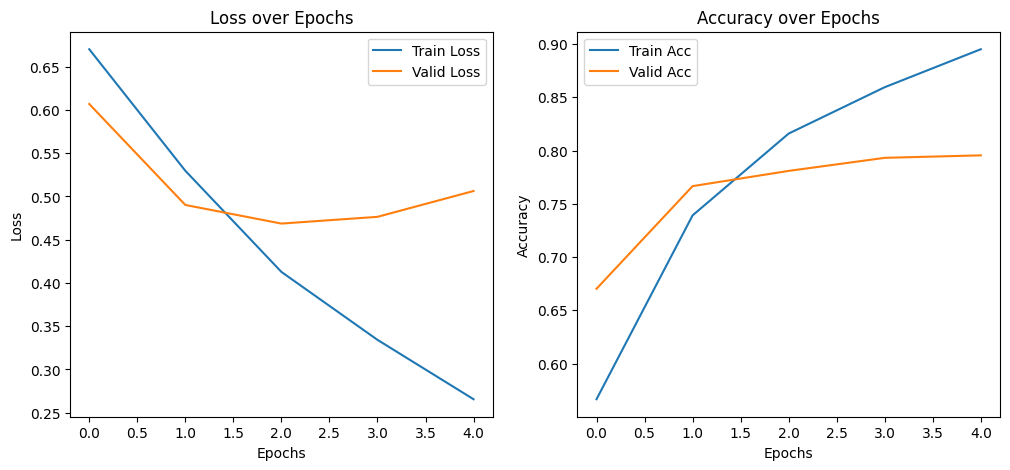

In [11]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(len(valid_losses)), train_losses, label='Train Loss')
plt.plot(range(len(valid_losses)), valid_losses, label='Valid Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss over Epochs')

plt.subplot(1, 2, 2)
plt.plot(range(len(valid_losses)), train_accs, label='Train Acc')
plt.plot(range(len(valid_losses)), valid_accs, label='Valid Acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy over Epochs')

plt.show()

## Next LSTM CELL Default Case Owervroden

In [ ]:
# Load and preprocess the dataset
path_to_dataset = "/content/drive/MyDrive/diploma/datasets/HateSpeechDatasetBalanced.csv"
df = pd.read_csv(path_to_dataset)
df = df.sample(frac=0.05, random_state=42)
df = df[['Content', 'Label']]

def preprocess(text):
    return word_tokenize(text.lower())

df['Content'] = df['Content'].apply(preprocess)

### Overwride imports

In [ ]:
def custom_lstm_cell(input, hidden, w_ih, w_hh, b_ih, b_hh):
    # type: (Tensor, Tuple[Tensor, Tensor], Tensor, Tensor, Tensor, Tensor) -> Tuple[Tensor, Tensor]
    hx, cx = hidden
    gates = torch.mm(input, w_ih.t()) + torch.mm(hx, w_hh.t()) + b_ih + b_hh

    ingate, forgetgate, cellgate, outgate = gates.chunk(4, 1)

    ingate = torch.sigmoid(ingate)
    forgetgate = torch.sigmoid(forgetgate)
    cellgate = torch.tanh(cellgate)
    outgate = torch.sigmoid(outgate)

    cy = (forgetgate * cx) + (ingate * cellgate)
    hy = outgate * torch.tanh(cy)
    # print("EEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEE")

    return hy, cy

###### To

In [ ]:
import math
import numbers
import warnings
import weakref
from typing import List, Optional, overload, Tuple
from typing_extensions import deprecated

import torch
from torch import _VF, Tensor
from torch.nn import init
from torch.nn.parameter import Parameter
from torch.nn.utils.rnn import PackedSequence

Module = nn.Module


__all__ = [
    "RNNBase",
    "RNN",
    "LSTM",
    "GRU",
    "RNNCellBase",
    "RNNCell",
    "LSTMCell",
    "GRUCell",
]

_rnn_impls = {
    "RNN_TANH": _VF.rnn_tanh,
    "RNN_RELU": _VF.rnn_relu,
}


def _apply_permutation(tensor: Tensor, permutation: Tensor, dim: int = 1) -> Tensor:
    return tensor.index_select(dim, permutation)


@deprecated(
    "`apply_permutation` is deprecated, please use `tensor.index_select(dim, permutation)` instead",
    category=FutureWarning,
)
def apply_permutation(tensor: Tensor, permutation: Tensor, dim: int = 1) -> Tensor:
    return _apply_permutation(tensor, permutation, dim)


class RNNBase(Module):
    r"""Base class for RNN modules (RNN, LSTM, GRU).

    Implements aspects of RNNs shared by the RNN, LSTM, and GRU classes, such as module initialization
    and utility methods for parameter storage management.

    .. note::
        The forward method is not implemented by the RNNBase class.

    .. note::
        LSTM and GRU classes override some methods implemented by RNNBase.
    """

    __constants__ = [
        "mode",
        "input_size",
        "hidden_size",
        "num_layers",
        "bias",
        "batch_first",
        "dropout",
        "bidirectional",
        "proj_size",
    ]
    __jit_unused_properties__ = ["all_weights"]

    mode: str
    input_size: int
    hidden_size: int
    num_layers: int
    bias: bool
    batch_first: bool
    dropout: float
    bidirectional: bool
    proj_size: int

    def __init__(
        self,
        mode: str,
        input_size: int,
        hidden_size: int,
        num_layers: int = 1,
        bias: bool = True,
        batch_first: bool = False,
        dropout: float = 0.0,
        bidirectional: bool = False,
        proj_size: int = 0,
        device=None,
        dtype=None,
    ) -> None:
        factory_kwargs = {"device": device, "dtype": dtype}
        super().__init__()
        self.mode = mode
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.bias = bias
        self.batch_first = batch_first
        self.dropout = float(dropout)
        self.bidirectional = bidirectional
        self.proj_size = proj_size
        self._flat_weight_refs: List[Optional[weakref.ReferenceType[Parameter]]] = []
        num_directions = 2 if bidirectional else 1

        if (
            not isinstance(dropout, numbers.Number)
            or not 0 <= dropout <= 1
            or isinstance(dropout, bool)
        ):
            raise ValueError(
                "dropout should be a number in range [0, 1] "
                "representing the probability of an element being "
                "zeroed"
            )
        if dropout > 0 and num_layers == 1:
            warnings.warn(
                "dropout option adds dropout after all but last "
                "recurrent layer, so non-zero dropout expects "
                f"num_layers greater than 1, but got dropout={dropout} and "
                f"num_layers={num_layers}"
            )

        if not isinstance(hidden_size, int):
            raise TypeError(
                f"hidden_size should be of type int, got: {type(hidden_size).__name__}"
            )
        if hidden_size <= 0:
            raise ValueError("hidden_size must be greater than zero")
        if num_layers <= 0:
            raise ValueError("num_layers must be greater than zero")
        if proj_size < 0:
            raise ValueError(
                "proj_size should be a positive integer or zero to disable projections"
            )
        if proj_size >= hidden_size:
            raise ValueError("proj_size has to be smaller than hidden_size")

        if mode == "LSTM":
            gate_size = 4 * hidden_size
        elif mode == "GRU":
            gate_size = 3 * hidden_size
        elif mode == "RNN_TANH":
            gate_size = hidden_size
        elif mode == "RNN_RELU":
            gate_size = hidden_size
        else:
            raise ValueError("Unrecognized RNN mode: " + mode)

        self._flat_weights_names = []
        self._all_weights = []
        for layer in range(num_layers):
            for direction in range(num_directions):
                real_hidden_size = proj_size if proj_size > 0 else hidden_size
                layer_input_size = (
                    input_size if layer == 0 else real_hidden_size * num_directions
                )

                w_ih = Parameter(
                    torch.empty((gate_size, layer_input_size), **factory_kwargs)
                )
                w_hh = Parameter(
                    torch.empty((gate_size, real_hidden_size), **factory_kwargs)
                )
                b_ih = Parameter(torch.empty(gate_size, **factory_kwargs))
                # Second bias vector included for CuDNN compatibility. Only one
                # bias vector is needed in standard definition.
                b_hh = Parameter(torch.empty(gate_size, **factory_kwargs))
                layer_params: Tuple[Tensor, ...] = ()
                if self.proj_size == 0:
                    if bias:
                        layer_params = (w_ih, w_hh, b_ih, b_hh)
                    else:
                        layer_params = (w_ih, w_hh)
                else:
                    w_hr = Parameter(
                        torch.empty((proj_size, hidden_size), **factory_kwargs)
                    )
                    if bias:
                        layer_params = (w_ih, w_hh, b_ih, b_hh, w_hr)
                    else:
                        layer_params = (w_ih, w_hh, w_hr)

                suffix = "_reverse" if direction == 1 else ""
                param_names = ["weight_ih_l{}{}", "weight_hh_l{}{}"]
                if bias:
                    param_names += ["bias_ih_l{}{}", "bias_hh_l{}{}"]
                if self.proj_size > 0:
                    param_names += ["weight_hr_l{}{}"]
                param_names = [x.format(layer, suffix) for x in param_names]

                for name, param in zip(param_names, layer_params):
                    setattr(self, name, param)
                self._flat_weights_names.extend(param_names)
                self._all_weights.append(param_names)

        self._init_flat_weights()

        self.reset_parameters()

    def _init_flat_weights(self):
        self._flat_weights = [
            getattr(self, wn) if hasattr(self, wn) else None
            for wn in self._flat_weights_names
        ]
        self._flat_weight_refs = [
            weakref.ref(w) if w is not None else None for w in self._flat_weights
        ]
        self.flatten_parameters()

    def __setattr__(self, attr, value):
        if hasattr(self, "_flat_weights_names") and attr in self._flat_weights_names:
            # keep self._flat_weights up to date if you do self.weight = ...
            idx = self._flat_weights_names.index(attr)
            self._flat_weights[idx] = value
        super().__setattr__(attr, value)

    def flatten_parameters(self) -> None:
        """Reset parameter data pointer so that they can use faster code paths.

        Right now, this works only if the module is on the GPU and cuDNN is enabled.
        Otherwise, it's a no-op.
        """
        # Short-circuits if _flat_weights is only partially instantiated
        if len(self._flat_weights) != len(self._flat_weights_names):
            return

        for w in self._flat_weights:
            if not isinstance(w, Tensor):
                return
        # Short-circuits if any tensor in self._flat_weights is not acceptable to cuDNN
        # or the tensors in _flat_weights are of different dtypes

        first_fw = self._flat_weights[0]
        dtype = first_fw.dtype
        for fw in self._flat_weights:
            if (
                not isinstance(fw, Tensor)
                or not (fw.dtype == dtype)
                or not fw.is_cuda
                or not torch.backends.cudnn.is_acceptable(fw)
            ):
                return

        # If any parameters alias, we fall back to the slower, copying code path. This is
        # a sufficient check, because overlapping parameter buffers that don't completely
        # alias would break the assumptions of the uniqueness check in
        # Module.named_parameters().
        unique_data_ptrs = {p.data_ptr() for p in self._flat_weights}
        if len(unique_data_ptrs) != len(self._flat_weights):
            return

        with torch.cuda.device_of(first_fw):
            import torch.backends.cudnn.rnn as rnn

            # Note: no_grad() is necessary since _cudnn_rnn_flatten_weight is
            # an inplace operation on self._flat_weights
            with torch.no_grad():
                if torch._use_cudnn_rnn_flatten_weight():
                    num_weights = 4 if self.bias else 2
                    if self.proj_size > 0:
                        num_weights += 1
                    torch._cudnn_rnn_flatten_weight(
                        self._flat_weights,
                        num_weights,
                        self.input_size,
                        rnn.get_cudnn_mode(self.mode),
                        self.hidden_size,
                        self.proj_size,
                        self.num_layers,
                        self.batch_first,
                        bool(self.bidirectional),
                    )

    def _apply(self, fn, recurse=True):
        self._flat_weight_refs = []
        ret = super()._apply(fn, recurse)

        # Resets _flat_weights
        # Note: be v. careful before removing this, as 3rd party device types
        # likely rely on this behavior to properly .to() modules like LSTM.
        self._init_flat_weights()

        return ret

    def reset_parameters(self) -> None:
        stdv = 1.0 / math.sqrt(self.hidden_size) if self.hidden_size > 0 else 0
        for weight in self.parameters():
            init.uniform_(weight, -stdv, stdv)

    def check_input(self, input: Tensor, batch_sizes: Optional[Tensor]) -> None:
        if not torch.jit.is_scripting():
            if (
                input.dtype != self._flat_weights[0].dtype
                and not torch._C._is_any_autocast_enabled()
            ):
                raise ValueError(
                    f"input must have the type {self._flat_weights[0].dtype}, got type {input.dtype}"
                )
        expected_input_dim = 2 if batch_sizes is not None else 3
        if input.dim() != expected_input_dim:
            raise RuntimeError(
                f"input must have {expected_input_dim} dimensions, got {input.dim()}"
            )
        if self.input_size != input.size(-1):
            raise RuntimeError(
                f"input.size(-1) must be equal to input_size. Expected {self.input_size}, got {input.size(-1)}"
            )

    def get_expected_hidden_size(
        self, input: Tensor, batch_sizes: Optional[Tensor]
    ) -> Tuple[int, int, int]:
        if batch_sizes is not None:
            mini_batch = int(batch_sizes[0])
        else:
            mini_batch = input.size(0) if self.batch_first else input.size(1)
        num_directions = 2 if self.bidirectional else 1
        if self.proj_size > 0:
            expected_hidden_size = (
                self.num_layers * num_directions,
                mini_batch,
                self.proj_size,
            )
        else:
            expected_hidden_size = (
                self.num_layers * num_directions,
                mini_batch,
                self.hidden_size,
            )
        return expected_hidden_size

    def check_hidden_size(
        self,
        hx: Tensor,
        expected_hidden_size: Tuple[int, int, int],
        msg: str = "Expected hidden size {}, got {}",
    ) -> None:
        if hx.size() != expected_hidden_size:
            raise RuntimeError(msg.format(expected_hidden_size, list(hx.size())))

    def _weights_have_changed(self):
        # Returns True if the weight tensors have changed since the last forward pass.
        # This is the case when used with torch.func.functional_call(), for example.
        weights_changed = False
        for ref, name in zip(self._flat_weight_refs, self._flat_weights_names):
            weight = getattr(self, name) if hasattr(self, name) else None
            if weight is not None and ref is not None and ref() is not weight:
                weights_changed = True
                break
        return weights_changed

    def check_forward_args(
        self, input: Tensor, hidden: Tensor, batch_sizes: Optional[Tensor]
    ):
        self.check_input(input, batch_sizes)
        expected_hidden_size = self.get_expected_hidden_size(input, batch_sizes)

        self.check_hidden_size(hidden, expected_hidden_size)

    def permute_hidden(self, hx: Tensor, permutation: Optional[Tensor]):
        if permutation is None:
            return hx
        return _apply_permutation(hx, permutation)

    def extra_repr(self) -> str:
        s = "{input_size}, {hidden_size}"
        if self.proj_size != 0:
            s += ", proj_size={proj_size}"
        if self.num_layers != 1:
            s += ", num_layers={num_layers}"
        if self.bias is not True:
            s += ", bias={bias}"
        if self.batch_first is not False:
            s += ", batch_first={batch_first}"
        if self.dropout != 0:
            s += ", dropout={dropout}"
        if self.bidirectional is not False:
            s += ", bidirectional={bidirectional}"
        return s.format(**self.__dict__)

    def _update_flat_weights(self):
        if not torch.jit.is_scripting():
            if self._weights_have_changed():
                self._init_flat_weights()

    def __getstate__(self):
        # If weights have been changed, update the _flat_weights in __getstate__ here.
        self._update_flat_weights()
        # Don't serialize the weight references.
        state = self.__dict__.copy()
        del state["_flat_weight_refs"]
        return state

    def __setstate__(self, d):
        super().__setstate__(d)
        if "all_weights" in d:
            self._all_weights = d["all_weights"]
        # In PyTorch 1.8 we added a proj_size member variable to LSTM.
        # LSTMs that were serialized via torch.save(module) before PyTorch 1.8
        # don't have it, so to preserve compatibility we set proj_size here.
        if "proj_size" not in d:
            self.proj_size = 0

        if not isinstance(self._all_weights[0][0], str):
            num_layers = self.num_layers
            num_directions = 2 if self.bidirectional else 1
            self._flat_weights_names = []
            self._all_weights = []
            for layer in range(num_layers):
                for direction in range(num_directions):
                    suffix = "_reverse" if direction == 1 else ""
                    weights = [
                        "weight_ih_l{}{}",
                        "weight_hh_l{}{}",
                        "bias_ih_l{}{}",
                        "bias_hh_l{}{}",
                        "weight_hr_l{}{}",
                    ]
                    weights = [x.format(layer, suffix) for x in weights]
                    if self.bias:
                        if self.proj_size > 0:
                            self._all_weights += [weights]
                            self._flat_weights_names.extend(weights)
                        else:
                            self._all_weights += [weights[:4]]
                            self._flat_weights_names.extend(weights[:4])
                    else:
                        if self.proj_size > 0:
                            self._all_weights += [weights[:2]] + [weights[-1:]]
                            self._flat_weights_names.extend(
                                weights[:2] + [weights[-1:]]
                            )
                        else:
                            self._all_weights += [weights[:2]]
                            self._flat_weights_names.extend(weights[:2])
            self._flat_weights = [
                getattr(self, wn) if hasattr(self, wn) else None
                for wn in self._flat_weights_names
            ]

        self._flat_weight_refs = [
            weakref.ref(w) if w is not None else None for w in self._flat_weights
        ]

    @property
    def all_weights(self) -> List[List[Parameter]]:
        return [
            [getattr(self, weight) for weight in weights]
            for weights in self._all_weights
        ]

    def _replicate_for_data_parallel(self):
        replica = super()._replicate_for_data_parallel()
        # Need to copy these caches, otherwise the replica will share the same
        # flat weights list.
        replica._flat_weights = replica._flat_weights[:]
        replica._flat_weights_names = replica._flat_weights_names[:]
        return replica


class RNN(RNNBase):

    @overload
    def __init__(
        self,
        input_size: int,
        hidden_size: int,
        num_layers: int = 1,
        nonlinearity: str = "tanh",
        bias: bool = True,
        batch_first: bool = False,
        dropout: float = 0.0,
        bidirectional: bool = False,
        device=None,
        dtype=None,
    ) -> None:
        ...

    @overload
    def __init__(self, *args, **kwargs):
        ...

    def __init__(self, *args, **kwargs):
        if "proj_size" in kwargs:
            raise ValueError(
                "proj_size argument is only supported for LSTM, not RNN or GRU"
            )
        if len(args) > 3:
            self.nonlinearity = args[3]
            args = args[:3] + args[4:]
        else:
            self.nonlinearity = kwargs.pop("nonlinearity", "tanh")
        if self.nonlinearity == "tanh":
            mode = "RNN_TANH"
        elif self.nonlinearity == "relu":
            mode = "RNN_RELU"
        else:
            raise ValueError(
                f"Unknown nonlinearity '{self.nonlinearity}'. Select from 'tanh' or 'relu'."
            )
        super().__init__(mode, *args, **kwargs)

    @overload
    @torch._jit_internal._overload_method  # noqa: F811
    def forward(
        self, input: Tensor, hx: Optional[Tensor] = None
    ) -> Tuple[Tensor, Tensor]:
        pass

    @overload
    @torch._jit_internal._overload_method  # noqa: F811
    def forward(
        self, input: PackedSequence, hx: Optional[Tensor] = None
    ) -> Tuple[PackedSequence, Tensor]:
        pass

    def forward(self, input, hx=None):  # noqa: F811
        self._update_flat_weights()

        num_directions = 2 if self.bidirectional else 1
        orig_input = input

        if isinstance(orig_input, PackedSequence):
            input, batch_sizes, sorted_indices, unsorted_indices = input
            max_batch_size = batch_sizes[0]
            # script() is unhappy when max_batch_size is different type in cond branches, so we duplicate
            if hx is None:
                hx = torch.zeros(
                    self.num_layers * num_directions,
                    max_batch_size,
                    self.hidden_size,
                    dtype=input.dtype,
                    device=input.device,
                )
            else:
                # Each batch of the hidden state should match the input sequence that
                # the user believes he/she is passing in.
                hx = self.permute_hidden(hx, sorted_indices)
        else:
            batch_sizes = None
            if input.dim() not in (2, 3):
                raise ValueError(
                    f"RNN: Expected input to be 2D or 3D, got {input.dim()}D tensor instead"
                )
            is_batched = input.dim() == 3
            batch_dim = 0 if self.batch_first else 1
            if not is_batched:
                input = input.unsqueeze(batch_dim)
                if hx is not None:
                    if hx.dim() != 2:
                        raise RuntimeError(
                            f"For unbatched 2-D input, hx should also be 2-D but got {hx.dim()}-D tensor"
                        )
                    hx = hx.unsqueeze(1)
            else:
                if hx is not None and hx.dim() != 3:
                    raise RuntimeError(
                        f"For batched 3-D input, hx should also be 3-D but got {hx.dim()}-D tensor"
                    )
            max_batch_size = input.size(0) if self.batch_first else input.size(1)
            sorted_indices = None
            unsorted_indices = None
            if hx is None:
                hx = torch.zeros(
                    self.num_layers * num_directions,
                    max_batch_size,
                    self.hidden_size,
                    dtype=input.dtype,
                    device=input.device,
                )
            else:
                # Each batch of the hidden state should match the input sequence that
                # the user believes he/she is passing in.
                hx = self.permute_hidden(hx, sorted_indices)

        assert hx is not None
        self.check_forward_args(input, hx, batch_sizes)
        assert self.mode == "RNN_TANH" or self.mode == "RNN_RELU"
        if batch_sizes is None:
            if self.mode == "RNN_TANH":
                result = _VF.rnn_tanh(
                    input,
                    hx,
                    self._flat_weights,
                    self.bias,
                    self.num_layers,
                    self.dropout,
                    self.training,
                    self.bidirectional,
                    self.batch_first,
                )
            else:
                result = _VF.rnn_relu(
                    input,
                    hx,
                    self._flat_weights,
                    self.bias,
                    self.num_layers,
                    self.dropout,
                    self.training,
                    self.bidirectional,
                    self.batch_first,
                )
        else:
            if self.mode == "RNN_TANH":
                result = _VF.rnn_tanh(
                    input,
                    batch_sizes,
                    hx,
                    self._flat_weights,
                    self.bias,
                    self.num_layers,
                    self.dropout,
                    self.training,
                    self.bidirectional,
                )
            else:
                result = _VF.rnn_relu(
                    input,
                    batch_sizes,
                    hx,
                    self._flat_weights,
                    self.bias,
                    self.num_layers,
                    self.dropout,
                    self.training,
                    self.bidirectional,
                )

        output = result[0]
        hidden = result[1]

        if isinstance(orig_input, PackedSequence):
            output_packed = PackedSequence(
                output, batch_sizes, sorted_indices, unsorted_indices
            )
            return output_packed, self.permute_hidden(hidden, unsorted_indices)

        if not is_batched:  # type: ignore[possibly-undefined]
            output = output.squeeze(batch_dim)  # type: ignore[possibly-undefined]
            hidden = hidden.squeeze(1)

        return output, self.permute_hidden(hidden, unsorted_indices)


class LSTM(RNNBase):
    @overload
    def __init__(
        self,
        input_size: int,
        hidden_size: int,
        num_layers: int = 1,
        bias: bool = True,
        batch_first: bool = False,
        dropout: float = 0.0,
        bidirectional: bool = False,
        proj_size: int = 0,
        device=None,
        dtype=None,
    ) -> None:
        ...

    @overload
    def __init__(self, *args, **kwargs):
        ...

    def __init__(self, *args, **kwargs):
        super().__init__("LSTM", *args, **kwargs)

    def get_expected_cell_size(
        self, input: Tensor, batch_sizes: Optional[Tensor]
    ) -> Tuple[int, int, int]:
        if batch_sizes is not None:
            mini_batch = int(batch_sizes[0])
        else:
            mini_batch = input.size(0) if self.batch_first else input.size(1)
        num_directions = 2 if self.bidirectional else 1
        expected_hidden_size = (
            self.num_layers * num_directions,
            mini_batch,
            self.hidden_size,
        )
        return expected_hidden_size

    # In the future, we should prevent mypy from applying contravariance rules here.
    # See torch/nn/modules/module.py::_forward_unimplemented
    def check_forward_args(
        self,
        input: Tensor,
        hidden: Tuple[Tensor, Tensor],  # type: ignore[override]
        batch_sizes: Optional[Tensor],
    ):
        self.check_input(input, batch_sizes)
        self.check_hidden_size(
            hidden[0],
            self.get_expected_hidden_size(input, batch_sizes),
            "Expected hidden[0] size {}, got {}",
        )
        self.check_hidden_size(
            hidden[1],
            self.get_expected_cell_size(input, batch_sizes),
            "Expected hidden[1] size {}, got {}",
        )

    # Same as above, see torch/nn/modules/module.py::_forward_unimplemented
    def permute_hidden(  # type: ignore[override]
        self,
        hx: Tuple[Tensor, Tensor],
        permutation: Optional[Tensor],
    ) -> Tuple[Tensor, Tensor]:
        if permutation is None:
            return hx
        return _apply_permutation(hx[0], permutation), _apply_permutation(
            hx[1], permutation
        )

    # Same as above, see torch/nn/modules/module.py::_forward_unimplemented
    @overload  # type: ignore[override]
    @torch._jit_internal._overload_method  # noqa: F811
    def forward(
        self, input: Tensor, hx: Optional[Tuple[Tensor, Tensor]] = None
    ) -> Tuple[Tensor, Tuple[Tensor, Tensor]]:  # noqa: F811
        pass

    # Same as above, see torch/nn/modules/module.py::_forward_unimplemented
    @overload
    @torch._jit_internal._overload_method  # noqa: F811
    def forward(
        self, input: PackedSequence, hx: Optional[Tuple[Tensor, Tensor]] = None
    ) -> Tuple[PackedSequence, Tuple[Tensor, Tensor]]:  # noqa: F811
        pass

    def forward(self, input, hx=None):  # noqa: F811
        self._update_flat_weights()

        orig_input = input
        # xxx: isinstance check needs to be in conditional for TorchScript to compile
        batch_sizes = None
        do_permute = False
        num_directions = 2 if self.bidirectional else 1
        real_hidden_size = self.proj_size if self.proj_size > 0 else self.hidden_size
        if isinstance(orig_input, PackedSequence):
            input, batch_sizes, sorted_indices, unsorted_indices = input
            max_batch_size = batch_sizes[0]
            if hx is None:
                h_zeros = torch.zeros(
                    self.num_layers * num_directions,
                    max_batch_size,
                    real_hidden_size,
                    dtype=input.dtype,
                    device=input.device,
                )
                c_zeros = torch.zeros(
                    self.num_layers * num_directions,
                    max_batch_size,
                    self.hidden_size,
                    dtype=input.dtype,
                    device=input.device,
                )
                hx = (h_zeros, c_zeros)
            else:
                # Each batch of the hidden state should match the input sequence that
                # the user believes he/she is passing in.
                hx = self.permute_hidden(hx, sorted_indices)
        else:
            if input.dim() not in (2, 3):
                raise ValueError(
                    f"LSTM: Expected input to be 2D or 3D, got {input.dim()}D instead"
                )
            is_batched = input.dim() == 3
            batch_dim = 0 if self.batch_first else 1
            if not is_batched:
                input = input.unsqueeze(batch_dim)
            max_batch_size = input.size(0) if self.batch_first else input.size(1)
            sorted_indices = None
            unsorted_indices = None
            if hx is None:
                h_zeros = torch.zeros(
                    self.num_layers * num_directions,
                    max_batch_size,
                    real_hidden_size,
                    dtype=input.dtype,
                    device=input.device,
                )
                c_zeros = torch.zeros(
                    self.num_layers * num_directions,
                    max_batch_size,
                    self.hidden_size,
                    dtype=input.dtype,
                    device=input.device,
                )
                hx = (h_zeros, c_zeros)
                self.check_forward_args(input, hx, batch_sizes)
            else:
                if is_batched:
                    if hx[0].dim() != 3 or hx[1].dim() != 3:
                        msg = (
                            "For batched 3-D input, hx and cx should "
                            f"also be 3-D but got ({hx[0].dim()}-D, {hx[1].dim()}-D) tensors"
                        )
                        raise RuntimeError(msg)
                else:
                    if hx[0].dim() != 2 or hx[1].dim() != 2:
                        msg = (
                            "For unbatched 2-D input, hx and cx should "
                            f"also be 2-D but got ({hx[0].dim()}-D, {hx[1].dim()}-D) tensors"
                        )
                        raise RuntimeError(msg)
                    hx = (hx[0].unsqueeze(1), hx[1].unsqueeze(1))
                # Each batch of the hidden state should match the input sequence that
                # the user believes he/she is passing in.
                self.check_forward_args(input, hx, batch_sizes)
                hx = self.permute_hidden(hx, sorted_indices)

        if batch_sizes is None:
            result = _VF.lstm(
                input,
                hx,
                self._flat_weights,
                self.bias,
                self.num_layers,
                self.dropout,
                self.training,
                self.bidirectional,
                self.batch_first,
            )
        else:
            result = _VF.lstm(
                input,
                batch_sizes,
                hx,
                self._flat_weights,
                self.bias,
                self.num_layers,
                self.dropout,
                self.training,
                self.bidirectional,
            )
        output = result[0]
        hidden = result[1:]
        # xxx: isinstance check needs to be in conditional for TorchScript to compile
        if isinstance(orig_input, PackedSequence):
            output_packed = PackedSequence(
                output, batch_sizes, sorted_indices, unsorted_indices
            )
            return output_packed, self.permute_hidden(hidden, unsorted_indices)
        else:
            if not is_batched:  # type: ignore[possibly-undefined]
                output = output.squeeze(batch_dim)  # type: ignore[possibly-undefined]
                hidden = (hidden[0].squeeze(1), hidden[1].squeeze(1))
            return output, self.permute_hidden(hidden, unsorted_indices)


class GRU(RNNBase):
    @overload
    def __init__(
        self,
        input_size: int,
        hidden_size: int,
        num_layers: int = 1,
        bias: bool = True,
        batch_first: bool = False,
        dropout: float = 0.0,
        bidirectional: bool = False,
        device=None,
        dtype=None,
    ) -> None:
        ...

    @overload
    def __init__(self, *args, **kwargs):
        ...

    def __init__(self, *args, **kwargs):
        if "proj_size" in kwargs:
            raise ValueError(
                "proj_size argument is only supported for LSTM, not RNN or GRU"
            )
        super().__init__("GRU", *args, **kwargs)

    @overload  # type: ignore[override]
    @torch._jit_internal._overload_method  # noqa: F811
    def forward(
        self, input: Tensor, hx: Optional[Tensor] = None
    ) -> Tuple[Tensor, Tensor]:  # noqa: F811
        pass

    @overload
    @torch._jit_internal._overload_method  # noqa: F811
    def forward(
        self, input: PackedSequence, hx: Optional[Tensor] = None
    ) -> Tuple[PackedSequence, Tensor]:  # noqa: F811
        pass

    def forward(self, input, hx=None):  # noqa: F811
        self._update_flat_weights()

        orig_input = input
        # xxx: isinstance check needs to be in conditional for TorchScript to compile
        if isinstance(orig_input, PackedSequence):
            input, batch_sizes, sorted_indices, unsorted_indices = input
            max_batch_size = batch_sizes[0]
            if hx is None:
                num_directions = 2 if self.bidirectional else 1
                hx = torch.zeros(
                    self.num_layers * num_directions,
                    max_batch_size,
                    self.hidden_size,
                    dtype=input.dtype,
                    device=input.device,
                )
            else:
                # Each batch of the hidden state should match the input sequence that
                # the user believes he/she is passing in.
                hx = self.permute_hidden(hx, sorted_indices)
        else:
            batch_sizes = None
            if input.dim() not in (2, 3):
                raise ValueError(
                    f"GRU: Expected input to be 2D or 3D, got {input.dim()}D instead"
                )
            is_batched = input.dim() == 3
            batch_dim = 0 if self.batch_first else 1
            if not is_batched:
                input = input.unsqueeze(batch_dim)
                if hx is not None:
                    if hx.dim() != 2:
                        raise RuntimeError(
                            f"For unbatched 2-D input, hx should also be 2-D but got {hx.dim()}-D tensor"
                        )
                    hx = hx.unsqueeze(1)
            else:
                if hx is not None and hx.dim() != 3:
                    raise RuntimeError(
                        f"For batched 3-D input, hx should also be 3-D but got {hx.dim()}-D tensor"
                    )
            max_batch_size = input.size(0) if self.batch_first else input.size(1)
            sorted_indices = None
            unsorted_indices = None
            if hx is None:
                num_directions = 2 if self.bidirectional else 1
                hx = torch.zeros(
                    self.num_layers * num_directions,
                    max_batch_size,
                    self.hidden_size,
                    dtype=input.dtype,
                    device=input.device,
                )
            else:
                # Each batch of the hidden state should match the input sequence that
                # the user believes he/she is passing in.
                hx = self.permute_hidden(hx, sorted_indices)

        self.check_forward_args(input, hx, batch_sizes)
        if batch_sizes is None:
            result = _VF.gru(
                input,
                hx,
                self._flat_weights,
                self.bias,
                self.num_layers,
                self.dropout,
                self.training,
                self.bidirectional,
                self.batch_first,
            )
        else:
            result = _VF.gru(
                input,
                batch_sizes,
                hx,
                self._flat_weights,
                self.bias,
                self.num_layers,
                self.dropout,
                self.training,
                self.bidirectional,
            )
        output = result[0]
        hidden = result[1]

        # xxx: isinstance check needs to be in conditional for TorchScript to compile
        if isinstance(orig_input, PackedSequence):
            output_packed = PackedSequence(
                output, batch_sizes, sorted_indices, unsorted_indices
            )
            return output_packed, self.permute_hidden(hidden, unsorted_indices)
        else:
            if not is_batched:  # type: ignore[possibly-undefined]
                output = output.squeeze(batch_dim)  # type: ignore[possibly-undefined]
                hidden = hidden.squeeze(1)

            return output, self.permute_hidden(hidden, unsorted_indices)


class RNNCellBase(Module):
    __constants__ = ["input_size", "hidden_size", "bias"]

    input_size: int
    hidden_size: int
    bias: bool
    weight_ih: Tensor
    weight_hh: Tensor
    # WARNING: bias_ih and bias_hh purposely not defined here.
    # See https://github.com/pytorch/pytorch/issues/39670

    def __init__(
        self,
        input_size: int,
        hidden_size: int,
        bias: bool,
        num_chunks: int,
        device=None,
        dtype=None,
    ) -> None:
        factory_kwargs = {"device": device, "dtype": dtype}
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.bias = bias
        self.weight_ih = Parameter(
            torch.empty((num_chunks * hidden_size, input_size), **factory_kwargs)
        )
        self.weight_hh = Parameter(
            torch.empty((num_chunks * hidden_size, hidden_size), **factory_kwargs)
        )
        if bias:
            self.bias_ih = Parameter(
                torch.empty(num_chunks * hidden_size, **factory_kwargs)
            )
            self.bias_hh = Parameter(
                torch.empty(num_chunks * hidden_size, **factory_kwargs)
            )
        else:
            self.register_parameter("bias_ih", None)
            self.register_parameter("bias_hh", None)

        self.reset_parameters()

    def extra_repr(self) -> str:
        s = "{input_size}, {hidden_size}"
        if "bias" in self.__dict__ and self.bias is not True:
            s += ", bias={bias}"
        if "nonlinearity" in self.__dict__ and self.nonlinearity != "tanh":
            s += ", nonlinearity={nonlinearity}"
        return s.format(**self.__dict__)

    def reset_parameters(self) -> None:
        stdv = 1.0 / math.sqrt(self.hidden_size) if self.hidden_size > 0 else 0
        for weight in self.parameters():
            init.uniform_(weight, -stdv, stdv)


class RNNCell(RNNCellBase):
    r"""An Elman RNN cell with tanh or ReLU non-linearity.

    .. math::

        h' = \tanh(W_{ih} x + b_{ih}  +  W_{hh} h + b_{hh})

    If :attr:`nonlinearity` is `'relu'`, then ReLU is used in place of tanh.

    Args:
        input_size: The number of expected features in the input `x`
        hidden_size: The number of features in the hidden state `h`
        bias: If ``False``, then the layer does not use bias weights `b_ih` and `b_hh`.
            Default: ``True``
        nonlinearity: The non-linearity to use. Can be either ``'tanh'`` or ``'relu'``. Default: ``'tanh'``

    Inputs: input, hidden
        - **input**: tensor containing input features
        - **hidden**: tensor containing the initial hidden state
          Defaults to zero if not provided.

    Outputs: h'
        - **h'** of shape `(batch, hidden_size)`: tensor containing the next hidden state
          for each element in the batch

    Shape:
        - input: :math:`(N, H_{in})` or :math:`(H_{in})` tensor containing input features where
          :math:`H_{in}` = `input_size`.
        - hidden: :math:`(N, H_{out})` or :math:`(H_{out})` tensor containing the initial hidden
          state where :math:`H_{out}` = `hidden_size`. Defaults to zero if not provided.
        - output: :math:`(N, H_{out})` or :math:`(H_{out})` tensor containing the next hidden state.

    Attributes:
        weight_ih: the learnable input-hidden weights, of shape
            `(hidden_size, input_size)`
        weight_hh: the learnable hidden-hidden weights, of shape
            `(hidden_size, hidden_size)`
        bias_ih: the learnable input-hidden bias, of shape `(hidden_size)`
        bias_hh: the learnable hidden-hidden bias, of shape `(hidden_size)`

    .. note::
        All the weights and biases are initialized from :math:`\mathcal{U}(-\sqrt{k}, \sqrt{k})`
        where :math:`k = \frac{1}{\text{hidden\_size}}`

    Examples::

        >>> rnn = nn.RNNCell(10, 20)
        >>> input = torch.randn(6, 3, 10)
        >>> hx = torch.randn(3, 20)
        >>> output = []
        >>> for i in range(6):
        ...     hx = rnn(input[i], hx)
        ...     output.append(hx)
    """

    __constants__ = ["input_size", "hidden_size", "bias", "nonlinearity"]
    nonlinearity: str

    def __init__(
        self,
        input_size: int,
        hidden_size: int,
        bias: bool = True,
        nonlinearity: str = "tanh",
        device=None,
        dtype=None,
    ) -> None:
        factory_kwargs = {"device": device, "dtype": dtype}
        super().__init__(input_size, hidden_size, bias, num_chunks=1, **factory_kwargs)
        self.nonlinearity = nonlinearity

    def forward(self, input: Tensor, hx: Optional[Tensor] = None) -> Tensor:
        if input.dim() not in (1, 2):
            raise ValueError(
                f"RNNCell: Expected input to be 1D or 2D, got {input.dim()}D instead"
            )
        if hx is not None and hx.dim() not in (1, 2):
            raise ValueError(
                f"RNNCell: Expected hidden to be 1D or 2D, got {hx.dim()}D instead"
            )
        is_batched = input.dim() == 2
        if not is_batched:
            input = input.unsqueeze(0)

        if hx is None:
            hx = torch.zeros(
                input.size(0), self.hidden_size, dtype=input.dtype, device=input.device
            )
        else:
            hx = hx.unsqueeze(0) if not is_batched else hx

        if self.nonlinearity == "tanh":
            ret = _VF.rnn_tanh_cell(
                input,
                hx,
                self.weight_ih,
                self.weight_hh,
                self.bias_ih,
                self.bias_hh,
            )
        elif self.nonlinearity == "relu":
            ret = _VF.rnn_relu_cell(
                input,
                hx,
                self.weight_ih,
                self.weight_hh,
                self.bias_ih,
                self.bias_hh,
            )
        else:
            ret = input  # TODO: remove when jit supports exception flow
            raise RuntimeError(f"Unknown nonlinearity: {self.nonlinearity}")

        if not is_batched:
            ret = ret.squeeze(0)

        return ret


class LSTMCell(RNNCellBase):
    def __init__(
        self,
        input_size: int,
        hidden_size: int,
        bias: bool = True,
        device=None,
        dtype=None,
    ) -> None:
        factory_kwargs = {"device": device, "dtype": dtype}
        super().__init__(input_size, hidden_size, bias, num_chunks=4, **factory_kwargs)

    def forward(
        self, input: Tensor, hx: Optional[Tuple[Tensor, Tensor]] = None
    ) -> Tuple[Tensor, Tensor]:
        # ptint("LSTMCELL FFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFO")
        if input.dim() not in (1, 2):
            raise ValueError(
                f"LSTMCell: Expected input to be 1D or 2D, got {input.dim()}D instead"
            )
        if hx is not None:
            for idx, value in enumerate(hx):
                if value.dim() not in (1, 2):
                    raise ValueError(
                        f"LSTMCell: Expected hx[{idx}] to be 1D or 2D, got {value.dim()}D instead"
                    )
        is_batched = input.dim() == 2
        if not is_batched:
            input = input.unsqueeze(0)

        if hx is None:
            zeros = torch.zeros(
                input.size(0), self.hidden_size, dtype=input.dtype, device=input.device
            )
            hx = (zeros, zeros)
        else:
            hx = (hx[0].unsqueeze(0), hx[1].unsqueeze(0)) if not is_batched else hx

        ret = custom_lstm_cell(
            input,
            hx,
            self.weight_ih,
            self.weight_hh,
            self.bias_ih,
            self.bias_hh,
        )

        if not is_batched:
            ret = (ret[0].squeeze(0), ret[1].squeeze(0))
        return ret


class GRUCell(RNNCellBase):
    r"""A gated recurrent unit (GRU) cell.

    .. math::

        \begin{array}{ll}
        r = \sigma(W_{ir} x + b_{ir} + W_{hr} h + b_{hr}) \\
        z = \sigma(W_{iz} x + b_{iz} + W_{hz} h + b_{hz}) \\
        n = \tanh(W_{in} x + b_{in} + r \odot (W_{hn} h + b_{hn})) \\
        h' = (1 - z) \odot n + z \odot h
        \end{array}

    where :math:`\sigma` is the sigmoid function, and :math:`\odot` is the Hadamard product.

    Args:
        input_size: The number of expected features in the input `x`
        hidden_size: The number of features in the hidden state `h`
        bias: If ``False``, then the layer does not use bias weights `b_ih` and
            `b_hh`. Default: ``True``

    Inputs: input, hidden
        - **input** : tensor containing input features
        - **hidden** : tensor containing the initial hidden
          state for each element in the batch.
          Defaults to zero if not provided.

    Outputs: h'
        - **h'** : tensor containing the next hidden state
          for each element in the batch

    Shape:
        - input: :math:`(N, H_{in})` or :math:`(H_{in})` tensor containing input features where
          :math:`H_{in}` = `input_size`.
        - hidden: :math:`(N, H_{out})` or :math:`(H_{out})` tensor containing the initial hidden
          state where :math:`H_{out}` = `hidden_size`. Defaults to zero if not provided.
        - output: :math:`(N, H_{out})` or :math:`(H_{out})` tensor containing the next hidden state.

    Attributes:
        weight_ih: the learnable input-hidden weights, of shape
            `(3*hidden_size, input_size)`
        weight_hh: the learnable hidden-hidden weights, of shape
            `(3*hidden_size, hidden_size)`
        bias_ih: the learnable input-hidden bias, of shape `(3*hidden_size)`
        bias_hh: the learnable hidden-hidden bias, of shape `(3*hidden_size)`

    .. note::
        All the weights and biases are initialized from :math:`\mathcal{U}(-\sqrt{k}, \sqrt{k})`
        where :math:`k = \frac{1}{\text{hidden\_size}}`

    On certain ROCm devices, when using float16 inputs this module will use :ref:`different precision<fp16_on_mi200>` for backward.

    Examples::

        >>> rnn = nn.GRUCell(10, 20)
        >>> input = torch.randn(6, 3, 10)
        >>> hx = torch.randn(3, 20)
        >>> output = []
        >>> for i in range(6):
        ...     hx = rnn(input[i], hx)
        ...     output.append(hx)
    """

    def __init__(
        self,
        input_size: int,
        hidden_size: int,
        bias: bool = True,
        device=None,
        dtype=None,
    ) -> None:
        factory_kwargs = {"device": device, "dtype": dtype}
        super().__init__(input_size, hidden_size, bias, num_chunks=3, **factory_kwargs)

    def forward(self, input: Tensor, hx: Optional[Tensor] = None) -> Tensor:
        if input.dim() not in (1, 2):
            raise ValueError(
                f"GRUCell: Expected input to be 1D or 2D, got {input.dim()}D instead"
            )
        if hx is not None and hx.dim() not in (1, 2):
            raise ValueError(
                f"GRUCell: Expected hidden to be 1D or 2D, got {hx.dim()}D instead"
            )
        is_batched = input.dim() == 2
        if not is_batched:
            input = input.unsqueeze(0)

        if hx is None:
            hx = torch.zeros(
                input.size(0), self.hidden_size, dtype=input.dtype, device=input.device
            )
        else:
            hx = hx.unsqueeze(0) if not is_batched else hx

        ret = _VF.gru_cell(
            input,
            hx,
            self.weight_ih,
            self.weight_hh,
            self.bias_ih,
            self.bias_hh,
        )

        if not is_batched:
            ret = ret.squeeze(0)

        return ret

### To Do

In [ ]:
# Split the dataset into training and testing sets
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

# Build vocabulary
all_words = [word for tweet in train_df['Content'] for word in tweet]
vocab = sorted(set(all_words))
word_to_idx = {word: idx+1 for idx, word in enumerate(vocab)}
vocab_size = len(vocab) + 1  # +1 for padding index

# Encode tweets
def encode_tweet(tweet):
    return [word_to_idx[word] for word in tweet if word in word_to_idx]

train_df['Content'] = train_df['Content'].apply(encode_tweet)
test_df['Content'] = test_df['Content'].apply(encode_tweet)

# Pad sequences
def pad_sequences(sequences, max_len):
    return np.array([seq + [0]*(max_len-len(seq)) if len(seq) < max_len else seq[:max_len] for seq in sequences])

MAX_LEN = 100
X_train = pad_sequences(train_df['Content'], MAX_LEN)
X_test = pad_sequences(test_df['Content'], MAX_LEN)

# Encode labels
le = LabelEncoder()
y_train = le.fit_transform(train_df['Label'])
y_test = le.transform(test_df['Label'])

# Create Dataset and DataLoader
class HateSpeechDataset(Dataset):
    def __init__(self, tweets, labels):
        self.tweets = tweets
        self.labels = labels

    def __len__(self):
        return len(self.tweets)

    def __getitem__(self, idx):
        return torch.tensor(self.tweets[idx]), torch.tensor(self.labels[idx])

train_dataset = HateSpeechDataset(X_train, y_train)
test_dataset = HateSpeechDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64)

# Define the LSTM model using nn.LSTMCell
class LSTMModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim):
        super(LSTMModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm_cell = LSTMCell(embedding_dim, hidden_dim)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.hidden_dim = hidden_dim

    def forward(self, x):
        batch_size, seq_len = x.size()
        embedded = self.embedding(x)  # [batch_size, sequence_length, embedding_dim]

        h_t = torch.zeros(batch_size, self.hidden_dim, device=x.device)  # Hidden state
        c_t = torch.zeros(batch_size, self.hidden_dim, device=x.device)  # Cell state

        for t in range(seq_len):
            h_t, c_t = self.lstm_cell(embedded[:, t, :], (h_t, c_t))

        out = self.fc(h_t)  # Output from the last hidden state
        return out

# Hyperparameters
embedding_dim = 100
hidden_dim = 128
output_dim = 2  # Number of classes
learning_rate = 0.001

# Initialize the model, loss function, and optimizer
model = LSTMModel(vocab_size, embedding_dim, hidden_dim, output_dim)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training function
def train(model, dataloader, optimizer, criterion):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    for inputs, labels in tqdm(dataloader, desc="Training", leave=False):
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    avg_loss = total_loss / len(dataloader)
    accuracy = correct / total
    return avg_loss, accuracy

# Evaluation function
def evaluate(model, dataloader, criterion):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in tqdm(dataloader, desc="Evaluating", leave=False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    avg_loss = total_loss / len(dataloader)
    accuracy = correct / total
    return avg_loss, accuracy

In [ ]:
# Train the model
N_EPOCHS = 5
train_losses = []
valid_losses = []
train_accs = []
valid_accs = []

for epoch in range(N_EPOCHS):
    print(f'\nEpoch: {epoch+1}')
    train_loss, train_acc = train(model, train_loader, optimizer, criterion)
    valid_loss, valid_acc = evaluate(model, test_loader, criterion)

    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    train_accs.append(train_acc)
    valid_accs.append(valid_acc)

    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')


Epoch: 1


	Train Loss: 0.670 | Train Acc: 56.65%
	 Val. Loss: 0.607 |  Val. Acc: 67.02%

Epoch: 2


	Train Loss: 0.530 | Train Acc: 73.91%
	 Val. Loss: 0.490 |  Val. Acc: 76.66%

Epoch: 3


	Train Loss: 0.413 | Train Acc: 81.60%
	 Val. Loss: 0.469 |  Val. Acc: 78.09%

Epoch: 4


	Train Loss: 0.334 | Train Acc: 85.95%
	 Val. Loss: 0.476 |  Val. Acc: 79.32%

Epoch: 5


	Train Loss: 0.266 | Train Acc: 89.52%
	 Val. Loss: 0.506 |  Val. Acc: 79.55%


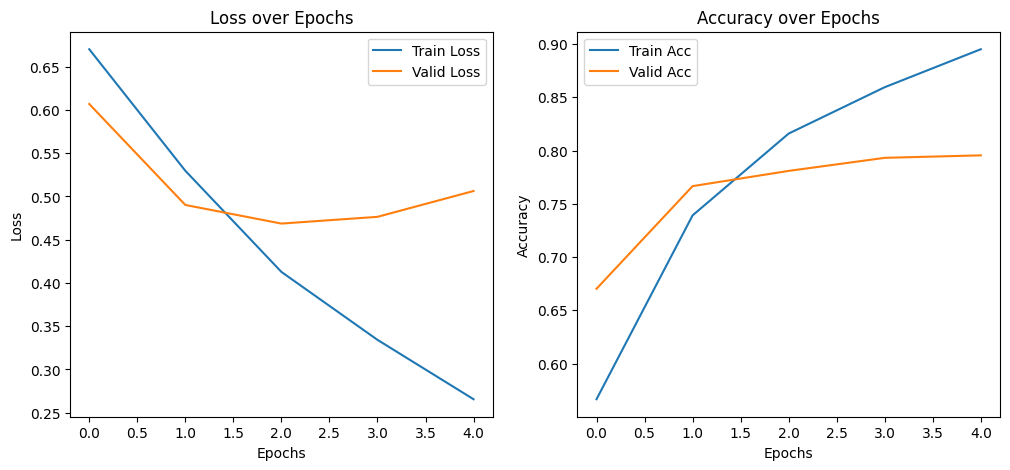

In [ ]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(len(valid_losses)), train_losses, label='Train Loss')
plt.plot(range(len(valid_losses)), valid_losses, label='Valid Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss over Epochs')

plt.subplot(1, 2, 2)
plt.plot(range(len(valid_losses)), train_accs, label='Train Acc')
plt.plot(range(len(valid_losses)), valid_accs, label='Valid Acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy over Epochs')

plt.show()

## Next LSTM CELL Default Case Owervroden

In [19]:
# Load and preprocess the dataset
path_to_dataset = "/content/drive/MyDrive/diploma/datasets/HateSpeechDatasetBalanced.csv"
df = pd.read_csv(path_to_dataset)
df = df.sample(frac=0.05, random_state=42)
df = df[['Content', 'Label']]

def preprocess(text):
    return word_tokenize(text.lower())

df['Content'] = df['Content'].apply(preprocess)

### Overwride imports

In [24]:
# def custom_lstm_cell(input, hidden, w_ih, w_hh, b_ih, b_hh):
#     # type: (Tensor, Tuple[Tensor, Tensor], Tensor, Tensor, Tensor, Tensor) -> Tuple[Tensor, Tensor]
#     hx, cx = hidden
#     gates = torch.mm(input, w_ih.t()) + torch.mm(hx, w_hh.t()) + b_ih + b_hh

#     ingate, forgetgate, cellgate, outgate = gates.chunk(4, 1)

#     ingate = torch.sigmoid(ingate)
#     forgetgate = torch.sigmoid(forgetgate)
#     cellgate = torch.tanh(cellgate)
#     outgate = torch.sigmoid(outgate)

#     # cy = (forgetgate * cx) + (ingate * cellgate)
#     cy = (forgetgate * cx) * (ingate * cellgate)
#     hy = outgate * torch.tanh(cy)
#     # print("EEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEE")

#     return hy, cy

def modified_lstm_cell(input, hidden, w_ih, w_hh, b_ih, b_hh):
    # type: (Tensor, Tuple[Tensor, Tensor], Tensor, Tensor, Tensor, Tensor) -> Tuple[Tensor, Tensor]
    hx, cx = hidden

    # Apply separate linear transformations for input and hidden state
    i_t = torch.sigmoid(torch.mm(input, w_ih.t()) + torch.mm(hx, w_hh.t()) + b_ih)
    f_t = torch.sigmoid(torch.mm(input, w_ih.t()) + torch.mm(hx, w_hh.t()) + b_hh)

    # Apply a single linear transformation for the cell gate
    c_tilde = torch.tanh(torch.mm(input, w_ih.t()) + torch.mm(hx, w_hh.t()) + (b_ih + b_hh))

    # Calculate the new cell state and hidden state
    c_t = f_t * cx + i_t * c_tilde
    h_t = i_t * torch.tanh(c_t)

    return h_t, c_t

###### To

In [25]:
import math
import numbers
import warnings
import weakref
from typing import List, Optional, overload, Tuple
from typing_extensions import deprecated

import torch
from torch import _VF, Tensor
from torch.nn import init
from torch.nn.parameter import Parameter
from torch.nn.utils.rnn import PackedSequence

Module = nn.Module


__all__ = [
    "RNNBase",
    "RNN",
    "LSTM",
    "GRU",
    "RNNCellBase",
    "RNNCell",
    "LSTMCell",
    "GRUCell",
]

_rnn_impls = {
    "RNN_TANH": _VF.rnn_tanh,
    "RNN_RELU": _VF.rnn_relu,
}


def _apply_permutation(tensor: Tensor, permutation: Tensor, dim: int = 1) -> Tensor:
    return tensor.index_select(dim, permutation)


@deprecated(
    "`apply_permutation` is deprecated, please use `tensor.index_select(dim, permutation)` instead",
    category=FutureWarning,
)
def apply_permutation(tensor: Tensor, permutation: Tensor, dim: int = 1) -> Tensor:
    return _apply_permutation(tensor, permutation, dim)


class RNNBase(Module):
    r"""Base class for RNN modules (RNN, LSTM, GRU).

    Implements aspects of RNNs shared by the RNN, LSTM, and GRU classes, such as module initialization
    and utility methods for parameter storage management.

    .. note::
        The forward method is not implemented by the RNNBase class.

    .. note::
        LSTM and GRU classes override some methods implemented by RNNBase.
    """

    __constants__ = [
        "mode",
        "input_size",
        "hidden_size",
        "num_layers",
        "bias",
        "batch_first",
        "dropout",
        "bidirectional",
        "proj_size",
    ]
    __jit_unused_properties__ = ["all_weights"]

    mode: str
    input_size: int
    hidden_size: int
    num_layers: int
    bias: bool
    batch_first: bool
    dropout: float
    bidirectional: bool
    proj_size: int

    def __init__(
        self,
        mode: str,
        input_size: int,
        hidden_size: int,
        num_layers: int = 1,
        bias: bool = True,
        batch_first: bool = False,
        dropout: float = 0.0,
        bidirectional: bool = False,
        proj_size: int = 0,
        device=None,
        dtype=None,
    ) -> None:
        factory_kwargs = {"device": device, "dtype": dtype}
        super().__init__()
        self.mode = mode
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.bias = bias
        self.batch_first = batch_first
        self.dropout = float(dropout)
        self.bidirectional = bidirectional
        self.proj_size = proj_size
        self._flat_weight_refs: List[Optional[weakref.ReferenceType[Parameter]]] = []
        num_directions = 2 if bidirectional else 1

        if (
            not isinstance(dropout, numbers.Number)
            or not 0 <= dropout <= 1
            or isinstance(dropout, bool)
        ):
            raise ValueError(
                "dropout should be a number in range [0, 1] "
                "representing the probability of an element being "
                "zeroed"
            )
        if dropout > 0 and num_layers == 1:
            warnings.warn(
                "dropout option adds dropout after all but last "
                "recurrent layer, so non-zero dropout expects "
                f"num_layers greater than 1, but got dropout={dropout} and "
                f"num_layers={num_layers}"
            )

        if not isinstance(hidden_size, int):
            raise TypeError(
                f"hidden_size should be of type int, got: {type(hidden_size).__name__}"
            )
        if hidden_size <= 0:
            raise ValueError("hidden_size must be greater than zero")
        if num_layers <= 0:
            raise ValueError("num_layers must be greater than zero")
        if proj_size < 0:
            raise ValueError(
                "proj_size should be a positive integer or zero to disable projections"
            )
        if proj_size >= hidden_size:
            raise ValueError("proj_size has to be smaller than hidden_size")

        if mode == "LSTM":
            gate_size = 4 * hidden_size
        elif mode == "GRU":
            gate_size = 3 * hidden_size
        elif mode == "RNN_TANH":
            gate_size = hidden_size
        elif mode == "RNN_RELU":
            gate_size = hidden_size
        else:
            raise ValueError("Unrecognized RNN mode: " + mode)

        self._flat_weights_names = []
        self._all_weights = []
        for layer in range(num_layers):
            for direction in range(num_directions):
                real_hidden_size = proj_size if proj_size > 0 else hidden_size
                layer_input_size = (
                    input_size if layer == 0 else real_hidden_size * num_directions
                )

                w_ih = Parameter(
                    torch.empty((gate_size, layer_input_size), **factory_kwargs)
                )
                w_hh = Parameter(
                    torch.empty((gate_size, real_hidden_size), **factory_kwargs)
                )
                b_ih = Parameter(torch.empty(gate_size, **factory_kwargs))
                # Second bias vector included for CuDNN compatibility. Only one
                # bias vector is needed in standard definition.
                b_hh = Parameter(torch.empty(gate_size, **factory_kwargs))
                layer_params: Tuple[Tensor, ...] = ()
                if self.proj_size == 0:
                    if bias:
                        layer_params = (w_ih, w_hh, b_ih, b_hh)
                    else:
                        layer_params = (w_ih, w_hh)
                else:
                    w_hr = Parameter(
                        torch.empty((proj_size, hidden_size), **factory_kwargs)
                    )
                    if bias:
                        layer_params = (w_ih, w_hh, b_ih, b_hh, w_hr)
                    else:
                        layer_params = (w_ih, w_hh, w_hr)

                suffix = "_reverse" if direction == 1 else ""
                param_names = ["weight_ih_l{}{}", "weight_hh_l{}{}"]
                if bias:
                    param_names += ["bias_ih_l{}{}", "bias_hh_l{}{}"]
                if self.proj_size > 0:
                    param_names += ["weight_hr_l{}{}"]
                param_names = [x.format(layer, suffix) for x in param_names]

                for name, param in zip(param_names, layer_params):
                    setattr(self, name, param)
                self._flat_weights_names.extend(param_names)
                self._all_weights.append(param_names)

        self._init_flat_weights()

        self.reset_parameters()

    def _init_flat_weights(self):
        self._flat_weights = [
            getattr(self, wn) if hasattr(self, wn) else None
            for wn in self._flat_weights_names
        ]
        self._flat_weight_refs = [
            weakref.ref(w) if w is not None else None for w in self._flat_weights
        ]
        self.flatten_parameters()

    def __setattr__(self, attr, value):
        if hasattr(self, "_flat_weights_names") and attr in self._flat_weights_names:
            # keep self._flat_weights up to date if you do self.weight = ...
            idx = self._flat_weights_names.index(attr)
            self._flat_weights[idx] = value
        super().__setattr__(attr, value)

    def flatten_parameters(self) -> None:
        """Reset parameter data pointer so that they can use faster code paths.

        Right now, this works only if the module is on the GPU and cuDNN is enabled.
        Otherwise, it's a no-op.
        """
        # Short-circuits if _flat_weights is only partially instantiated
        if len(self._flat_weights) != len(self._flat_weights_names):
            return

        for w in self._flat_weights:
            if not isinstance(w, Tensor):
                return
        # Short-circuits if any tensor in self._flat_weights is not acceptable to cuDNN
        # or the tensors in _flat_weights are of different dtypes

        first_fw = self._flat_weights[0]
        dtype = first_fw.dtype
        for fw in self._flat_weights:
            if (
                not isinstance(fw, Tensor)
                or not (fw.dtype == dtype)
                or not fw.is_cuda
                or not torch.backends.cudnn.is_acceptable(fw)
            ):
                return

        # If any parameters alias, we fall back to the slower, copying code path. This is
        # a sufficient check, because overlapping parameter buffers that don't completely
        # alias would break the assumptions of the uniqueness check in
        # Module.named_parameters().
        unique_data_ptrs = {p.data_ptr() for p in self._flat_weights}
        if len(unique_data_ptrs) != len(self._flat_weights):
            return

        with torch.cuda.device_of(first_fw):
            import torch.backends.cudnn.rnn as rnn

            # Note: no_grad() is necessary since _cudnn_rnn_flatten_weight is
            # an inplace operation on self._flat_weights
            with torch.no_grad():
                if torch._use_cudnn_rnn_flatten_weight():
                    num_weights = 4 if self.bias else 2
                    if self.proj_size > 0:
                        num_weights += 1
                    torch._cudnn_rnn_flatten_weight(
                        self._flat_weights,
                        num_weights,
                        self.input_size,
                        rnn.get_cudnn_mode(self.mode),
                        self.hidden_size,
                        self.proj_size,
                        self.num_layers,
                        self.batch_first,
                        bool(self.bidirectional),
                    )

    def _apply(self, fn, recurse=True):
        self._flat_weight_refs = []
        ret = super()._apply(fn, recurse)

        # Resets _flat_weights
        # Note: be v. careful before removing this, as 3rd party device types
        # likely rely on this behavior to properly .to() modules like LSTM.
        self._init_flat_weights()

        return ret

    def reset_parameters(self) -> None:
        stdv = 1.0 / math.sqrt(self.hidden_size) if self.hidden_size > 0 else 0
        for weight in self.parameters():
            init.uniform_(weight, -stdv, stdv)

    def check_input(self, input: Tensor, batch_sizes: Optional[Tensor]) -> None:
        if not torch.jit.is_scripting():
            if (
                input.dtype != self._flat_weights[0].dtype
                and not torch._C._is_any_autocast_enabled()
            ):
                raise ValueError(
                    f"input must have the type {self._flat_weights[0].dtype}, got type {input.dtype}"
                )
        expected_input_dim = 2 if batch_sizes is not None else 3
        if input.dim() != expected_input_dim:
            raise RuntimeError(
                f"input must have {expected_input_dim} dimensions, got {input.dim()}"
            )
        if self.input_size != input.size(-1):
            raise RuntimeError(
                f"input.size(-1) must be equal to input_size. Expected {self.input_size}, got {input.size(-1)}"
            )

    def get_expected_hidden_size(
        self, input: Tensor, batch_sizes: Optional[Tensor]
    ) -> Tuple[int, int, int]:
        if batch_sizes is not None:
            mini_batch = int(batch_sizes[0])
        else:
            mini_batch = input.size(0) if self.batch_first else input.size(1)
        num_directions = 2 if self.bidirectional else 1
        if self.proj_size > 0:
            expected_hidden_size = (
                self.num_layers * num_directions,
                mini_batch,
                self.proj_size,
            )
        else:
            expected_hidden_size = (
                self.num_layers * num_directions,
                mini_batch,
                self.hidden_size,
            )
        return expected_hidden_size

    def check_hidden_size(
        self,
        hx: Tensor,
        expected_hidden_size: Tuple[int, int, int],
        msg: str = "Expected hidden size {}, got {}",
    ) -> None:
        if hx.size() != expected_hidden_size:
            raise RuntimeError(msg.format(expected_hidden_size, list(hx.size())))

    def _weights_have_changed(self):
        # Returns True if the weight tensors have changed since the last forward pass.
        # This is the case when used with torch.func.functional_call(), for example.
        weights_changed = False
        for ref, name in zip(self._flat_weight_refs, self._flat_weights_names):
            weight = getattr(self, name) if hasattr(self, name) else None
            if weight is not None and ref is not None and ref() is not weight:
                weights_changed = True
                break
        return weights_changed

    def check_forward_args(
        self, input: Tensor, hidden: Tensor, batch_sizes: Optional[Tensor]
    ):
        self.check_input(input, batch_sizes)
        expected_hidden_size = self.get_expected_hidden_size(input, batch_sizes)

        self.check_hidden_size(hidden, expected_hidden_size)

    def permute_hidden(self, hx: Tensor, permutation: Optional[Tensor]):
        if permutation is None:
            return hx
        return _apply_permutation(hx, permutation)

    def extra_repr(self) -> str:
        s = "{input_size}, {hidden_size}"
        if self.proj_size != 0:
            s += ", proj_size={proj_size}"
        if self.num_layers != 1:
            s += ", num_layers={num_layers}"
        if self.bias is not True:
            s += ", bias={bias}"
        if self.batch_first is not False:
            s += ", batch_first={batch_first}"
        if self.dropout != 0:
            s += ", dropout={dropout}"
        if self.bidirectional is not False:
            s += ", bidirectional={bidirectional}"
        return s.format(**self.__dict__)

    def _update_flat_weights(self):
        if not torch.jit.is_scripting():
            if self._weights_have_changed():
                self._init_flat_weights()

    def __getstate__(self):
        # If weights have been changed, update the _flat_weights in __getstate__ here.
        self._update_flat_weights()
        # Don't serialize the weight references.
        state = self.__dict__.copy()
        del state["_flat_weight_refs"]
        return state

    def __setstate__(self, d):
        super().__setstate__(d)
        if "all_weights" in d:
            self._all_weights = d["all_weights"]
        # In PyTorch 1.8 we added a proj_size member variable to LSTM.
        # LSTMs that were serialized via torch.save(module) before PyTorch 1.8
        # don't have it, so to preserve compatibility we set proj_size here.
        if "proj_size" not in d:
            self.proj_size = 0

        if not isinstance(self._all_weights[0][0], str):
            num_layers = self.num_layers
            num_directions = 2 if self.bidirectional else 1
            self._flat_weights_names = []
            self._all_weights = []
            for layer in range(num_layers):
                for direction in range(num_directions):
                    suffix = "_reverse" if direction == 1 else ""
                    weights = [
                        "weight_ih_l{}{}",
                        "weight_hh_l{}{}",
                        "bias_ih_l{}{}",
                        "bias_hh_l{}{}",
                        "weight_hr_l{}{}",
                    ]
                    weights = [x.format(layer, suffix) for x in weights]
                    if self.bias:
                        if self.proj_size > 0:
                            self._all_weights += [weights]
                            self._flat_weights_names.extend(weights)
                        else:
                            self._all_weights += [weights[:4]]
                            self._flat_weights_names.extend(weights[:4])
                    else:
                        if self.proj_size > 0:
                            self._all_weights += [weights[:2]] + [weights[-1:]]
                            self._flat_weights_names.extend(
                                weights[:2] + [weights[-1:]]
                            )
                        else:
                            self._all_weights += [weights[:2]]
                            self._flat_weights_names.extend(weights[:2])
            self._flat_weights = [
                getattr(self, wn) if hasattr(self, wn) else None
                for wn in self._flat_weights_names
            ]

        self._flat_weight_refs = [
            weakref.ref(w) if w is not None else None for w in self._flat_weights
        ]

    @property
    def all_weights(self) -> List[List[Parameter]]:
        return [
            [getattr(self, weight) for weight in weights]
            for weights in self._all_weights
        ]

    def _replicate_for_data_parallel(self):
        replica = super()._replicate_for_data_parallel()
        # Need to copy these caches, otherwise the replica will share the same
        # flat weights list.
        replica._flat_weights = replica._flat_weights[:]
        replica._flat_weights_names = replica._flat_weights_names[:]
        return replica


class RNN(RNNBase):

    @overload
    def __init__(
        self,
        input_size: int,
        hidden_size: int,
        num_layers: int = 1,
        nonlinearity: str = "tanh",
        bias: bool = True,
        batch_first: bool = False,
        dropout: float = 0.0,
        bidirectional: bool = False,
        device=None,
        dtype=None,
    ) -> None:
        ...

    @overload
    def __init__(self, *args, **kwargs):
        ...

    def __init__(self, *args, **kwargs):
        if "proj_size" in kwargs:
            raise ValueError(
                "proj_size argument is only supported for LSTM, not RNN or GRU"
            )
        if len(args) > 3:
            self.nonlinearity = args[3]
            args = args[:3] + args[4:]
        else:
            self.nonlinearity = kwargs.pop("nonlinearity", "tanh")
        if self.nonlinearity == "tanh":
            mode = "RNN_TANH"
        elif self.nonlinearity == "relu":
            mode = "RNN_RELU"
        else:
            raise ValueError(
                f"Unknown nonlinearity '{self.nonlinearity}'. Select from 'tanh' or 'relu'."
            )
        super().__init__(mode, *args, **kwargs)

    @overload
    @torch._jit_internal._overload_method  # noqa: F811
    def forward(
        self, input: Tensor, hx: Optional[Tensor] = None
    ) -> Tuple[Tensor, Tensor]:
        pass

    @overload
    @torch._jit_internal._overload_method  # noqa: F811
    def forward(
        self, input: PackedSequence, hx: Optional[Tensor] = None
    ) -> Tuple[PackedSequence, Tensor]:
        pass

    def forward(self, input, hx=None):  # noqa: F811
        self._update_flat_weights()

        num_directions = 2 if self.bidirectional else 1
        orig_input = input

        if isinstance(orig_input, PackedSequence):
            input, batch_sizes, sorted_indices, unsorted_indices = input
            max_batch_size = batch_sizes[0]
            # script() is unhappy when max_batch_size is different type in cond branches, so we duplicate
            if hx is None:
                hx = torch.zeros(
                    self.num_layers * num_directions,
                    max_batch_size,
                    self.hidden_size,
                    dtype=input.dtype,
                    device=input.device,
                )
            else:
                # Each batch of the hidden state should match the input sequence that
                # the user believes he/she is passing in.
                hx = self.permute_hidden(hx, sorted_indices)
        else:
            batch_sizes = None
            if input.dim() not in (2, 3):
                raise ValueError(
                    f"RNN: Expected input to be 2D or 3D, got {input.dim()}D tensor instead"
                )
            is_batched = input.dim() == 3
            batch_dim = 0 if self.batch_first else 1
            if not is_batched:
                input = input.unsqueeze(batch_dim)
                if hx is not None:
                    if hx.dim() != 2:
                        raise RuntimeError(
                            f"For unbatched 2-D input, hx should also be 2-D but got {hx.dim()}-D tensor"
                        )
                    hx = hx.unsqueeze(1)
            else:
                if hx is not None and hx.dim() != 3:
                    raise RuntimeError(
                        f"For batched 3-D input, hx should also be 3-D but got {hx.dim()}-D tensor"
                    )
            max_batch_size = input.size(0) if self.batch_first else input.size(1)
            sorted_indices = None
            unsorted_indices = None
            if hx is None:
                hx = torch.zeros(
                    self.num_layers * num_directions,
                    max_batch_size,
                    self.hidden_size,
                    dtype=input.dtype,
                    device=input.device,
                )
            else:
                # Each batch of the hidden state should match the input sequence that
                # the user believes he/she is passing in.
                hx = self.permute_hidden(hx, sorted_indices)

        assert hx is not None
        self.check_forward_args(input, hx, batch_sizes)
        assert self.mode == "RNN_TANH" or self.mode == "RNN_RELU"
        if batch_sizes is None:
            if self.mode == "RNN_TANH":
                result = _VF.rnn_tanh(
                    input,
                    hx,
                    self._flat_weights,
                    self.bias,
                    self.num_layers,
                    self.dropout,
                    self.training,
                    self.bidirectional,
                    self.batch_first,
                )
            else:
                result = _VF.rnn_relu(
                    input,
                    hx,
                    self._flat_weights,
                    self.bias,
                    self.num_layers,
                    self.dropout,
                    self.training,
                    self.bidirectional,
                    self.batch_first,
                )
        else:
            if self.mode == "RNN_TANH":
                result = _VF.rnn_tanh(
                    input,
                    batch_sizes,
                    hx,
                    self._flat_weights,
                    self.bias,
                    self.num_layers,
                    self.dropout,
                    self.training,
                    self.bidirectional,
                )
            else:
                result = _VF.rnn_relu(
                    input,
                    batch_sizes,
                    hx,
                    self._flat_weights,
                    self.bias,
                    self.num_layers,
                    self.dropout,
                    self.training,
                    self.bidirectional,
                )

        output = result[0]
        hidden = result[1]

        if isinstance(orig_input, PackedSequence):
            output_packed = PackedSequence(
                output, batch_sizes, sorted_indices, unsorted_indices
            )
            return output_packed, self.permute_hidden(hidden, unsorted_indices)

        if not is_batched:  # type: ignore[possibly-undefined]
            output = output.squeeze(batch_dim)  # type: ignore[possibly-undefined]
            hidden = hidden.squeeze(1)

        return output, self.permute_hidden(hidden, unsorted_indices)


class LSTM(RNNBase):
    @overload
    def __init__(
        self,
        input_size: int,
        hidden_size: int,
        num_layers: int = 1,
        bias: bool = True,
        batch_first: bool = False,
        dropout: float = 0.0,
        bidirectional: bool = False,
        proj_size: int = 0,
        device=None,
        dtype=None,
    ) -> None:
        ...

    @overload
    def __init__(self, *args, **kwargs):
        ...

    def __init__(self, *args, **kwargs):
        super().__init__("LSTM", *args, **kwargs)

    def get_expected_cell_size(
        self, input: Tensor, batch_sizes: Optional[Tensor]
    ) -> Tuple[int, int, int]:
        if batch_sizes is not None:
            mini_batch = int(batch_sizes[0])
        else:
            mini_batch = input.size(0) if self.batch_first else input.size(1)
        num_directions = 2 if self.bidirectional else 1
        expected_hidden_size = (
            self.num_layers * num_directions,
            mini_batch,
            self.hidden_size,
        )
        return expected_hidden_size

    # In the future, we should prevent mypy from applying contravariance rules here.
    # See torch/nn/modules/module.py::_forward_unimplemented
    def check_forward_args(
        self,
        input: Tensor,
        hidden: Tuple[Tensor, Tensor],  # type: ignore[override]
        batch_sizes: Optional[Tensor],
    ):
        self.check_input(input, batch_sizes)
        self.check_hidden_size(
            hidden[0],
            self.get_expected_hidden_size(input, batch_sizes),
            "Expected hidden[0] size {}, got {}",
        )
        self.check_hidden_size(
            hidden[1],
            self.get_expected_cell_size(input, batch_sizes),
            "Expected hidden[1] size {}, got {}",
        )

    # Same as above, see torch/nn/modules/module.py::_forward_unimplemented
    def permute_hidden(  # type: ignore[override]
        self,
        hx: Tuple[Tensor, Tensor],
        permutation: Optional[Tensor],
    ) -> Tuple[Tensor, Tensor]:
        if permutation is None:
            return hx
        return _apply_permutation(hx[0], permutation), _apply_permutation(
            hx[1], permutation
        )

    # Same as above, see torch/nn/modules/module.py::_forward_unimplemented
    @overload  # type: ignore[override]
    @torch._jit_internal._overload_method  # noqa: F811
    def forward(
        self, input: Tensor, hx: Optional[Tuple[Tensor, Tensor]] = None
    ) -> Tuple[Tensor, Tuple[Tensor, Tensor]]:  # noqa: F811
        pass

    # Same as above, see torch/nn/modules/module.py::_forward_unimplemented
    @overload
    @torch._jit_internal._overload_method  # noqa: F811
    def forward(
        self, input: PackedSequence, hx: Optional[Tuple[Tensor, Tensor]] = None
    ) -> Tuple[PackedSequence, Tuple[Tensor, Tensor]]:  # noqa: F811
        pass

    def forward(self, input, hx=None):  # noqa: F811
        self._update_flat_weights()

        orig_input = input
        # xxx: isinstance check needs to be in conditional for TorchScript to compile
        batch_sizes = None
        do_permute = False
        num_directions = 2 if self.bidirectional else 1
        real_hidden_size = self.proj_size if self.proj_size > 0 else self.hidden_size
        if isinstance(orig_input, PackedSequence):
            input, batch_sizes, sorted_indices, unsorted_indices = input
            max_batch_size = batch_sizes[0]
            if hx is None:
                h_zeros = torch.zeros(
                    self.num_layers * num_directions,
                    max_batch_size,
                    real_hidden_size,
                    dtype=input.dtype,
                    device=input.device,
                )
                c_zeros = torch.zeros(
                    self.num_layers * num_directions,
                    max_batch_size,
                    self.hidden_size,
                    dtype=input.dtype,
                    device=input.device,
                )
                hx = (h_zeros, c_zeros)
            else:
                # Each batch of the hidden state should match the input sequence that
                # the user believes he/she is passing in.
                hx = self.permute_hidden(hx, sorted_indices)
        else:
            if input.dim() not in (2, 3):
                raise ValueError(
                    f"LSTM: Expected input to be 2D or 3D, got {input.dim()}D instead"
                )
            is_batched = input.dim() == 3
            batch_dim = 0 if self.batch_first else 1
            if not is_batched:
                input = input.unsqueeze(batch_dim)
            max_batch_size = input.size(0) if self.batch_first else input.size(1)
            sorted_indices = None
            unsorted_indices = None
            if hx is None:
                h_zeros = torch.zeros(
                    self.num_layers * num_directions,
                    max_batch_size,
                    real_hidden_size,
                    dtype=input.dtype,
                    device=input.device,
                )
                c_zeros = torch.zeros(
                    self.num_layers * num_directions,
                    max_batch_size,
                    self.hidden_size,
                    dtype=input.dtype,
                    device=input.device,
                )
                hx = (h_zeros, c_zeros)
                self.check_forward_args(input, hx, batch_sizes)
            else:
                if is_batched:
                    if hx[0].dim() != 3 or hx[1].dim() != 3:
                        msg = (
                            "For batched 3-D input, hx and cx should "
                            f"also be 3-D but got ({hx[0].dim()}-D, {hx[1].dim()}-D) tensors"
                        )
                        raise RuntimeError(msg)
                else:
                    if hx[0].dim() != 2 or hx[1].dim() != 2:
                        msg = (
                            "For unbatched 2-D input, hx and cx should "
                            f"also be 2-D but got ({hx[0].dim()}-D, {hx[1].dim()}-D) tensors"
                        )
                        raise RuntimeError(msg)
                    hx = (hx[0].unsqueeze(1), hx[1].unsqueeze(1))
                # Each batch of the hidden state should match the input sequence that
                # the user believes he/she is passing in.
                self.check_forward_args(input, hx, batch_sizes)
                hx = self.permute_hidden(hx, sorted_indices)

        if batch_sizes is None:
            result = _VF.lstm(
                input,
                hx,
                self._flat_weights,
                self.bias,
                self.num_layers,
                self.dropout,
                self.training,
                self.bidirectional,
                self.batch_first,
            )
        else:
            result = _VF.lstm(
                input,
                batch_sizes,
                hx,
                self._flat_weights,
                self.bias,
                self.num_layers,
                self.dropout,
                self.training,
                self.bidirectional,
            )
        output = result[0]
        hidden = result[1:]
        # xxx: isinstance check needs to be in conditional for TorchScript to compile
        if isinstance(orig_input, PackedSequence):
            output_packed = PackedSequence(
                output, batch_sizes, sorted_indices, unsorted_indices
            )
            return output_packed, self.permute_hidden(hidden, unsorted_indices)
        else:
            if not is_batched:  # type: ignore[possibly-undefined]
                output = output.squeeze(batch_dim)  # type: ignore[possibly-undefined]
                hidden = (hidden[0].squeeze(1), hidden[1].squeeze(1))
            return output, self.permute_hidden(hidden, unsorted_indices)


class GRU(RNNBase):
    @overload
    def __init__(
        self,
        input_size: int,
        hidden_size: int,
        num_layers: int = 1,
        bias: bool = True,
        batch_first: bool = False,
        dropout: float = 0.0,
        bidirectional: bool = False,
        device=None,
        dtype=None,
    ) -> None:
        ...

    @overload
    def __init__(self, *args, **kwargs):
        ...

    def __init__(self, *args, **kwargs):
        if "proj_size" in kwargs:
            raise ValueError(
                "proj_size argument is only supported for LSTM, not RNN or GRU"
            )
        super().__init__("GRU", *args, **kwargs)

    @overload  # type: ignore[override]
    @torch._jit_internal._overload_method  # noqa: F811
    def forward(
        self, input: Tensor, hx: Optional[Tensor] = None
    ) -> Tuple[Tensor, Tensor]:  # noqa: F811
        pass

    @overload
    @torch._jit_internal._overload_method  # noqa: F811
    def forward(
        self, input: PackedSequence, hx: Optional[Tensor] = None
    ) -> Tuple[PackedSequence, Tensor]:  # noqa: F811
        pass

    def forward(self, input, hx=None):  # noqa: F811
        self._update_flat_weights()

        orig_input = input
        # xxx: isinstance check needs to be in conditional for TorchScript to compile
        if isinstance(orig_input, PackedSequence):
            input, batch_sizes, sorted_indices, unsorted_indices = input
            max_batch_size = batch_sizes[0]
            if hx is None:
                num_directions = 2 if self.bidirectional else 1
                hx = torch.zeros(
                    self.num_layers * num_directions,
                    max_batch_size,
                    self.hidden_size,
                    dtype=input.dtype,
                    device=input.device,
                )
            else:
                # Each batch of the hidden state should match the input sequence that
                # the user believes he/she is passing in.
                hx = self.permute_hidden(hx, sorted_indices)
        else:
            batch_sizes = None
            if input.dim() not in (2, 3):
                raise ValueError(
                    f"GRU: Expected input to be 2D or 3D, got {input.dim()}D instead"
                )
            is_batched = input.dim() == 3
            batch_dim = 0 if self.batch_first else 1
            if not is_batched:
                input = input.unsqueeze(batch_dim)
                if hx is not None:
                    if hx.dim() != 2:
                        raise RuntimeError(
                            f"For unbatched 2-D input, hx should also be 2-D but got {hx.dim()}-D tensor"
                        )
                    hx = hx.unsqueeze(1)
            else:
                if hx is not None and hx.dim() != 3:
                    raise RuntimeError(
                        f"For batched 3-D input, hx should also be 3-D but got {hx.dim()}-D tensor"
                    )
            max_batch_size = input.size(0) if self.batch_first else input.size(1)
            sorted_indices = None
            unsorted_indices = None
            if hx is None:
                num_directions = 2 if self.bidirectional else 1
                hx = torch.zeros(
                    self.num_layers * num_directions,
                    max_batch_size,
                    self.hidden_size,
                    dtype=input.dtype,
                    device=input.device,
                )
            else:
                # Each batch of the hidden state should match the input sequence that
                # the user believes he/she is passing in.
                hx = self.permute_hidden(hx, sorted_indices)

        self.check_forward_args(input, hx, batch_sizes)
        if batch_sizes is None:
            result = _VF.gru(
                input,
                hx,
                self._flat_weights,
                self.bias,
                self.num_layers,
                self.dropout,
                self.training,
                self.bidirectional,
                self.batch_first,
            )
        else:
            result = _VF.gru(
                input,
                batch_sizes,
                hx,
                self._flat_weights,
                self.bias,
                self.num_layers,
                self.dropout,
                self.training,
                self.bidirectional,
            )
        output = result[0]
        hidden = result[1]

        # xxx: isinstance check needs to be in conditional for TorchScript to compile
        if isinstance(orig_input, PackedSequence):
            output_packed = PackedSequence(
                output, batch_sizes, sorted_indices, unsorted_indices
            )
            return output_packed, self.permute_hidden(hidden, unsorted_indices)
        else:
            if not is_batched:  # type: ignore[possibly-undefined]
                output = output.squeeze(batch_dim)  # type: ignore[possibly-undefined]
                hidden = hidden.squeeze(1)

            return output, self.permute_hidden(hidden, unsorted_indices)


class RNNCellBase(Module):
    __constants__ = ["input_size", "hidden_size", "bias"]

    input_size: int
    hidden_size: int
    bias: bool
    weight_ih: Tensor
    weight_hh: Tensor
    # WARNING: bias_ih and bias_hh purposely not defined here.
    # See https://github.com/pytorch/pytorch/issues/39670

    def __init__(
        self,
        input_size: int,
        hidden_size: int,
        bias: bool,
        num_chunks: int,
        device=None,
        dtype=None,
    ) -> None:
        factory_kwargs = {"device": device, "dtype": dtype}
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.bias = bias
        self.weight_ih = Parameter(
            torch.empty((num_chunks * hidden_size, input_size), **factory_kwargs)
        )
        self.weight_hh = Parameter(
            torch.empty((num_chunks * hidden_size, hidden_size), **factory_kwargs)
        )
        if bias:
            self.bias_ih = Parameter(
                torch.empty(num_chunks * hidden_size, **factory_kwargs)
            )
            self.bias_hh = Parameter(
                torch.empty(num_chunks * hidden_size, **factory_kwargs)
            )
        else:
            self.register_parameter("bias_ih", None)
            self.register_parameter("bias_hh", None)

        self.reset_parameters()

    def extra_repr(self) -> str:
        s = "{input_size}, {hidden_size}"
        if "bias" in self.__dict__ and self.bias is not True:
            s += ", bias={bias}"
        if "nonlinearity" in self.__dict__ and self.nonlinearity != "tanh":
            s += ", nonlinearity={nonlinearity}"
        return s.format(**self.__dict__)

    def reset_parameters(self) -> None:
        stdv = 1.0 / math.sqrt(self.hidden_size) if self.hidden_size > 0 else 0
        for weight in self.parameters():
            init.uniform_(weight, -stdv, stdv)


class RNNCell(RNNCellBase):
    r"""An Elman RNN cell with tanh or ReLU non-linearity.

    .. math::

        h' = \tanh(W_{ih} x + b_{ih}  +  W_{hh} h + b_{hh})

    If :attr:`nonlinearity` is `'relu'`, then ReLU is used in place of tanh.

    Args:
        input_size: The number of expected features in the input `x`
        hidden_size: The number of features in the hidden state `h`
        bias: If ``False``, then the layer does not use bias weights `b_ih` and `b_hh`.
            Default: ``True``
        nonlinearity: The non-linearity to use. Can be either ``'tanh'`` or ``'relu'``. Default: ``'tanh'``

    Inputs: input, hidden
        - **input**: tensor containing input features
        - **hidden**: tensor containing the initial hidden state
          Defaults to zero if not provided.

    Outputs: h'
        - **h'** of shape `(batch, hidden_size)`: tensor containing the next hidden state
          for each element in the batch

    Shape:
        - input: :math:`(N, H_{in})` or :math:`(H_{in})` tensor containing input features where
          :math:`H_{in}` = `input_size`.
        - hidden: :math:`(N, H_{out})` or :math:`(H_{out})` tensor containing the initial hidden
          state where :math:`H_{out}` = `hidden_size`. Defaults to zero if not provided.
        - output: :math:`(N, H_{out})` or :math:`(H_{out})` tensor containing the next hidden state.

    Attributes:
        weight_ih: the learnable input-hidden weights, of shape
            `(hidden_size, input_size)`
        weight_hh: the learnable hidden-hidden weights, of shape
            `(hidden_size, hidden_size)`
        bias_ih: the learnable input-hidden bias, of shape `(hidden_size)`
        bias_hh: the learnable hidden-hidden bias, of shape `(hidden_size)`

    .. note::
        All the weights and biases are initialized from :math:`\mathcal{U}(-\sqrt{k}, \sqrt{k})`
        where :math:`k = \frac{1}{\text{hidden\_size}}`

    Examples::

        >>> rnn = nn.RNNCell(10, 20)
        >>> input = torch.randn(6, 3, 10)
        >>> hx = torch.randn(3, 20)
        >>> output = []
        >>> for i in range(6):
        ...     hx = rnn(input[i], hx)
        ...     output.append(hx)
    """

    __constants__ = ["input_size", "hidden_size", "bias", "nonlinearity"]
    nonlinearity: str

    def __init__(
        self,
        input_size: int,
        hidden_size: int,
        bias: bool = True,
        nonlinearity: str = "tanh",
        device=None,
        dtype=None,
    ) -> None:
        factory_kwargs = {"device": device, "dtype": dtype}
        super().__init__(input_size, hidden_size, bias, num_chunks=1, **factory_kwargs)
        self.nonlinearity = nonlinearity

    def forward(self, input: Tensor, hx: Optional[Tensor] = None) -> Tensor:
        if input.dim() not in (1, 2):
            raise ValueError(
                f"RNNCell: Expected input to be 1D or 2D, got {input.dim()}D instead"
            )
        if hx is not None and hx.dim() not in (1, 2):
            raise ValueError(
                f"RNNCell: Expected hidden to be 1D or 2D, got {hx.dim()}D instead"
            )
        is_batched = input.dim() == 2
        if not is_batched:
            input = input.unsqueeze(0)

        if hx is None:
            hx = torch.zeros(
                input.size(0), self.hidden_size, dtype=input.dtype, device=input.device
            )
        else:
            hx = hx.unsqueeze(0) if not is_batched else hx

        if self.nonlinearity == "tanh":
            ret = _VF.rnn_tanh_cell(
                input,
                hx,
                self.weight_ih,
                self.weight_hh,
                self.bias_ih,
                self.bias_hh,
            )
        elif self.nonlinearity == "relu":
            ret = _VF.rnn_relu_cell(
                input,
                hx,
                self.weight_ih,
                self.weight_hh,
                self.bias_ih,
                self.bias_hh,
            )
        else:
            ret = input  # TODO: remove when jit supports exception flow
            raise RuntimeError(f"Unknown nonlinearity: {self.nonlinearity}")

        if not is_batched:
            ret = ret.squeeze(0)

        return ret


class LSTMCell(RNNCellBase):
    def __init__(
        self,
        input_size: int,
        hidden_size: int,
        bias: bool = True,
        device=None,
        dtype=None,
    ) -> None:
        factory_kwargs = {"device": device, "dtype": dtype}
        super().__init__(input_size, hidden_size, bias, num_chunks=4, **factory_kwargs)

    def forward(
        self, input: Tensor, hx: Optional[Tuple[Tensor, Tensor]] = None
    ) -> Tuple[Tensor, Tensor]:
        # ptint("LSTMCELL FFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFO")
        if input.dim() not in (1, 2):
            raise ValueError(
                f"LSTMCell: Expected input to be 1D or 2D, got {input.dim()}D instead"
            )
        if hx is not None:
            for idx, value in enumerate(hx):
                if value.dim() not in (1, 2):
                    raise ValueError(
                        f"LSTMCell: Expected hx[{idx}] to be 1D or 2D, got {value.dim()}D instead"
                    )
        is_batched = input.dim() == 2
        if not is_batched:
            input = input.unsqueeze(0)

        if hx is None:
            zeros = torch.zeros(
                input.size(0), self.hidden_size, dtype=input.dtype, device=input.device
            )
            hx = (zeros, zeros)
        else:
            hx = (hx[0].unsqueeze(0), hx[1].unsqueeze(0)) if not is_batched else hx

        ret = custom_lstm_cell(
            input,
            hx,
            self.weight_ih,
            self.weight_hh,
            self.bias_ih,
            self.bias_hh,
        )

        if not is_batched:
            ret = (ret[0].squeeze(0), ret[1].squeeze(0))
        return ret


class GRUCell(RNNCellBase):
    r"""A gated recurrent unit (GRU) cell.

    .. math::

        \begin{array}{ll}
        r = \sigma(W_{ir} x + b_{ir} + W_{hr} h + b_{hr}) \\
        z = \sigma(W_{iz} x + b_{iz} + W_{hz} h + b_{hz}) \\
        n = \tanh(W_{in} x + b_{in} + r \odot (W_{hn} h + b_{hn})) \\
        h' = (1 - z) \odot n + z \odot h
        \end{array}

    where :math:`\sigma` is the sigmoid function, and :math:`\odot` is the Hadamard product.

    Args:
        input_size: The number of expected features in the input `x`
        hidden_size: The number of features in the hidden state `h`
        bias: If ``False``, then the layer does not use bias weights `b_ih` and
            `b_hh`. Default: ``True``

    Inputs: input, hidden
        - **input** : tensor containing input features
        - **hidden** : tensor containing the initial hidden
          state for each element in the batch.
          Defaults to zero if not provided.

    Outputs: h'
        - **h'** : tensor containing the next hidden state
          for each element in the batch

    Shape:
        - input: :math:`(N, H_{in})` or :math:`(H_{in})` tensor containing input features where
          :math:`H_{in}` = `input_size`.
        - hidden: :math:`(N, H_{out})` or :math:`(H_{out})` tensor containing the initial hidden
          state where :math:`H_{out}` = `hidden_size`. Defaults to zero if not provided.
        - output: :math:`(N, H_{out})` or :math:`(H_{out})` tensor containing the next hidden state.

    Attributes:
        weight_ih: the learnable input-hidden weights, of shape
            `(3*hidden_size, input_size)`
        weight_hh: the learnable hidden-hidden weights, of shape
            `(3*hidden_size, hidden_size)`
        bias_ih: the learnable input-hidden bias, of shape `(3*hidden_size)`
        bias_hh: the learnable hidden-hidden bias, of shape `(3*hidden_size)`

    .. note::
        All the weights and biases are initialized from :math:`\mathcal{U}(-\sqrt{k}, \sqrt{k})`
        where :math:`k = \frac{1}{\text{hidden\_size}}`

    On certain ROCm devices, when using float16 inputs this module will use :ref:`different precision<fp16_on_mi200>` for backward.

    Examples::

        >>> rnn = nn.GRUCell(10, 20)
        >>> input = torch.randn(6, 3, 10)
        >>> hx = torch.randn(3, 20)
        >>> output = []
        >>> for i in range(6):
        ...     hx = rnn(input[i], hx)
        ...     output.append(hx)
    """

    def __init__(
        self,
        input_size: int,
        hidden_size: int,
        bias: bool = True,
        device=None,
        dtype=None,
    ) -> None:
        factory_kwargs = {"device": device, "dtype": dtype}
        super().__init__(input_size, hidden_size, bias, num_chunks=3, **factory_kwargs)

    def forward(self, input: Tensor, hx: Optional[Tensor] = None) -> Tensor:
        if input.dim() not in (1, 2):
            raise ValueError(
                f"GRUCell: Expected input to be 1D or 2D, got {input.dim()}D instead"
            )
        if hx is not None and hx.dim() not in (1, 2):
            raise ValueError(
                f"GRUCell: Expected hidden to be 1D or 2D, got {hx.dim()}D instead"
            )
        is_batched = input.dim() == 2
        if not is_batched:
            input = input.unsqueeze(0)

        if hx is None:
            hx = torch.zeros(
                input.size(0), self.hidden_size, dtype=input.dtype, device=input.device
            )
        else:
            hx = hx.unsqueeze(0) if not is_batched else hx

        ret = _VF.gru_cell(
            input,
            hx,
            self.weight_ih,
            self.weight_hh,
            self.bias_ih,
            self.bias_hh,
        )

        if not is_batched:
            ret = ret.squeeze(0)

        return ret

### To Do

In [26]:
# Split the dataset into training and testing sets
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

# Build vocabulary
all_words = [word for tweet in train_df['Content'] for word in tweet]
vocab = sorted(set(all_words))
word_to_idx = {word: idx+1 for idx, word in enumerate(vocab)}
vocab_size = len(vocab) + 1  # +1 for padding index

# Encode tweets
def encode_tweet(tweet):
    return [word_to_idx[word] for word in tweet if word in word_to_idx]

train_df['Content'] = train_df['Content'].apply(encode_tweet)
test_df['Content'] = test_df['Content'].apply(encode_tweet)

# Pad sequences
def pad_sequences(sequences, max_len):
    return np.array([seq + [0]*(max_len-len(seq)) if len(seq) < max_len else seq[:max_len] for seq in sequences])

MAX_LEN = 100
X_train = pad_sequences(train_df['Content'], MAX_LEN)
X_test = pad_sequences(test_df['Content'], MAX_LEN)

# Encode labels
le = LabelEncoder()
y_train = le.fit_transform(train_df['Label'])
y_test = le.transform(test_df['Label'])

# Create Dataset and DataLoader
class HateSpeechDataset(Dataset):
    def __init__(self, tweets, labels):
        self.tweets = tweets
        self.labels = labels

    def __len__(self):
        return len(self.tweets)

    def __getitem__(self, idx):
        return torch.tensor(self.tweets[idx]), torch.tensor(self.labels[idx])

train_dataset = HateSpeechDataset(X_train, y_train)
test_dataset = HateSpeechDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64)

# Define the LSTM model using nn.LSTMCell
class LSTMModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim):
        super(LSTMModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm_cell = LSTMCell(embedding_dim, hidden_dim)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.hidden_dim = hidden_dim

    def forward(self, x):
        batch_size, seq_len = x.size()
        embedded = self.embedding(x)  # [batch_size, sequence_length, embedding_dim]

        h_t = torch.zeros(batch_size, self.hidden_dim, device=x.device)  # Hidden state
        c_t = torch.zeros(batch_size, self.hidden_dim, device=x.device)  # Cell state

        for t in range(seq_len):
            h_t, c_t = self.lstm_cell(embedded[:, t, :], (h_t, c_t))

        out = self.fc(h_t)  # Output from the last hidden state
        return out

# Hyperparameters
embedding_dim = 100
hidden_dim = 128
output_dim = 2  # Number of classes
learning_rate = 0.001

# Initialize the model, loss function, and optimizer
model = LSTMModel(vocab_size, embedding_dim, hidden_dim, output_dim)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training function
def train(model, dataloader, optimizer, criterion):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    for inputs, labels in tqdm(dataloader, desc="Training", leave=False):
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    avg_loss = total_loss / len(dataloader)
    accuracy = correct / total
    return avg_loss, accuracy

# Evaluation function
def evaluate(model, dataloader, criterion):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in tqdm(dataloader, desc="Evaluating", leave=False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    avg_loss = total_loss / len(dataloader)
    accuracy = correct / total
    return avg_loss, accuracy

In [27]:
# Train the model
N_EPOCHS = 5
train_losses = []
valid_losses = []
train_accs = []
valid_accs = []

for epoch in range(N_EPOCHS):
    print(f'\nEpoch: {epoch+1}')
    train_loss, train_acc = train(model, train_loader, optimizer, criterion)
    valid_loss, valid_acc = evaluate(model, test_loader, criterion)

    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    train_accs.append(train_acc)
    valid_accs.append(valid_acc)

    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')


Epoch: 1


	Train Loss: 0.693 | Train Acc: 49.84%
	 Val. Loss: 0.693 |  Val. Acc: 50.85%

Epoch: 2


	Train Loss: 0.693 | Train Acc: 49.67%
	 Val. Loss: 0.693 |  Val. Acc: 49.15%

Epoch: 3


	Train Loss: 0.693 | Train Acc: 50.04%
	 Val. Loss: 0.693 |  Val. Acc: 50.85%

Epoch: 4


	Train Loss: 0.693 | Train Acc: 49.30%
	 Val. Loss: 0.693 |  Val. Acc: 50.85%

Epoch: 5


	Train Loss: 0.693 | Train Acc: 49.27%
	 Val. Loss: 0.693 |  Val. Acc: 49.15%


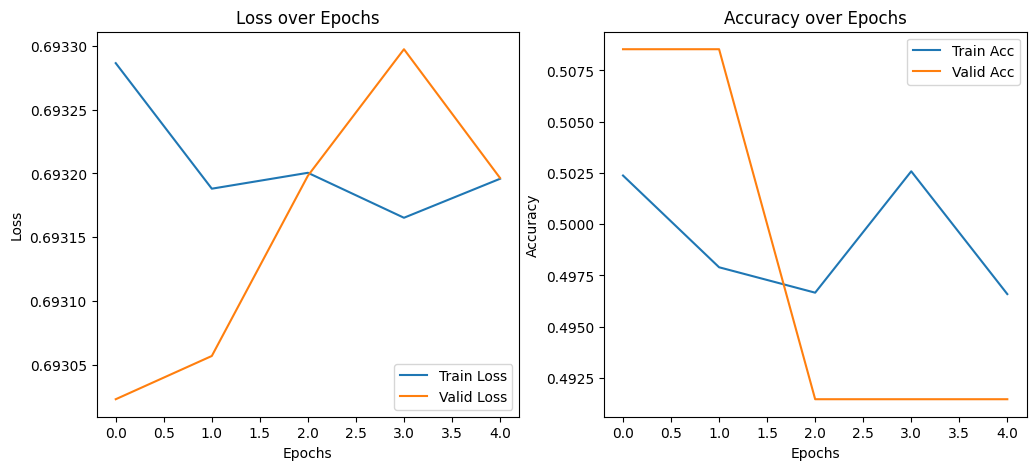

In [18]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(len(valid_losses)), train_losses, label='Train Loss')
plt.plot(range(len(valid_losses)), valid_losses, label='Valid Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss over Epochs')

plt.subplot(1, 2, 2)
plt.plot(range(len(valid_losses)), train_accs, label='Train Acc')
plt.plot(range(len(valid_losses)), valid_accs, label='Valid Acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy over Epochs')

plt.show()

## Next LSTM CELL Default

In [ ]:
# Load and preprocess the dataset
path_to_dataset = "/content/drive/MyDrive/diploma/datasets/HateSpeechDatasetBalanced.csv"
df = pd.read_csv(path_to_dataset)
df = df.sample(frac=0.05, random_state=42)
df = df[['Content', 'Label']]

def preprocess(text):
    return word_tokenize(text.lower())

df['Content'] = df['Content'].apply(preprocess)

### Overwride imports

In [ ]:
middmiddle_term_memory = torch.zeros(1, requires_grad=False)

In [ ]:
def custom_lstm_cell(input, hidden, w_ih, w_hh, b_ih, b_hh):
    global middle_term_memory

    hx, cx = hidden
    gates = torch.mm(input, w_ih.t()) + torch.mm(hx, w_hh.t()) + b_ih + b_hh

    ingate, forgetgate, cellgate, outgate = gates.chunk(4, 1)

    ingate = torch.sigmoid(ingate)
    forgetgate = torch.sigmoid(forgetgate)
    cellgate = torch.tanh(cellgate)
    outgate = torch.sigmoid(outgate)

     # Update middle-term memory
    middle_term_memory = 0.5 * middle_term_memory + 0.5 * cx.mean().detach()


    # cy = (forgetgate * cx) + (ingate * cellgate) + 33
    cy = (forgetgate * cx) + (ingate * cellgate) + middle_term_memory
    hy = outgate * torch.tanh(cy)
    # print("EEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEE")

    return hy, cy

In [ ]:
import math
import numbers
import warnings
import weakref
from typing import List, Optional, overload, Tuple
from typing_extensions import deprecated

import torch
from torch import _VF, Tensor
from torch.nn import init
from torch.nn.parameter import Parameter
from torch.nn.utils.rnn import PackedSequence

Module = nn.Module


__all__ = [
    "RNNBase",
    "RNN",
    "LSTM",
    "GRU",
    "RNNCellBase",
    "RNNCell",
    "LSTMCell",
    "GRUCell",
]

_rnn_impls = {
    "RNN_TANH": _VF.rnn_tanh,
    "RNN_RELU": _VF.rnn_relu,
}


def _apply_permutation(tensor: Tensor, permutation: Tensor, dim: int = 1) -> Tensor:
    return tensor.index_select(dim, permutation)


@deprecated(
    "`apply_permutation` is deprecated, please use `tensor.index_select(dim, permutation)` instead",
    category=FutureWarning,
)
def apply_permutation(tensor: Tensor, permutation: Tensor, dim: int = 1) -> Tensor:
    return _apply_permutation(tensor, permutation, dim)


class RNNBase(Module):
    r"""Base class for RNN modules (RNN, LSTM, GRU).

    Implements aspects of RNNs shared by the RNN, LSTM, and GRU classes, such as module initialization
    and utility methods for parameter storage management.

    .. note::
        The forward method is not implemented by the RNNBase class.

    .. note::
        LSTM and GRU classes override some methods implemented by RNNBase.
    """

    __constants__ = [
        "mode",
        "input_size",
        "hidden_size",
        "num_layers",
        "bias",
        "batch_first",
        "dropout",
        "bidirectional",
        "proj_size",
    ]
    __jit_unused_properties__ = ["all_weights"]

    mode: str
    input_size: int
    hidden_size: int
    num_layers: int
    bias: bool
    batch_first: bool
    dropout: float
    bidirectional: bool
    proj_size: int

    def __init__(
        self,
        mode: str,
        input_size: int,
        hidden_size: int,
        num_layers: int = 1,
        bias: bool = True,
        batch_first: bool = False,
        dropout: float = 0.0,
        bidirectional: bool = False,
        proj_size: int = 0,
        device=None,
        dtype=None,
    ) -> None:
        factory_kwargs = {"device": device, "dtype": dtype}
        super().__init__()
        self.mode = mode
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.bias = bias
        self.batch_first = batch_first
        self.dropout = float(dropout)
        self.bidirectional = bidirectional
        self.proj_size = proj_size
        self._flat_weight_refs: List[Optional[weakref.ReferenceType[Parameter]]] = []
        num_directions = 2 if bidirectional else 1

        if (
            not isinstance(dropout, numbers.Number)
            or not 0 <= dropout <= 1
            or isinstance(dropout, bool)
        ):
            raise ValueError(
                "dropout should be a number in range [0, 1] "
                "representing the probability of an element being "
                "zeroed"
            )
        if dropout > 0 and num_layers == 1:
            warnings.warn(
                "dropout option adds dropout after all but last "
                "recurrent layer, so non-zero dropout expects "
                f"num_layers greater than 1, but got dropout={dropout} and "
                f"num_layers={num_layers}"
            )

        if not isinstance(hidden_size, int):
            raise TypeError(
                f"hidden_size should be of type int, got: {type(hidden_size).__name__}"
            )
        if hidden_size <= 0:
            raise ValueError("hidden_size must be greater than zero")
        if num_layers <= 0:
            raise ValueError("num_layers must be greater than zero")
        if proj_size < 0:
            raise ValueError(
                "proj_size should be a positive integer or zero to disable projections"
            )
        if proj_size >= hidden_size:
            raise ValueError("proj_size has to be smaller than hidden_size")

        if mode == "LSTM":
            gate_size = 4 * hidden_size
        elif mode == "GRU":
            gate_size = 3 * hidden_size
        elif mode == "RNN_TANH":
            gate_size = hidden_size
        elif mode == "RNN_RELU":
            gate_size = hidden_size
        else:
            raise ValueError("Unrecognized RNN mode: " + mode)

        self._flat_weights_names = []
        self._all_weights = []
        for layer in range(num_layers):
            for direction in range(num_directions):
                real_hidden_size = proj_size if proj_size > 0 else hidden_size
                layer_input_size = (
                    input_size if layer == 0 else real_hidden_size * num_directions
                )

                w_ih = Parameter(
                    torch.empty((gate_size, layer_input_size), **factory_kwargs)
                )
                w_hh = Parameter(
                    torch.empty((gate_size, real_hidden_size), **factory_kwargs)
                )
                b_ih = Parameter(torch.empty(gate_size, **factory_kwargs))
                # Second bias vector included for CuDNN compatibility. Only one
                # bias vector is needed in standard definition.
                b_hh = Parameter(torch.empty(gate_size, **factory_kwargs))
                layer_params: Tuple[Tensor, ...] = ()
                if self.proj_size == 0:
                    if bias:
                        layer_params = (w_ih, w_hh, b_ih, b_hh)
                    else:
                        layer_params = (w_ih, w_hh)
                else:
                    w_hr = Parameter(
                        torch.empty((proj_size, hidden_size), **factory_kwargs)
                    )
                    if bias:
                        layer_params = (w_ih, w_hh, b_ih, b_hh, w_hr)
                    else:
                        layer_params = (w_ih, w_hh, w_hr)

                suffix = "_reverse" if direction == 1 else ""
                param_names = ["weight_ih_l{}{}", "weight_hh_l{}{}"]
                if bias:
                    param_names += ["bias_ih_l{}{}", "bias_hh_l{}{}"]
                if self.proj_size > 0:
                    param_names += ["weight_hr_l{}{}"]
                param_names = [x.format(layer, suffix) for x in param_names]

                for name, param in zip(param_names, layer_params):
                    setattr(self, name, param)
                self._flat_weights_names.extend(param_names)
                self._all_weights.append(param_names)

        self._init_flat_weights()

        self.reset_parameters()

    def _init_flat_weights(self):
        self._flat_weights = [
            getattr(self, wn) if hasattr(self, wn) else None
            for wn in self._flat_weights_names
        ]
        self._flat_weight_refs = [
            weakref.ref(w) if w is not None else None for w in self._flat_weights
        ]
        self.flatten_parameters()

    def __setattr__(self, attr, value):
        if hasattr(self, "_flat_weights_names") and attr in self._flat_weights_names:
            # keep self._flat_weights up to date if you do self.weight = ...
            idx = self._flat_weights_names.index(attr)
            self._flat_weights[idx] = value
        super().__setattr__(attr, value)

    def flatten_parameters(self) -> None:
        """Reset parameter data pointer so that they can use faster code paths.

        Right now, this works only if the module is on the GPU and cuDNN is enabled.
        Otherwise, it's a no-op.
        """
        # Short-circuits if _flat_weights is only partially instantiated
        if len(self._flat_weights) != len(self._flat_weights_names):
            return

        for w in self._flat_weights:
            if not isinstance(w, Tensor):
                return
        # Short-circuits if any tensor in self._flat_weights is not acceptable to cuDNN
        # or the tensors in _flat_weights are of different dtypes

        first_fw = self._flat_weights[0]
        dtype = first_fw.dtype
        for fw in self._flat_weights:
            if (
                not isinstance(fw, Tensor)
                or not (fw.dtype == dtype)
                or not fw.is_cuda
                or not torch.backends.cudnn.is_acceptable(fw)
            ):
                return

        # If any parameters alias, we fall back to the slower, copying code path. This is
        # a sufficient check, because overlapping parameter buffers that don't completely
        # alias would break the assumptions of the uniqueness check in
        # Module.named_parameters().
        unique_data_ptrs = {p.data_ptr() for p in self._flat_weights}
        if len(unique_data_ptrs) != len(self._flat_weights):
            return

        with torch.cuda.device_of(first_fw):
            import torch.backends.cudnn.rnn as rnn

            # Note: no_grad() is necessary since _cudnn_rnn_flatten_weight is
            # an inplace operation on self._flat_weights
            with torch.no_grad():
                if torch._use_cudnn_rnn_flatten_weight():
                    num_weights = 4 if self.bias else 2
                    if self.proj_size > 0:
                        num_weights += 1
                    torch._cudnn_rnn_flatten_weight(
                        self._flat_weights,
                        num_weights,
                        self.input_size,
                        rnn.get_cudnn_mode(self.mode),
                        self.hidden_size,
                        self.proj_size,
                        self.num_layers,
                        self.batch_first,
                        bool(self.bidirectional),
                    )

    def _apply(self, fn, recurse=True):
        self._flat_weight_refs = []
        ret = super()._apply(fn, recurse)

        # Resets _flat_weights
        # Note: be v. careful before removing this, as 3rd party device types
        # likely rely on this behavior to properly .to() modules like LSTM.
        self._init_flat_weights()

        return ret

    def reset_parameters(self) -> None:
        stdv = 1.0 / math.sqrt(self.hidden_size) if self.hidden_size > 0 else 0
        for weight in self.parameters():
            init.uniform_(weight, -stdv, stdv)

    def check_input(self, input: Tensor, batch_sizes: Optional[Tensor]) -> None:
        if not torch.jit.is_scripting():
            if (
                input.dtype != self._flat_weights[0].dtype
                and not torch._C._is_any_autocast_enabled()
            ):
                raise ValueError(
                    f"input must have the type {self._flat_weights[0].dtype}, got type {input.dtype}"
                )
        expected_input_dim = 2 if batch_sizes is not None else 3
        if input.dim() != expected_input_dim:
            raise RuntimeError(
                f"input must have {expected_input_dim} dimensions, got {input.dim()}"
            )
        if self.input_size != input.size(-1):
            raise RuntimeError(
                f"input.size(-1) must be equal to input_size. Expected {self.input_size}, got {input.size(-1)}"
            )

    def get_expected_hidden_size(
        self, input: Tensor, batch_sizes: Optional[Tensor]
    ) -> Tuple[int, int, int]:
        if batch_sizes is not None:
            mini_batch = int(batch_sizes[0])
        else:
            mini_batch = input.size(0) if self.batch_first else input.size(1)
        num_directions = 2 if self.bidirectional else 1
        if self.proj_size > 0:
            expected_hidden_size = (
                self.num_layers * num_directions,
                mini_batch,
                self.proj_size,
            )
        else:
            expected_hidden_size = (
                self.num_layers * num_directions,
                mini_batch,
                self.hidden_size,
            )
        return expected_hidden_size

    def check_hidden_size(
        self,
        hx: Tensor,
        expected_hidden_size: Tuple[int, int, int],
        msg: str = "Expected hidden size {}, got {}",
    ) -> None:
        if hx.size() != expected_hidden_size:
            raise RuntimeError(msg.format(expected_hidden_size, list(hx.size())))

    def _weights_have_changed(self):
        # Returns True if the weight tensors have changed since the last forward pass.
        # This is the case when used with torch.func.functional_call(), for example.
        weights_changed = False
        for ref, name in zip(self._flat_weight_refs, self._flat_weights_names):
            weight = getattr(self, name) if hasattr(self, name) else None
            if weight is not None and ref is not None and ref() is not weight:
                weights_changed = True
                break
        return weights_changed

    def check_forward_args(
        self, input: Tensor, hidden: Tensor, batch_sizes: Optional[Tensor]
    ):
        self.check_input(input, batch_sizes)
        expected_hidden_size = self.get_expected_hidden_size(input, batch_sizes)

        self.check_hidden_size(hidden, expected_hidden_size)

    def permute_hidden(self, hx: Tensor, permutation: Optional[Tensor]):
        if permutation is None:
            return hx
        return _apply_permutation(hx, permutation)

    def extra_repr(self) -> str:
        s = "{input_size}, {hidden_size}"
        if self.proj_size != 0:
            s += ", proj_size={proj_size}"
        if self.num_layers != 1:
            s += ", num_layers={num_layers}"
        if self.bias is not True:
            s += ", bias={bias}"
        if self.batch_first is not False:
            s += ", batch_first={batch_first}"
        if self.dropout != 0:
            s += ", dropout={dropout}"
        if self.bidirectional is not False:
            s += ", bidirectional={bidirectional}"
        return s.format(**self.__dict__)

    def _update_flat_weights(self):
        if not torch.jit.is_scripting():
            if self._weights_have_changed():
                self._init_flat_weights()

    def __getstate__(self):
        # If weights have been changed, update the _flat_weights in __getstate__ here.
        self._update_flat_weights()
        # Don't serialize the weight references.
        state = self.__dict__.copy()
        del state["_flat_weight_refs"]
        return state

    def __setstate__(self, d):
        super().__setstate__(d)
        if "all_weights" in d:
            self._all_weights = d["all_weights"]
        # In PyTorch 1.8 we added a proj_size member variable to LSTM.
        # LSTMs that were serialized via torch.save(module) before PyTorch 1.8
        # don't have it, so to preserve compatibility we set proj_size here.
        if "proj_size" not in d:
            self.proj_size = 0

        if not isinstance(self._all_weights[0][0], str):
            num_layers = self.num_layers
            num_directions = 2 if self.bidirectional else 1
            self._flat_weights_names = []
            self._all_weights = []
            for layer in range(num_layers):
                for direction in range(num_directions):
                    suffix = "_reverse" if direction == 1 else ""
                    weights = [
                        "weight_ih_l{}{}",
                        "weight_hh_l{}{}",
                        "bias_ih_l{}{}",
                        "bias_hh_l{}{}",
                        "weight_hr_l{}{}",
                    ]
                    weights = [x.format(layer, suffix) for x in weights]
                    if self.bias:
                        if self.proj_size > 0:
                            self._all_weights += [weights]
                            self._flat_weights_names.extend(weights)
                        else:
                            self._all_weights += [weights[:4]]
                            self._flat_weights_names.extend(weights[:4])
                    else:
                        if self.proj_size > 0:
                            self._all_weights += [weights[:2]] + [weights[-1:]]
                            self._flat_weights_names.extend(
                                weights[:2] + [weights[-1:]]
                            )
                        else:
                            self._all_weights += [weights[:2]]
                            self._flat_weights_names.extend(weights[:2])
            self._flat_weights = [
                getattr(self, wn) if hasattr(self, wn) else None
                for wn in self._flat_weights_names
            ]

        self._flat_weight_refs = [
            weakref.ref(w) if w is not None else None for w in self._flat_weights
        ]

    @property
    def all_weights(self) -> List[List[Parameter]]:
        return [
            [getattr(self, weight) for weight in weights]
            for weights in self._all_weights
        ]

    def _replicate_for_data_parallel(self):
        replica = super()._replicate_for_data_parallel()
        # Need to copy these caches, otherwise the replica will share the same
        # flat weights list.
        replica._flat_weights = replica._flat_weights[:]
        replica._flat_weights_names = replica._flat_weights_names[:]
        return replica


class RNN(RNNBase):

    @overload
    def __init__(
        self,
        input_size: int,
        hidden_size: int,
        num_layers: int = 1,
        nonlinearity: str = "tanh",
        bias: bool = True,
        batch_first: bool = False,
        dropout: float = 0.0,
        bidirectional: bool = False,
        device=None,
        dtype=None,
    ) -> None:
        ...

    @overload
    def __init__(self, *args, **kwargs):
        ...

    def __init__(self, *args, **kwargs):
        if "proj_size" in kwargs:
            raise ValueError(
                "proj_size argument is only supported for LSTM, not RNN or GRU"
            )
        if len(args) > 3:
            self.nonlinearity = args[3]
            args = args[:3] + args[4:]
        else:
            self.nonlinearity = kwargs.pop("nonlinearity", "tanh")
        if self.nonlinearity == "tanh":
            mode = "RNN_TANH"
        elif self.nonlinearity == "relu":
            mode = "RNN_RELU"
        else:
            raise ValueError(
                f"Unknown nonlinearity '{self.nonlinearity}'. Select from 'tanh' or 'relu'."
            )
        super().__init__(mode, *args, **kwargs)

    @overload
    @torch._jit_internal._overload_method  # noqa: F811
    def forward(
        self, input: Tensor, hx: Optional[Tensor] = None
    ) -> Tuple[Tensor, Tensor]:
        pass

    @overload
    @torch._jit_internal._overload_method  # noqa: F811
    def forward(
        self, input: PackedSequence, hx: Optional[Tensor] = None
    ) -> Tuple[PackedSequence, Tensor]:
        pass

    def forward(self, input, hx=None):  # noqa: F811
        self._update_flat_weights()

        num_directions = 2 if self.bidirectional else 1
        orig_input = input

        if isinstance(orig_input, PackedSequence):
            input, batch_sizes, sorted_indices, unsorted_indices = input
            max_batch_size = batch_sizes[0]
            # script() is unhappy when max_batch_size is different type in cond branches, so we duplicate
            if hx is None:
                hx = torch.zeros(
                    self.num_layers * num_directions,
                    max_batch_size,
                    self.hidden_size,
                    dtype=input.dtype,
                    device=input.device,
                )
            else:
                # Each batch of the hidden state should match the input sequence that
                # the user believes he/she is passing in.
                hx = self.permute_hidden(hx, sorted_indices)
        else:
            batch_sizes = None
            if input.dim() not in (2, 3):
                raise ValueError(
                    f"RNN: Expected input to be 2D or 3D, got {input.dim()}D tensor instead"
                )
            is_batched = input.dim() == 3
            batch_dim = 0 if self.batch_first else 1
            if not is_batched:
                input = input.unsqueeze(batch_dim)
                if hx is not None:
                    if hx.dim() != 2:
                        raise RuntimeError(
                            f"For unbatched 2-D input, hx should also be 2-D but got {hx.dim()}-D tensor"
                        )
                    hx = hx.unsqueeze(1)
            else:
                if hx is not None and hx.dim() != 3:
                    raise RuntimeError(
                        f"For batched 3-D input, hx should also be 3-D but got {hx.dim()}-D tensor"
                    )
            max_batch_size = input.size(0) if self.batch_first else input.size(1)
            sorted_indices = None
            unsorted_indices = None
            if hx is None:
                hx = torch.zeros(
                    self.num_layers * num_directions,
                    max_batch_size,
                    self.hidden_size,
                    dtype=input.dtype,
                    device=input.device,
                )
            else:
                # Each batch of the hidden state should match the input sequence that
                # the user believes he/she is passing in.
                hx = self.permute_hidden(hx, sorted_indices)

        assert hx is not None
        self.check_forward_args(input, hx, batch_sizes)
        assert self.mode == "RNN_TANH" or self.mode == "RNN_RELU"
        if batch_sizes is None:
            if self.mode == "RNN_TANH":
                result = _VF.rnn_tanh(
                    input,
                    hx,
                    self._flat_weights,
                    self.bias,
                    self.num_layers,
                    self.dropout,
                    self.training,
                    self.bidirectional,
                    self.batch_first,
                )
            else:
                result = _VF.rnn_relu(
                    input,
                    hx,
                    self._flat_weights,
                    self.bias,
                    self.num_layers,
                    self.dropout,
                    self.training,
                    self.bidirectional,
                    self.batch_first,
                )
        else:
            if self.mode == "RNN_TANH":
                result = _VF.rnn_tanh(
                    input,
                    batch_sizes,
                    hx,
                    self._flat_weights,
                    self.bias,
                    self.num_layers,
                    self.dropout,
                    self.training,
                    self.bidirectional,
                )
            else:
                result = _VF.rnn_relu(
                    input,
                    batch_sizes,
                    hx,
                    self._flat_weights,
                    self.bias,
                    self.num_layers,
                    self.dropout,
                    self.training,
                    self.bidirectional,
                )

        output = result[0]
        hidden = result[1]

        if isinstance(orig_input, PackedSequence):
            output_packed = PackedSequence(
                output, batch_sizes, sorted_indices, unsorted_indices
            )
            return output_packed, self.permute_hidden(hidden, unsorted_indices)

        if not is_batched:  # type: ignore[possibly-undefined]
            output = output.squeeze(batch_dim)  # type: ignore[possibly-undefined]
            hidden = hidden.squeeze(1)

        return output, self.permute_hidden(hidden, unsorted_indices)


class LSTM(RNNBase):
    @overload
    def __init__(
        self,
        input_size: int,
        hidden_size: int,
        num_layers: int = 1,
        bias: bool = True,
        batch_first: bool = False,
        dropout: float = 0.0,
        bidirectional: bool = False,
        proj_size: int = 0,
        device=None,
        dtype=None,
    ) -> None:
        ...

    @overload
    def __init__(self, *args, **kwargs):
        ...

    def __init__(self, *args, **kwargs):
        super().__init__("LSTM", *args, **kwargs)

    def get_expected_cell_size(
        self, input: Tensor, batch_sizes: Optional[Tensor]
    ) -> Tuple[int, int, int]:
        if batch_sizes is not None:
            mini_batch = int(batch_sizes[0])
        else:
            mini_batch = input.size(0) if self.batch_first else input.size(1)
        num_directions = 2 if self.bidirectional else 1
        expected_hidden_size = (
            self.num_layers * num_directions,
            mini_batch,
            self.hidden_size,
        )
        return expected_hidden_size

    # In the future, we should prevent mypy from applying contravariance rules here.
    # See torch/nn/modules/module.py::_forward_unimplemented
    def check_forward_args(
        self,
        input: Tensor,
        hidden: Tuple[Tensor, Tensor],  # type: ignore[override]
        batch_sizes: Optional[Tensor],
    ):
        self.check_input(input, batch_sizes)
        self.check_hidden_size(
            hidden[0],
            self.get_expected_hidden_size(input, batch_sizes),
            "Expected hidden[0] size {}, got {}",
        )
        self.check_hidden_size(
            hidden[1],
            self.get_expected_cell_size(input, batch_sizes),
            "Expected hidden[1] size {}, got {}",
        )

    # Same as above, see torch/nn/modules/module.py::_forward_unimplemented
    def permute_hidden(  # type: ignore[override]
        self,
        hx: Tuple[Tensor, Tensor],
        permutation: Optional[Tensor],
    ) -> Tuple[Tensor, Tensor]:
        if permutation is None:
            return hx
        return _apply_permutation(hx[0], permutation), _apply_permutation(
            hx[1], permutation
        )

    # Same as above, see torch/nn/modules/module.py::_forward_unimplemented
    @overload  # type: ignore[override]
    @torch._jit_internal._overload_method  # noqa: F811
    def forward(
        self, input: Tensor, hx: Optional[Tuple[Tensor, Tensor]] = None
    ) -> Tuple[Tensor, Tuple[Tensor, Tensor]]:  # noqa: F811
        pass

    # Same as above, see torch/nn/modules/module.py::_forward_unimplemented
    @overload
    @torch._jit_internal._overload_method  # noqa: F811
    def forward(
        self, input: PackedSequence, hx: Optional[Tuple[Tensor, Tensor]] = None
    ) -> Tuple[PackedSequence, Tuple[Tensor, Tensor]]:  # noqa: F811
        pass

    def forward(self, input, hx=None):  # noqa: F811
        self._update_flat_weights()

        orig_input = input
        # xxx: isinstance check needs to be in conditional for TorchScript to compile
        batch_sizes = None
        do_permute = False
        num_directions = 2 if self.bidirectional else 1
        real_hidden_size = self.proj_size if self.proj_size > 0 else self.hidden_size
        if isinstance(orig_input, PackedSequence):
            input, batch_sizes, sorted_indices, unsorted_indices = input
            max_batch_size = batch_sizes[0]
            if hx is None:
                h_zeros = torch.zeros(
                    self.num_layers * num_directions,
                    max_batch_size,
                    real_hidden_size,
                    dtype=input.dtype,
                    device=input.device,
                )
                c_zeros = torch.zeros(
                    self.num_layers * num_directions,
                    max_batch_size,
                    self.hidden_size,
                    dtype=input.dtype,
                    device=input.device,
                )
                hx = (h_zeros, c_zeros)
            else:
                # Each batch of the hidden state should match the input sequence that
                # the user believes he/she is passing in.
                hx = self.permute_hidden(hx, sorted_indices)
        else:
            if input.dim() not in (2, 3):
                raise ValueError(
                    f"LSTM: Expected input to be 2D or 3D, got {input.dim()}D instead"
                )
            is_batched = input.dim() == 3
            batch_dim = 0 if self.batch_first else 1
            if not is_batched:
                input = input.unsqueeze(batch_dim)
            max_batch_size = input.size(0) if self.batch_first else input.size(1)
            sorted_indices = None
            unsorted_indices = None
            if hx is None:
                h_zeros = torch.zeros(
                    self.num_layers * num_directions,
                    max_batch_size,
                    real_hidden_size,
                    dtype=input.dtype,
                    device=input.device,
                )
                c_zeros = torch.zeros(
                    self.num_layers * num_directions,
                    max_batch_size,
                    self.hidden_size,
                    dtype=input.dtype,
                    device=input.device,
                )
                hx = (h_zeros, c_zeros)
                self.check_forward_args(input, hx, batch_sizes)
            else:
                if is_batched:
                    if hx[0].dim() != 3 or hx[1].dim() != 3:
                        msg = (
                            "For batched 3-D input, hx and cx should "
                            f"also be 3-D but got ({hx[0].dim()}-D, {hx[1].dim()}-D) tensors"
                        )
                        raise RuntimeError(msg)
                else:
                    if hx[0].dim() != 2 or hx[1].dim() != 2:
                        msg = (
                            "For unbatched 2-D input, hx and cx should "
                            f"also be 2-D but got ({hx[0].dim()}-D, {hx[1].dim()}-D) tensors"
                        )
                        raise RuntimeError(msg)
                    hx = (hx[0].unsqueeze(1), hx[1].unsqueeze(1))
                # Each batch of the hidden state should match the input sequence that
                # the user believes he/she is passing in.
                self.check_forward_args(input, hx, batch_sizes)
                hx = self.permute_hidden(hx, sorted_indices)

        if batch_sizes is None:
            result = _VF.lstm(
                input,
                hx,
                self._flat_weights,
                self.bias,
                self.num_layers,
                self.dropout,
                self.training,
                self.bidirectional,
                self.batch_first,
            )
        else:
            result = _VF.lstm(
                input,
                batch_sizes,
                hx,
                self._flat_weights,
                self.bias,
                self.num_layers,
                self.dropout,
                self.training,
                self.bidirectional,
            )
        output = result[0]
        hidden = result[1:]
        # xxx: isinstance check needs to be in conditional for TorchScript to compile
        if isinstance(orig_input, PackedSequence):
            output_packed = PackedSequence(
                output, batch_sizes, sorted_indices, unsorted_indices
            )
            return output_packed, self.permute_hidden(hidden, unsorted_indices)
        else:
            if not is_batched:  # type: ignore[possibly-undefined]
                output = output.squeeze(batch_dim)  # type: ignore[possibly-undefined]
                hidden = (hidden[0].squeeze(1), hidden[1].squeeze(1))
            return output, self.permute_hidden(hidden, unsorted_indices)


class GRU(RNNBase):
    @overload
    def __init__(
        self,
        input_size: int,
        hidden_size: int,
        num_layers: int = 1,
        bias: bool = True,
        batch_first: bool = False,
        dropout: float = 0.0,
        bidirectional: bool = False,
        device=None,
        dtype=None,
    ) -> None:
        ...

    @overload
    def __init__(self, *args, **kwargs):
        ...

    def __init__(self, *args, **kwargs):
        if "proj_size" in kwargs:
            raise ValueError(
                "proj_size argument is only supported for LSTM, not RNN or GRU"
            )
        super().__init__("GRU", *args, **kwargs)

    @overload  # type: ignore[override]
    @torch._jit_internal._overload_method  # noqa: F811
    def forward(
        self, input: Tensor, hx: Optional[Tensor] = None
    ) -> Tuple[Tensor, Tensor]:  # noqa: F811
        pass

    @overload
    @torch._jit_internal._overload_method  # noqa: F811
    def forward(
        self, input: PackedSequence, hx: Optional[Tensor] = None
    ) -> Tuple[PackedSequence, Tensor]:  # noqa: F811
        pass

    def forward(self, input, hx=None):  # noqa: F811
        self._update_flat_weights()

        orig_input = input
        # xxx: isinstance check needs to be in conditional for TorchScript to compile
        if isinstance(orig_input, PackedSequence):
            input, batch_sizes, sorted_indices, unsorted_indices = input
            max_batch_size = batch_sizes[0]
            if hx is None:
                num_directions = 2 if self.bidirectional else 1
                hx = torch.zeros(
                    self.num_layers * num_directions,
                    max_batch_size,
                    self.hidden_size,
                    dtype=input.dtype,
                    device=input.device,
                )
            else:
                # Each batch of the hidden state should match the input sequence that
                # the user believes he/she is passing in.
                hx = self.permute_hidden(hx, sorted_indices)
        else:
            batch_sizes = None
            if input.dim() not in (2, 3):
                raise ValueError(
                    f"GRU: Expected input to be 2D or 3D, got {input.dim()}D instead"
                )
            is_batched = input.dim() == 3
            batch_dim = 0 if self.batch_first else 1
            if not is_batched:
                input = input.unsqueeze(batch_dim)
                if hx is not None:
                    if hx.dim() != 2:
                        raise RuntimeError(
                            f"For unbatched 2-D input, hx should also be 2-D but got {hx.dim()}-D tensor"
                        )
                    hx = hx.unsqueeze(1)
            else:
                if hx is not None and hx.dim() != 3:
                    raise RuntimeError(
                        f"For batched 3-D input, hx should also be 3-D but got {hx.dim()}-D tensor"
                    )
            max_batch_size = input.size(0) if self.batch_first else input.size(1)
            sorted_indices = None
            unsorted_indices = None
            if hx is None:
                num_directions = 2 if self.bidirectional else 1
                hx = torch.zeros(
                    self.num_layers * num_directions,
                    max_batch_size,
                    self.hidden_size,
                    dtype=input.dtype,
                    device=input.device,
                )
            else:
                # Each batch of the hidden state should match the input sequence that
                # the user believes he/she is passing in.
                hx = self.permute_hidden(hx, sorted_indices)

        self.check_forward_args(input, hx, batch_sizes)
        if batch_sizes is None:
            result = _VF.gru(
                input,
                hx,
                self._flat_weights,
                self.bias,
                self.num_layers,
                self.dropout,
                self.training,
                self.bidirectional,
                self.batch_first,
            )
        else:
            result = _VF.gru(
                input,
                batch_sizes,
                hx,
                self._flat_weights,
                self.bias,
                self.num_layers,
                self.dropout,
                self.training,
                self.bidirectional,
            )
        output = result[0]
        hidden = result[1]

        # xxx: isinstance check needs to be in conditional for TorchScript to compile
        if isinstance(orig_input, PackedSequence):
            output_packed = PackedSequence(
                output, batch_sizes, sorted_indices, unsorted_indices
            )
            return output_packed, self.permute_hidden(hidden, unsorted_indices)
        else:
            if not is_batched:  # type: ignore[possibly-undefined]
                output = output.squeeze(batch_dim)  # type: ignore[possibly-undefined]
                hidden = hidden.squeeze(1)

            return output, self.permute_hidden(hidden, unsorted_indices)


class RNNCellBase(Module):
    __constants__ = ["input_size", "hidden_size", "bias"]

    input_size: int
    hidden_size: int
    bias: bool
    weight_ih: Tensor
    weight_hh: Tensor
    # WARNING: bias_ih and bias_hh purposely not defined here.
    # See https://github.com/pytorch/pytorch/issues/39670

    def __init__(
        self,
        input_size: int,
        hidden_size: int,
        bias: bool,
        num_chunks: int,
        device=None,
        dtype=None,
    ) -> None:
        factory_kwargs = {"device": device, "dtype": dtype}
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.bias = bias
        self.weight_ih = Parameter(
            torch.empty((num_chunks * hidden_size, input_size), **factory_kwargs)
        )
        self.weight_hh = Parameter(
            torch.empty((num_chunks * hidden_size, hidden_size), **factory_kwargs)
        )
        if bias:
            self.bias_ih = Parameter(
                torch.empty(num_chunks * hidden_size, **factory_kwargs)
            )
            self.bias_hh = Parameter(
                torch.empty(num_chunks * hidden_size, **factory_kwargs)
            )
        else:
            self.register_parameter("bias_ih", None)
            self.register_parameter("bias_hh", None)

        self.reset_parameters()

    def extra_repr(self) -> str:
        s = "{input_size}, {hidden_size}"
        if "bias" in self.__dict__ and self.bias is not True:
            s += ", bias={bias}"
        if "nonlinearity" in self.__dict__ and self.nonlinearity != "tanh":
            s += ", nonlinearity={nonlinearity}"
        return s.format(**self.__dict__)

    def reset_parameters(self) -> None:
        stdv = 1.0 / math.sqrt(self.hidden_size) if self.hidden_size > 0 else 0
        for weight in self.parameters():
            init.uniform_(weight, -stdv, stdv)


class RNNCell(RNNCellBase):
    r"""An Elman RNN cell with tanh or ReLU non-linearity.

    .. math::

        h' = \tanh(W_{ih} x + b_{ih}  +  W_{hh} h + b_{hh})

    If :attr:`nonlinearity` is `'relu'`, then ReLU is used in place of tanh.

    Args:
        input_size: The number of expected features in the input `x`
        hidden_size: The number of features in the hidden state `h`
        bias: If ``False``, then the layer does not use bias weights `b_ih` and `b_hh`.
            Default: ``True``
        nonlinearity: The non-linearity to use. Can be either ``'tanh'`` or ``'relu'``. Default: ``'tanh'``

    Inputs: input, hidden
        - **input**: tensor containing input features
        - **hidden**: tensor containing the initial hidden state
          Defaults to zero if not provided.

    Outputs: h'
        - **h'** of shape `(batch, hidden_size)`: tensor containing the next hidden state
          for each element in the batch

    Shape:
        - input: :math:`(N, H_{in})` or :math:`(H_{in})` tensor containing input features where
          :math:`H_{in}` = `input_size`.
        - hidden: :math:`(N, H_{out})` or :math:`(H_{out})` tensor containing the initial hidden
          state where :math:`H_{out}` = `hidden_size`. Defaults to zero if not provided.
        - output: :math:`(N, H_{out})` or :math:`(H_{out})` tensor containing the next hidden state.

    Attributes:
        weight_ih: the learnable input-hidden weights, of shape
            `(hidden_size, input_size)`
        weight_hh: the learnable hidden-hidden weights, of shape
            `(hidden_size, hidden_size)`
        bias_ih: the learnable input-hidden bias, of shape `(hidden_size)`
        bias_hh: the learnable hidden-hidden bias, of shape `(hidden_size)`

    .. note::
        All the weights and biases are initialized from :math:`\mathcal{U}(-\sqrt{k}, \sqrt{k})`
        where :math:`k = \frac{1}{\text{hidden\_size}}`

    Examples::

        >>> rnn = nn.RNNCell(10, 20)
        >>> input = torch.randn(6, 3, 10)
        >>> hx = torch.randn(3, 20)
        >>> output = []
        >>> for i in range(6):
        ...     hx = rnn(input[i], hx)
        ...     output.append(hx)
    """

    __constants__ = ["input_size", "hidden_size", "bias", "nonlinearity"]
    nonlinearity: str

    def __init__(
        self,
        input_size: int,
        hidden_size: int,
        bias: bool = True,
        nonlinearity: str = "tanh",
        device=None,
        dtype=None,
    ) -> None:
        factory_kwargs = {"device": device, "dtype": dtype}
        super().__init__(input_size, hidden_size, bias, num_chunks=1, **factory_kwargs)
        self.nonlinearity = nonlinearity

    def forward(self, input: Tensor, hx: Optional[Tensor] = None) -> Tensor:
        if input.dim() not in (1, 2):
            raise ValueError(
                f"RNNCell: Expected input to be 1D or 2D, got {input.dim()}D instead"
            )
        if hx is not None and hx.dim() not in (1, 2):
            raise ValueError(
                f"RNNCell: Expected hidden to be 1D or 2D, got {hx.dim()}D instead"
            )
        is_batched = input.dim() == 2
        if not is_batched:
            input = input.unsqueeze(0)

        if hx is None:
            hx = torch.zeros(
                input.size(0), self.hidden_size, dtype=input.dtype, device=input.device
            )
        else:
            hx = hx.unsqueeze(0) if not is_batched else hx

        if self.nonlinearity == "tanh":
            ret = _VF.rnn_tanh_cell(
                input,
                hx,
                self.weight_ih,
                self.weight_hh,
                self.bias_ih,
                self.bias_hh,
            )
        elif self.nonlinearity == "relu":
            ret = _VF.rnn_relu_cell(
                input,
                hx,
                self.weight_ih,
                self.weight_hh,
                self.bias_ih,
                self.bias_hh,
            )
        else:
            ret = input  # TODO: remove when jit supports exception flow
            raise RuntimeError(f"Unknown nonlinearity: {self.nonlinearity}")

        if not is_batched:
            ret = ret.squeeze(0)

        return ret


class LSTMCell(RNNCellBase):
    def __init__(
        self,
        input_size: int,
        hidden_size: int,
        bias: bool = True,
        device=None,
        dtype=None,
    ) -> None:
        factory_kwargs = {"device": device, "dtype": dtype}
        super().__init__(input_size, hidden_size, bias, num_chunks=4, **factory_kwargs)

    def forward(
        self, input: Tensor, hx: Optional[Tuple[Tensor, Tensor]] = None
    ) -> Tuple[Tensor, Tensor]:
        # ptint("LSTMCELL FFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFO")
        if input.dim() not in (1, 2):
            raise ValueError(
                f"LSTMCell: Expected input to be 1D or 2D, got {input.dim()}D instead"
            )
        if hx is not None:
            for idx, value in enumerate(hx):
                if value.dim() not in (1, 2):
                    raise ValueError(
                        f"LSTMCell: Expected hx[{idx}] to be 1D or 2D, got {value.dim()}D instead"
                    )
        is_batched = input.dim() == 2
        if not is_batched:
            input = input.unsqueeze(0)

        if hx is None:
            zeros = torch.zeros(
                input.size(0), self.hidden_size, dtype=input.dtype, device=input.device
            )
            hx = (zeros, zeros)
        else:
            hx = (hx[0].unsqueeze(0), hx[1].unsqueeze(0)) if not is_batched else hx

        ret = custom_lstm_cell(
            input,
            hx,
            self.weight_ih,
            self.weight_hh,
            self.bias_ih,
            self.bias_hh,
        )

        if not is_batched:
            ret = (ret[0].squeeze(0), ret[1].squeeze(0))
        return ret


class GRUCell(RNNCellBase):
    r"""A gated recurrent unit (GRU) cell.

    .. math::

        \begin{array}{ll}
        r = \sigma(W_{ir} x + b_{ir} + W_{hr} h + b_{hr}) \\
        z = \sigma(W_{iz} x + b_{iz} + W_{hz} h + b_{hz}) \\
        n = \tanh(W_{in} x + b_{in} + r \odot (W_{hn} h + b_{hn})) \\
        h' = (1 - z) \odot n + z \odot h
        \end{array}

    where :math:`\sigma` is the sigmoid function, and :math:`\odot` is the Hadamard product.

    Args:
        input_size: The number of expected features in the input `x`
        hidden_size: The number of features in the hidden state `h`
        bias: If ``False``, then the layer does not use bias weights `b_ih` and
            `b_hh`. Default: ``True``

    Inputs: input, hidden
        - **input** : tensor containing input features
        - **hidden** : tensor containing the initial hidden
          state for each element in the batch.
          Defaults to zero if not provided.

    Outputs: h'
        - **h'** : tensor containing the next hidden state
          for each element in the batch

    Shape:
        - input: :math:`(N, H_{in})` or :math:`(H_{in})` tensor containing input features where
          :math:`H_{in}` = `input_size`.
        - hidden: :math:`(N, H_{out})` or :math:`(H_{out})` tensor containing the initial hidden
          state where :math:`H_{out}` = `hidden_size`. Defaults to zero if not provided.
        - output: :math:`(N, H_{out})` or :math:`(H_{out})` tensor containing the next hidden state.

    Attributes:
        weight_ih: the learnable input-hidden weights, of shape
            `(3*hidden_size, input_size)`
        weight_hh: the learnable hidden-hidden weights, of shape
            `(3*hidden_size, hidden_size)`
        bias_ih: the learnable input-hidden bias, of shape `(3*hidden_size)`
        bias_hh: the learnable hidden-hidden bias, of shape `(3*hidden_size)`

    .. note::
        All the weights and biases are initialized from :math:`\mathcal{U}(-\sqrt{k}, \sqrt{k})`
        where :math:`k = \frac{1}{\text{hidden\_size}}`

    On certain ROCm devices, when using float16 inputs this module will use :ref:`different precision<fp16_on_mi200>` for backward.

    Examples::

        >>> rnn = nn.GRUCell(10, 20)
        >>> input = torch.randn(6, 3, 10)
        >>> hx = torch.randn(3, 20)
        >>> output = []
        >>> for i in range(6):
        ...     hx = rnn(input[i], hx)
        ...     output.append(hx)
    """

    def __init__(
        self,
        input_size: int,
        hidden_size: int,
        bias: bool = True,
        device=None,
        dtype=None,
    ) -> None:
        factory_kwargs = {"device": device, "dtype": dtype}
        super().__init__(input_size, hidden_size, bias, num_chunks=3, **factory_kwargs)

    def forward(self, input: Tensor, hx: Optional[Tensor] = None) -> Tensor:
        if input.dim() not in (1, 2):
            raise ValueError(
                f"GRUCell: Expected input to be 1D or 2D, got {input.dim()}D instead"
            )
        if hx is not None and hx.dim() not in (1, 2):
            raise ValueError(
                f"GRUCell: Expected hidden to be 1D or 2D, got {hx.dim()}D instead"
            )
        is_batched = input.dim() == 2
        if not is_batched:
            input = input.unsqueeze(0)

        if hx is None:
            hx = torch.zeros(
                input.size(0), self.hidden_size, dtype=input.dtype, device=input.device
            )
        else:
            hx = hx.unsqueeze(0) if not is_batched else hx

        ret = _VF.gru_cell(
            input,
            hx,
            self.weight_ih,
            self.weight_hh,
            self.bias_ih,
            self.bias_hh,
        )

        if not is_batched:
            ret = ret.squeeze(0)

        return ret

### To Do

In [ ]:
# Split the dataset into training and testing sets
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

# Build vocabulary
all_words = [word for tweet in train_df['Content'] for word in tweet]
vocab = sorted(set(all_words))
word_to_idx = {word: idx+1 for idx, word in enumerate(vocab)}
vocab_size = len(vocab) + 1  # +1 for padding index

# Encode tweets
def encode_tweet(tweet):
    return [word_to_idx[word] for word in tweet if word in word_to_idx]

train_df['Content'] = train_df['Content'].apply(encode_tweet)
test_df['Content'] = test_df['Content'].apply(encode_tweet)

# Pad sequences
def pad_sequences(sequences, max_len):
    return np.array([seq + [0]*(max_len-len(seq)) if len(seq) < max_len else seq[:max_len] for seq in sequences])

MAX_LEN = 100
X_train = pad_sequences(train_df['Content'], MAX_LEN)
X_test = pad_sequences(test_df['Content'], MAX_LEN)

# Encode labels
le = LabelEncoder()
y_train = le.fit_transform(train_df['Label'])
y_test = le.transform(test_df['Label'])

# Create Dataset and DataLoader
class HateSpeechDataset(Dataset):
    def __init__(self, tweets, labels):
        self.tweets = tweets
        self.labels = labels

    def __len__(self):
        return len(self.tweets)

    def __getitem__(self, idx):
        return torch.tensor(self.tweets[idx]), torch.tensor(self.labels[idx])

train_dataset = HateSpeechDataset(X_train, y_train)
test_dataset = HateSpeechDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64)

# Define the LSTM model using nn.LSTMCell
class LSTMModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim):
        super(LSTMModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm_cell = LSTMCell(embedding_dim, hidden_dim)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.hidden_dim = hidden_dim

    def forward(self, x):
        batch_size, seq_len = x.size()
        embedded = self.embedding(x)  # [batch_size, sequence_length, embedding_dim]

        h_t = torch.zeros(batch_size, self.hidden_dim, device=x.device)  # Hidden state
        c_t = torch.zeros(batch_size, self.hidden_dim, device=x.device)  # Cell state

        for t in range(seq_len):
            h_t, c_t = self.lstm_cell(embedded[:, t, :], (h_t, c_t))

        out = self.fc(h_t)  # Output from the last hidden state
        return out

# Hyperparameters
embedding_dim = 100
hidden_dim = 128
output_dim = 2  # Number of classes
learning_rate = 0.001

# Initialize the model, loss function, and optimizer
model = LSTMModel(vocab_size, embedding_dim, hidden_dim, output_dim)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

def calculate_accuracy(outputs, targets):
    preds = outputs.argmax(dim=1)
    correct = (preds == targets).float()
    acc = correct.sum() / len(correct)
    return acc

def train(model, train_loader, optimizer, criterion):
    model.train()
    epoch_loss = 0
    epoch_acc = 0

    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs, hidden = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward(retain_graph=True)  # Specify retain_graph=True if needed
        optimizer.step()

        epoch_loss += loss.item()
        epoch_acc += calculate_accuracy(outputs, targets)

    return epoch_loss / len(train_loader), epoch_acc / len(train_loader)

def evaluate(model, data_loader, criterion):
    model.eval()
    epoch_loss = 0
    epoch_acc = 0

    with torch.no_grad():
        for inputs, targets in data_loader:
            outputs, hidden = model(inputs)
            loss = criterion(outputs, targets)

            epoch_loss += loss.item()
            epoch_acc += calculate_accuracy(outputs, targets)

    return epoch_loss / len(data_loader), epoch_acc / len(data_loader)


# Training function
# def train(model, dataloader, optimizer, criterion):
#     model.train()
#     total_loss = 0
#     correct = 0
#     total = 0

#     for inputs, labels in tqdm(dataloader, desc="Training", leave=False):
#         optimizer.zero_grad()
#         outputs = model(inputs)
#         loss = criterion(outputs, labels)
#         loss.backward()
#         optimizer.step()

#         total_loss += loss.item()
#         _, predicted = torch.max(outputs, 1)
#         total += labels.size(0)
#         correct += (predicted == labels).sum().item()

#     avg_loss = total_loss / len(dataloader)
#     accuracy = correct / total
#     return avg_loss, accuracy

# # Evaluation function
# def evaluate(model, dataloader, criterion):
#     model.eval()
#     total_loss = 0
#     correct = 0
#     total = 0

#     with torch.no_grad():
#         for inputs, labels in tqdm(dataloader, desc="Evaluating", leave=False):
#             outputs = model(inputs)
#             loss = criterion(outputs, labels)

#             total_loss += loss.item()
#             _, predicted = torch.max(outputs, 1)
#             total += labels.size(0)
#             correct += (predicted == labels).sum().item()

#     avg_loss = total_loss / len(dataloader)
#     accuracy = correct / total
#     return avg_loss, accuracy

In [ ]:
# Train the model
N_EPOCHS = 5
train_losses = []
valid_losses = []
train_accs = []
valid_accs = []

for epoch in range(N_EPOCHS):
    print(f'\nEpoch: {epoch+1}')
    train_loss, train_acc = train(model, train_loader, optimizer, criterion)
    valid_loss, valid_acc = evaluate(model, test_loader, criterion)

    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    train_accs.append(train_acc)
    valid_accs.append(valid_acc)

    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')


Epoch: 1


ValueError: too many values to unpack (expected 2)

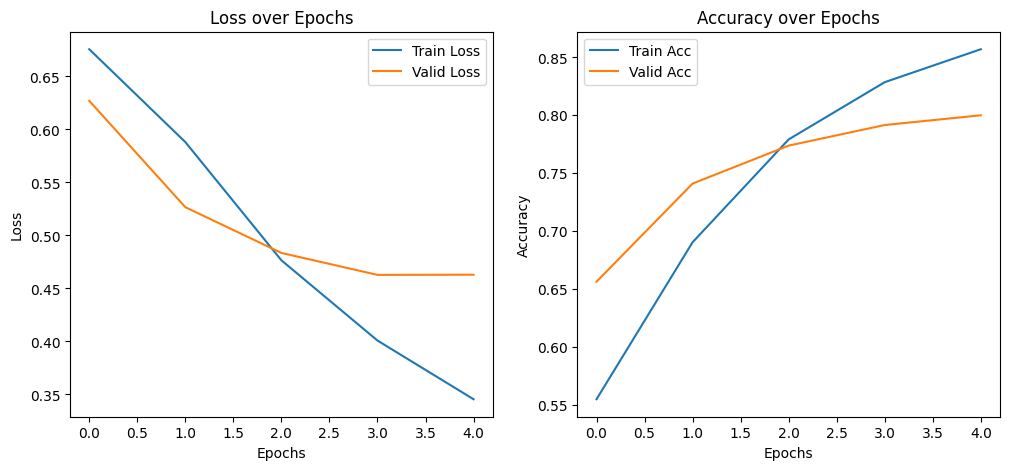

In [ ]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(len(valid_losses)), train_losses, label='Train Loss')
plt.plot(range(len(valid_losses)), valid_losses, label='Valid Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss over Epochs')

plt.subplot(1, 2, 2)
plt.plot(range(len(valid_losses)), train_accs, label='Train Acc')
plt.plot(range(len(valid_losses)), valid_accs, label='Valid Acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy over Epochs')

plt.show()

## NXT

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from nltk.tokenize import word_tokenize
from tqdm import tqdm

# Load and preprocess the dataset
path_to_dataset = "/content/drive/MyDrive/diploma/datasets/HateSpeechDatasetBalanced.csv"
df = pd.read_csv(path_to_dataset)
df = df.sample(frac=0.05, random_state=42)
df = df[['Content', 'Label']]

def preprocess(text):
    return word_tokenize(text.lower())

df['Content'] = df['Content'].apply(preprocess)


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from nltk.tokenize import word_tokenize
from tqdm import tqdm

# Load and preprocess the dataset
path_to_dataset = "/content/drive/MyDrive/diploma/datasets/HateSpeechDatasetBalanced.csv"
df = pd.read_csv(path_to_dataset)
df = df.sample(frac=0.05, random_state=42)
df = df[['Content', 'Label']]

def preprocess(text):
    return word_tokenize(text.lower())

df['Content'] = df['Content'].apply(preprocess)

# Split the dataset into training and testing sets
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

# Build vocabulary
all_words = [word for tweet in train_df['Content'] for word in tweet]
vocab = sorted(set(all_words))
word_to_idx = {word: idx+1 for idx, word in enumerate(vocab)}
vocab_size = len(vocab) + 1  # +1 for padding index

# Encode tweets
def encode_tweet(tweet):
    return [word_to_idx[word] for word in tweet if word in word_to_idx]

train_df['Content'] = train_df['Content'].apply(encode_tweet)
test_df['Content'] = test_df['Content'].apply(encode_tweet)

# Pad sequences
def pad_sequences(sequences, max_len):
    return np.array([seq + [0]*(max_len-len(seq)) if len(seq) < max_len else seq[:max_len] for seq in sequences])

MAX_LEN = 100
X_train = pad_sequences(train_df['Content'], MAX_LEN)
X_test = pad_sequences(test_df['Content'], MAX_LEN)

# Encode labels
le = LabelEncoder()
y_train = le.fit_transform(train_df['Label'])
y_test = le.transform(test_df['Label'])

# Create Dataset and DataLoader
class HateSpeechDataset(Dataset):
    def __init__(self, tweets, labels):
        self.tweets = tweets
        self.labels = labels

    def __len__(self):
        return len(self.tweets)

    def __getitem__(self, idx):
        return torch.tensor(self.tweets[idx]), torch.tensor(self.labels[idx])

train_dataset = HateSpeechDataset(X_train, y_train)
test_dataset = HateSpeechDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64)

# Global variable for middle-term memory
middle_term_memory = torch.zeros(1, requires_grad=False)

def custom_lstm_cell(input, hidden, w_ih, w_hh, b_ih, b_hh):
    global middle_term_memory

    hx, cx = hidden

    # Ensure input is 2D: (batch_size, input_size)
    if input.dim() == 1:
        input = input.unsqueeze(0)

    gates = torch.mm(input, w_ih.t()) + torch.mm(hx, w_hh.t()) + b_ih + b_hh

    ingate, forgetgate, cellgate, outgate = gates.chunk(4, 1)

    ingate = torch.sigmoid(ingate)
    forgetgate = torch.sigmoid(forgetgate)
    cellgate = torch.tanh(cellgate)
    outgate = torch.sigmoid(outgate)

    # Update middle-term memory
    # middle_term_memory = 0.5 * middle_term_memory + 0.5 * cx.mean().detach()

    cy = (forgetgate * cx) + (ingate * cellgate) #  + middle_term_memory
    hy = outgate * torch.tanh(cy)

    return hy, cy

class CustomLSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(CustomLSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.w_ih = nn.Parameter(torch.Tensor(4 * hidden_size, input_size))
        self.w_hh = nn.Parameter(torch.Tensor(4 * hidden_size, hidden_size))
        self.b_ih = nn.Parameter(torch.Tensor(4 * hidden_size))
        self.b_hh = nn.Parameter(torch.Tensor(4 * hidden_size))
        self.fc = nn.Linear(hidden_size, output_size)
        self.init_weights()

    def init_weights(self):
        for name, param in self.named_parameters():
            if 'weight' in name:
                nn.init.kaiming_uniform_(param.data)
            elif 'bias' in name:
                nn.init.zeros_(param.data)

    def forward(self, input, hidden):
        hx, cx = hidden
        outputs = []
        for i in range(input.size(1)):
            hx, cx = custom_lstm_cell(input[:, i, :], (hx, cx), self.w_ih, self.w_hh, self.b_ih, self.b_hh)
            outputs.append(hx)
        output = torch.stack(outputs, dim=1)
        output = self.fc(output[:, -1, :])
        return output, (hx, cx)

    def init_hidden(self, batch_size):
        return (torch.zeros(batch_size, self.hidden_size),
                torch.zeros(batch_size, self.hidden_size))

def train(model, train_loader, optimizer, criterion):
    model.train()
    epoch_loss = 0
    epoch_acc = 0

    for inputs, targets in tqdm(train_loader, desc="Training"):
        optimizer.zero_grad()
        inputs = inputs.long()
        targets = targets.long()
        hidden = model.init_hidden(inputs.size(0))  # Initialize the hidden state

        # Reshape inputs to (batch_size, sequence_length, input_size)
        inputs = inputs.unsqueeze(2)  # Adding input_size dimension
        outputs, hidden = model(inputs, hidden)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        epoch_acc += calculate_accuracy(outputs, targets)

    return epoch_loss / len(train_loader), epoch_acc / len(train_loader)

def evaluate(model, data_loader, criterion):
    model.eval()
    epoch_loss = 0
    epoch_acc = 0

    with torch.no_grad():
        for inputs, targets in tqdm(data_loader, desc="Evaluating"):
            inputs = inputs.long()
            targets = targets.long()
            hidden = model.init_hidden(inputs.size(0))  # Initialize the hidden state

            # Reshape inputs to (batch_size, sequence_length, input_size)
            inputs = inputs.unsqueeze(2)  # Adding input_size dimension
            outputs, hidden = model(inputs, hidden)
            loss = criterion(outputs, targets)

            epoch_loss += loss.item()
            epoch_acc += calculate_accuracy(outputs, targets)

    return epoch_loss / len(data_loader), epoch_acc / len(data_loader)

def calculate_accuracy(outputs, targets):
    preds = outputs.argmax(dim=1)
    correct = (preds == targets).float()
    acc = correct.sum() / len(correct)
    return acc

# Hyperparameters
INPUT_SIZE = 1  # Since each word is now represented by an integer index
HIDDEN_SIZE = 128
OUTPUT_SIZE = 2  # Number of classes
N_EPOCHS = 10
LR = 0.001

# Initialize model, criterion, and optimizer
model = CustomLSTMModel(INPUT_SIZE, HIDDEN_SIZE, OUTPUT_SIZE)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LR)

# Training loop
for epoch in range(N_EPOCHS):
    print(f'\nEpoch: {epoch+1}')
    train_loss, train_acc = train(model, train_loader, optimizer, criterion)
    valid_loss, valid_acc = evaluate(model, test_loader, criterion)

    print(f'Train Loss: {train_loss:.3f} | Train Acc: {train_acc:.2f}%')
    print(f'Valid Loss: {valid_loss:.3f} | Valid Acc: {valid_acc:.2f}%')


Epoch: 1


Training:   0%|          | 0/454 [00:00<?, ?it/s]


RuntimeError: expected m1 and m2 to have the same dtype, but got: long int != float

## Raw

## SmackDown